**Cambios:** 

**1.Particion del dataset en dos como en el paper, esto implica tener que indexar los features**

**2. He entrenado con GeneralConv sin problema**

**3. No podía entrenar con GCNConv porque no admite features en las aristas. Solucion: pasarlo como pesos en la matriz de adyacencia que es como realmente se hace en el paper.**


**TO DO: Calcular esos pesos como la suma de las distancias geodésicas y la coherencia espectral**
**Mirar funciones de pérdida binary,categorical crossentropy y la forma de evaluar**

In [1]:
pip list

Package                      Version
---------------------------- -----------
absl-py                      2.3.1
anyio                        4.7.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
asttokens                    3.0.0
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        24.3.0
babel                        2.16.0
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       6.2.0
brotlicffi                   1.0.9.2
cachetools                   5.5.2
certifi                      2025.7.9
cffi                         1.17.1
cftime                       1.6.4.post1
charset-normalizer           3.4.2
comm                         0.2.1
contourpy                    1.3.0
cycler                       0.12.1
debugpy                      1.8.11
decorator                    5.2.1
defusedxml                   0.7.1
exceptiongroup               1.2.0
executing                   

**Set determinic operations to ensure reproducibility**

In [1]:
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)  # evita aleatoriedad de hash en Python
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"]= "0"

2025-10-13 16:33:07.190700: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-13 16:33:07.629784: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-13 16:33:07.629888: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-13 16:33:07.632451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-13 16:33:07.846204: I tensorflow/core/platform/cpu_feature_g

In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix,roc_curve, precision_recall_curve
from EEGDatasetBuilder import DatasetBuilder_noindex, DatasetBuilder_GCN
from metrics import  collect_metrics, get_patient_prediction
from spektral.data.loaders import BatchLoader
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

**Metrics arrays**

In [3]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0

**Pre-computed node features, edge weights and labels are provided by Neeraj Wagh as numpy arrays**

In [4]:
# Try to load dataset
from joblib import load
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import preprocessing

features_path = "/home/tomeu/spektral/data/psd_features_data_X"
labels_path = "/home/tomeu/spektral/data/labels_y"
master_path = "/home/tomeu/spektral/data/master_metadata_index.csv"
spectral_coherence_path= "/home/tomeu/spektral/data/spec_coh_values.npy"

X = load(features_path)
Y = load(labels_path)
# Normalizacion de la X
normd_x = []
for i in range(len(Y)):
	arr = X[i, :]
	arr = arr.reshape(1, -1)
	arr2 = preprocessing.normalize(arr)
	arr2 = arr2.reshape(48)
	normd_x.append(arr2)
	
norm = np.array(normd_x)
X = norm.reshape(len(Y), 48)
le = LabelEncoder()
Y_coded = le.fit_transform(Y)  # → entero (0, 1, 2, ...)
spec_coh_values = np.load(spectral_coherence_path, allow_pickle=True)

**If left by default the 'healthy' label is encoded as the positive (1).  In the paper the objective is to achieve a high performance in classifying "diseased" patients so labels are inverted:**

In [5]:
Y_coded = 1 - Y_coded

In [6]:
X.shape

(225334, 48)

In [7]:
spec_coh_values.shape

(225334, 64)

**70 % for training and 30% for test**

In [6]:
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedGroupKFold
SEED = 42

MASTER_DATASET_INDEX = pd.read_csv(master_path)
subjects = MASTER_DATASET_INDEX["patient_ID"].astype("str").unique()
#Hay 1593 PACIENTES UNICOS (Que no son ventanas) por lo que de la particion salen 1115 para training y 478 para test
train_subjects, test_subjects = train_test_split(subjects, test_size=0.30, random_state=SEED)
train_indices = MASTER_DATASET_INDEX.index[MASTER_DATASET_INDEX["patient_ID"].astype("str").isin(train_subjects)].tolist()
test_indices = MASTER_DATASET_INDEX.index[MASTER_DATASET_INDEX["patient_ID"].astype("str").isin(test_subjects)].tolist()

/tmp/ipykernel_502/422365207.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv(master_path)


In [7]:
MASTER_DATASET_INDEX["patient_ID"] = (MASTER_DATASET_INDEX["patient_ID"].astype(str).str.strip())  
train_df = MASTER_DATASET_INDEX[MASTER_DATASET_INDEX["patient_ID"].isin(train_subjects)]
test_df = MASTER_DATASET_INDEX[MASTER_DATASET_INDEX["patient_ID"].isin(test_subjects)]

In [8]:
X_train = X[train_indices]
Y_train = Y_coded[train_indices]


**StratifiedKFold is used to create 5 folds**

Note that validation and test loaders mustn't be shuffled to keep alignment between windows and labels

In [9]:
loaders=[]
val_labels = []
gkf = StratifiedGroupKFold(n_splits=5, shuffle=True )
for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train, Y_train, train_df["patient_ID"])):
    print(f"\nFold {fold+1}")
    X_tr  = X_train[train_idx]
    Y_tr  = Y_train[train_idx]
    X_val = X_train[val_idx]
    Y_val = Y_train[val_idx]
    train_dataset = DatasetBuilder_noindex(X_tr,spec_coh_values,Y_tr)
    val_dataset   = DatasetBuilder_noindex(X_val,spec_coh_values,Y_val)
    
    tr_loader  = BatchLoader(train_dataset, batch_size=64,shuffle=True)
    val_loader = BatchLoader(val_dataset, batch_size=64,shuffle=False)
    loaders.append((tr_loader,val_loader))
    val_labels.append(Y_val)


Fold 1

Fold 2

Fold 3

Fold 4

Fold 5


In [10]:
test_dataset  =  DatasetBuilder_GCN(X,spec_coh_values,Y_coded,test_indices) 
test_loader   =  BatchLoader(test_dataset, batch_size=512,shuffle=False)

In [11]:
labels_unique, counts = np.unique(Y_train, return_counts=True)
n_samples = counts[0] + counts [1]
print(counts)

[ 15715 140841]


**Class weights are used to handle the imbalance. Oversampling could be another solution, but here we are just reproducing**

In [12]:
class_weights = np.array([(n_samples/(2*x)) for x in counts])
print(class_weights)

[4.98110086 0.55578986]


**Models**

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization, LayerNormalization
from spektral.layers import GCNConv, GlobalSumPool, GATConv
from tensorflow.keras.initializers import glorot_normal


class ShallowGNN(Model):

    def __init__(self, n_hidden1,n_hidden2,n_hidden3):
        super().__init__()
        
        self.graph_conv1 = GCNConv(n_hidden1)
        self.act1 = LeakyReLU(alpha=0.01)

        self.graph_conv2 = GCNConv(n_hidden2)
        self.bn2 = BatchNormalization(epsilon=1e-5, momentum=0.9)
        self.act2 = LeakyReLU(alpha=0.01)

        self.pool = GlobalSumPool()
        
        self.dropout = Dropout(0.2)
        self.dense1 = Dense(n_hidden3, activation=None,kernel_initializer=glorot_normal())
        self.act_fc1 = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(1, activation='sigmoid',kernel_initializer=glorot_normal())
       
        
    def call(self, inputs,training=False):
        x,a = inputs # x (node features), a (adjacency matrix)
        out = self.graph_conv1([x, a]) 
        out = self.act1(out)

        out = self.graph_conv2([out, a]) 
        out = self.bn2(out, training=training)
        out = self.act2(out)

        out = self.pool(out) 
        out = self.dense1(out)
        out = self.act_fc1(out)
        out = self.dropout(out, training=training)

       
        out = self.dense2(out)
         
        return out
  
    

In [14]:
class GraphConvNetReduced(Model):

    def __init__(self, n_hidden1,n_hidden2,n_hidden3):
        super().__init__()
        
        self.graph_conv1 = GCNConv(n_hidden1)
        self.act1 = LeakyReLU(alpha=0.01)
        self.bn1 = BatchNormalization()
        self.graph_conv2 = GCNConv(n_hidden2)
        self.bn2 = BatchNormalization()
        self.act2 = LeakyReLU(alpha=0.01)

        self.graph_conv3 = GCNConv(n_hidden3)
        self.bn3 = BatchNormalization()
        self.act3 = LeakyReLU(alpha=0.01)

        self.dense1 = Dense(30, activation=None,kernel_initializer=glorot_normal())
        self.act_fc1 = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(20, activation=None,kernel_initializer=glorot_normal())
        self.act_fc2 = LeakyReLU(alpha=0.01)
        self.dense3 = Dense(1, activation='sigmoid',kernel_initializer=glorot_normal())
        
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.2)
        
       
        
    def call(self, inputs,training=False):
        x,a = inputs # x (node features), a (adjacency matrix)
        out = self.graph_conv1([x, a]) 
        out = self.bn1(out, training=training)
        out = self.act1(out)
        
        
        out = self.graph_conv2([out, a]) 
        out = self.bn2(out, training=training)
        out = self.act2(out)

        out = self.graph_conv3([out, a]) 
        out = self.bn3(out, training=training)
        out = self.act3(out)

        out = self.pool(out) 
        
        out = self.dense1(out)
        out = self.act_fc1(out)
        out = self.dropout(out, training=training)
        out = self.dense2(out)
        out = self.act_fc2(out)
        out = self.dense3(out)
         
        return out
  

In [15]:
class DeepGNN(Model):

    def __init__(self, n_hidden1,n_hidden2,n_hidden3,n_hidden4):
        super().__init__()
        self.graph_conv1 = GCNConv(n_hidden1)
        self.bn1 = BatchNormalization()
        self.act1 = LeakyReLU(alpha=0.01)

        self.graph_conv2 = GCNConv(n_hidden2)
        self.bn2 = BatchNormalization()
        self.act2 = LeakyReLU(alpha=0.01)

        self.graph_conv3 = GCNConv(n_hidden3)
        self.bn3 = BatchNormalization()
        self.act3 = LeakyReLU(alpha=0.01)

        self.graph_conv4 = GCNConv(n_hidden4)
        self.bn4 = BatchNormalization()
        self.act4 = LeakyReLU(alpha=0.01)


        self.dense1 = Dense(30, activation=None,kernel_initializer=glorot_normal())
        self.act_fc1 = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(20, activation=None,kernel_initializer=glorot_normal())
        self.act_fc2 = LeakyReLU(alpha=0.01)
        self.dense3 = Dense(1, activation='sigmoid',kernel_initializer=glorot_normal())
        self.pool = GlobalSumPool()
        self.dropout = Dropout(0.2)
        

    def call(self, inputs,training=False):
        x,a = inputs # x (node features), a (adjacency matrix)
        out = self.graph_conv1([x, a]) 
        out = self.bn1(out, training=training)
        out = self.act1(out)

        out = self.graph_conv2([out, a]) 
        out = self.bn2(out, training=training)
        out = self.act2(out)

        out = self.graph_conv3([out, a]) 
        out = self.bn3(out, training=training)
        out = self.act3(out)

        out = self.graph_conv4([out, a]) 
        out = self.bn4(out, training=training)
        out = self.act4(out)

        out = self.pool(out) 
        out = self.dense1(out)
        out = self.act_fc1(out)
        out = self.dropout(out, training=training)
        
        out = self.dense2(out)
        out = self.act_fc2(out)
        out = self.dense3(out)
        

        return out

In [16]:
class GATGraphClassifier(Model):
    def __init__(self,
                 n_classes,
                 gat_channels=16,    # salida por cabeza en la 1ª capa
                 gat_heads=8,       # número de cabezas en la 1ª capa
                 gat_channels_2=32, # salida por cabeza en la 2ª capa
                 gat_heads_2=1,     # cabezas en la 2ª capa
                 dropout_rate=0.5):
        super().__init__()

        # Primera capa GAT: concatena H cabezas -> output por nodo = gat_channels * gat_heads
        self.gat1 = GATConv(channels=gat_channels,
                            attn_heads=gat_heads,
                            concat_heads=True,
                            dropout_rate=0.3,
                            activation=None
                           )  # activación la pones tú
        self.bn1 = BatchNormalization()
        self.act1 = LeakyReLU(alpha=0.02)
        
        
        # Segunda capa GAT: normalmente no se concatena si quieres una salida final pequeña
        self.gat2 = GATConv(channels=gat_channels_2,
                            attn_heads=gat_heads_2,
                            concat_heads=False,  # promedia/combina las cabezas (salida = channels)
                            dropout_rate=0.1,
                            activation=None
                           )

        self.bn2 = BatchNormalization()
        self.act2 = LeakyReLU(alpha=0.02)

        
        self.dropout = Dropout(dropout_rate)
        self.pool = GlobalSumPool()  # equivalente a global_add_pool
        self.dense1 = Dense(30, activation=None,kernel_initializer=glorot_normal())
        self.act_fc1 = LeakyReLU(alpha=0.01)
        self.dense2 = Dense(20, activation=None,kernel_initializer=glorot_normal())
        self.act_fc2 = LeakyReLU(alpha=0.01)
        self.dense_out = Dense(n_classes, activation='softmax' if n_classes>1 else 'sigmoid')

    def call(self, inputs, training=False):
        # inputs: (x, a) con shapes:
        # x: (batch, N, F)
        # a: (batch, N, N) o tf.sparse.SparseTensor (batched)
        x, a = inputs

        x = self.gat1([x, a], training=training)
        x = self.bn1(x, training=training)
        x = self.act1(x)
       # x = self.dropout(x, training=training)

        x = self.gat2([x, a], training=training)
        x = self.bn2(x, training=training)
        x = self.act2(x)


        # pool node -> graph
        x = self.pool(x)

       # x = self.dropout(x, training=training)
        x = self.dense1(x)
        x = self.act_fc1(x)
        x = self.dropout(x, training=training)
        x = self.dense2(x)
        x = self.act_fc2(x)
        out = self.dense_out(x)
        return out

**Number of parameters**

In [19]:
model.summary()

Model: "gat_graph_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gat_conv (GATConv)          multiple                  1152      
                                                                 
 batch_normalization (Batch  multiple                  512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 gat_conv_1 (GATConv)        multiple                  4192      
                                                                 
 batch_normalization_1 (Bat  multiple                  128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   multiple         

**Graph Conv Net Reduced**

In [34]:
model.summary()

Model: "graph_conv_net_reduced"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_2 (GCNConv)        multiple                  112       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   multiple                  0         
                                                                 
 batch_normalization_1 (Bat  multiple                  64        
 chNormalization)                                                
                                                                 
 gcn_conv_3 (GCNConv)        multiple                  544       
                                                                 
 batch_normalization_2 (Bat  multiple                  128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   multiple       

**Shallow GNN**

In [44]:
model.summary()

Model: "shallow_gnn_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gcn_conv_20 (GCNConv)       multiple                  224       
                                                                 
 leaky_re_lu_30 (LeakyReLU)  multiple                  0         
                                                                 
 gcn_conv_21 (GCNConv)       multiple                  660       
                                                                 
 batch_normalization_10 (Ba  multiple                  80        
 tchNormalization)                                               
                                                                 
 leaky_re_lu_31 (LeakyReLU)  multiple                  0         
                                                                 
 global_sum_pool_10 (Global  multiple                  0         
 SumPool)                                           

**GAT Results transudctive architecture proposed by Velickovic****

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1965/1965 [==============================] - 32s 15ms/step - loss: 0.7036 - accuracy: 0.5033 - precision: 0.9096 - recall: 0.4965 - auc: 0.5451 - val_loss: 0.3261 - val_accuracy: 0.9044 - val_precision: 0.9044 - val_recall: 1.0000 - val_auc: 0.6493 - lr: 5.0000e-04
Epoch 2/100
1965/1965 [==============================] - 30s 15ms/step - loss: 0.6509 - accuracy: 0.5054 - precision: 0.9438 - recall: 0.4780 - auc: 0.6528 - val_loss: 0.3026 - val_accuracy: 0.9044 - val_precision: 0.9044 - val_recall: 1.0000 - val_auc: 0.6309 - lr: 5.0000e-04
Epoch 3/100
1965/1965 [==============================] - 30s 15ms/step - loss: 0.6354 - accuracy: 0.5315 - precision: 0.9494 - recall: 0.5055 - auc: 0.6784 - val_loss: 0.8846 - val_accuracy: 0.9044 - val_precision: 0.9044 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 5.0000e-04
Epoch 4/100
1965/1965 [==============================] - 30s 15ms/step - loss: 0.6316 - accuracy: 0.5436 - precision: 0.9489 - recall: 0.5201 - auc: 0.6843 - val_loss: 0.3876 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.20      0.95      0.33        57
           1       0.99      0.50      0.66       421

    accuracy                           0.55       478
   macro avg       0.59      0.72      0.50       478
weighted avg       0.89      0.55      0.62       478

AUC clase 1: 0.8643580447555944
F1: 0.660347551342812

Accuracy: 0.5502092050209205

Precision: 0.9858490566037735

Recall: 0.49643705463182897

Confusion:
 [[ 54   3]
 [212 209]]


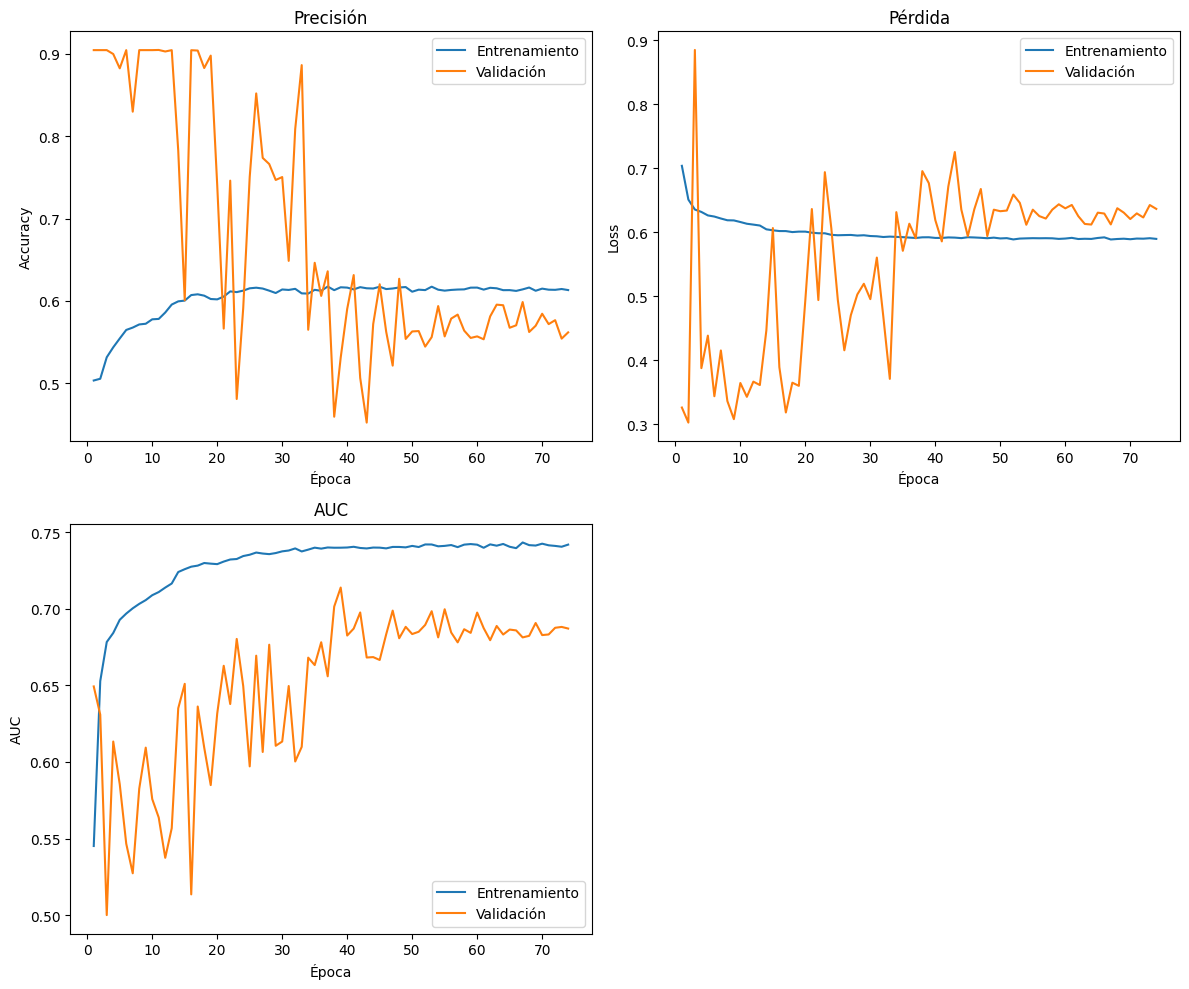

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1940/1940 [==============================] - 33s 16ms/step - loss: 0.7015 - accuracy: 0.4867 - precision: 0.9128 - recall: 0.4760 - auc: 0.5460 - val_loss: 0.4358 - val_accuracy: 0.8930 - val_precision: 0.8931 - val_recall: 0.9998 - val_auc: 0.6311 - lr: 5.0000e-04
Epoch 2/100
1940/1940 [==============================] - 28s 14ms/step - loss: 0.6495 - accuracy: 0.5254 - precision: 0.9364 - recall: 0.5079 - auc: 0.6374 - val_loss: 0.4297 - val_accuracy: 0.8932 - val_precision: 0.8932 - val_recall: 1.0000 - val_auc: 0.5059 - lr: 5.0000e-04
Epoch 3/100
1940/1940 [==============================] - 30s 15ms/step - loss: 0.6348 - accuracy: 0.5587 - precision: 0.9427 - recall: 0.5434 - auc: 0.6694 - val_loss: 0.3518 - val_accuracy: 0.8932 - val_precision: 0.8932 - val_recall: 1.0000 - val_auc: 0.5667 - lr: 5.0000e-04
Epoch 4/100
1940/1940 [==============================] - 29s 15ms/step - loss: 0.6308 - accuracy: 0.5573 - precision: 0.9457 - recall: 0.5398 - auc: 0.6763 - val_loss: 0.4093 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.47      0.51      0.49        57
           1       0.93      0.92      0.93       421

    accuracy                           0.87       478
   macro avg       0.70      0.72      0.71       478
weighted avg       0.88      0.87      0.87       478

AUC clase 1: 0.8775680293370004
F1: 0.927120669056153

Accuracy: 0.8723849372384938

Precision: 0.9326923076923077

Recall: 0.9216152019002375

Confusion:
 [[ 29  28]
 [ 33 388]]


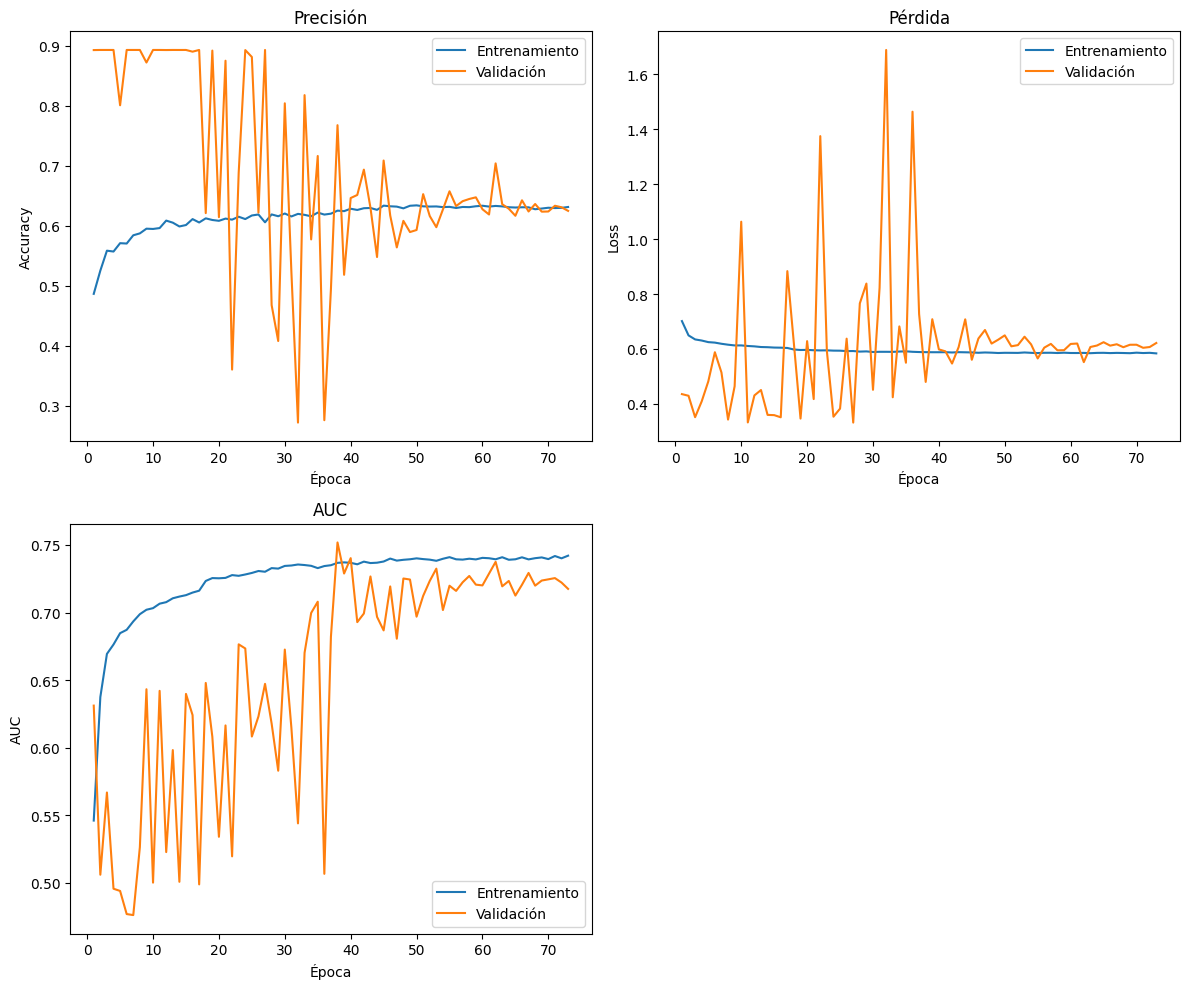

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1961/1961 [==============================] - 31s 15ms/step - loss: 0.6990 - accuracy: 0.4717 - precision: 0.9156 - recall: 0.4547 - auc: 0.5511 - val_loss: 0.4444 - val_accuracy: 0.8014 - val_precision: 0.8965 - val_recall: 0.8808 - val_auc: 0.5615 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 27s 14ms/step - loss: 0.6486 - accuracy: 0.4733 - precision: 0.9450 - recall: 0.4403 - auc: 0.6406 - val_loss: 0.7641 - val_accuracy: 0.2862 - val_precision: 0.9417 - val_recall: 0.2197 - val_auc: 0.5606 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 33s 17ms/step - loss: 0.6296 - accuracy: 0.5273 - precision: 0.9510 - recall: 0.5004 - auc: 0.6796 - val_loss: 0.3775 - val_accuracy: 0.8922 - val_precision: 0.8984 - val_recall: 0.9923 - val_auc: 0.4963 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 30s 15ms/step - loss: 0.6213 - accuracy: 0.5404 - precision: 0.9530 - recall: 0.5145 - auc: 0.6912 - val_loss: 0.7658 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.20      0.89      0.32        57
           1       0.97      0.51      0.67       421

    accuracy                           0.55       478
   macro avg       0.59      0.70      0.50       478
weighted avg       0.88      0.55      0.63       478

AUC clase 1: 0.8617327165895737
F1: 0.6677067082683308

Accuracy: 0.5543933054393305

Precision: 0.9727272727272728

Recall: 0.5083135391923991

Confusion:
 [[ 51   6]
 [207 214]]


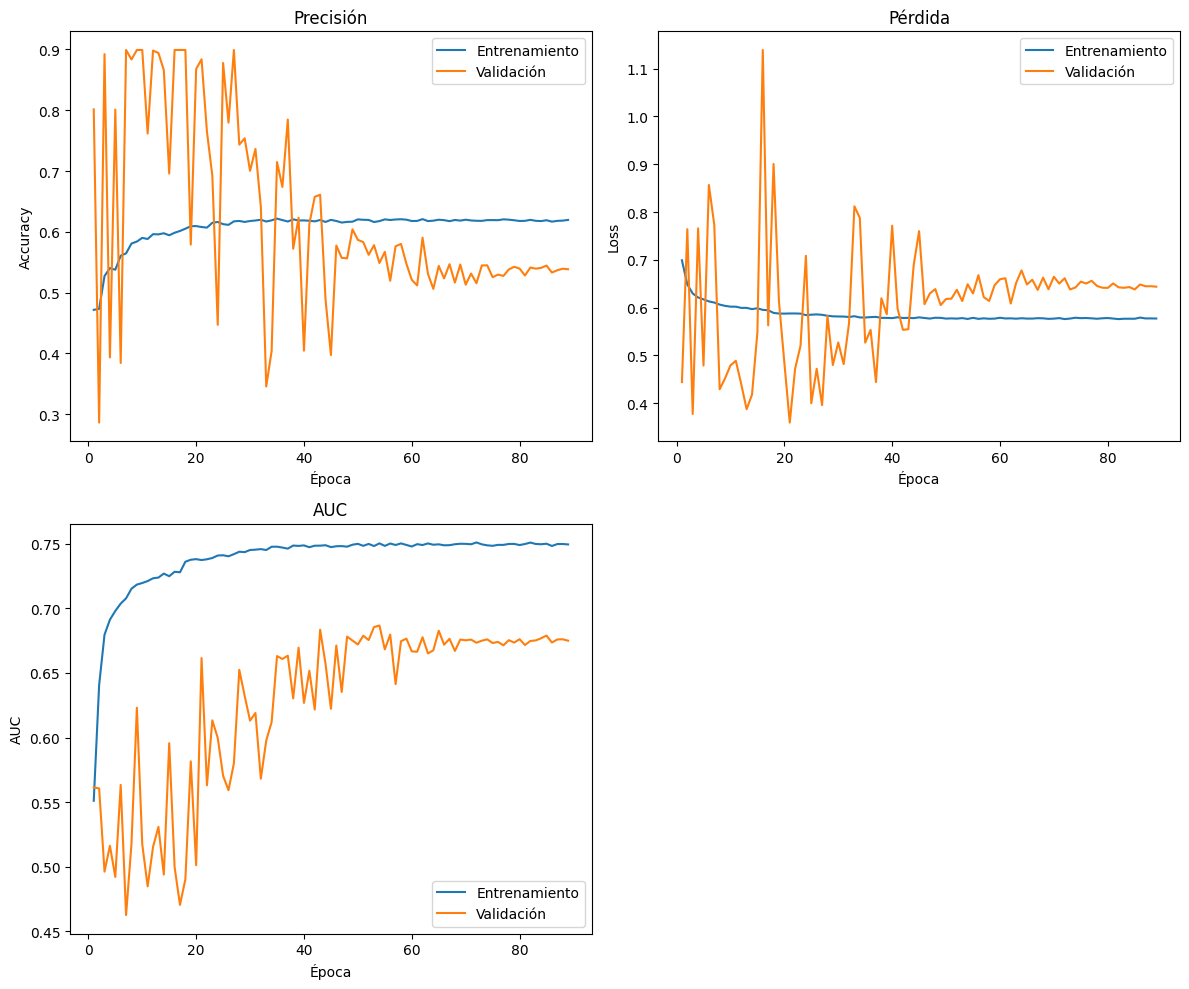

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1960/1960 [==============================] - 31s 15ms/step - loss: 0.6986 - accuracy: 0.4958 - precision: 0.9149 - recall: 0.4847 - auc: 0.5522 - val_loss: 0.7219 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5037 - lr: 5.0000e-04
Epoch 2/100
1960/1960 [==============================] - 30s 15ms/step - loss: 0.6518 - accuracy: 0.4929 - precision: 0.9423 - recall: 0.4649 - auc: 0.6425 - val_loss: 0.4288 - val_accuracy: 0.8552 - val_precision: 0.8964 - val_recall: 0.9486 - val_auc: 0.5735 - lr: 5.0000e-04
Epoch 3/100
1960/1960 [==============================] - 30s 15ms/step - loss: 0.6383 - accuracy: 0.5354 - precision: 0.9460 - recall: 0.5129 - auc: 0.6696 - val_loss: 0.3645 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5152 - lr: 5.0000e-04
Epoch 4/100
1960/1960 [==============================] - 30s 15ms/step - loss: 0.6305 - accuracy: 0.5554 - precision: 0.9481 - recall: 0.5351 - auc: 0.6838 - val_loss: 0.3454 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.25      0.91      0.40        57
           1       0.98      0.64      0.77       421

    accuracy                           0.67       478
   macro avg       0.62      0.77      0.58       478
weighted avg       0.89      0.67      0.73       478

AUC clase 1: 0.8837354669333667
F1: 0.7723342939481268

Accuracy: 0.6694560669456067

Precision: 0.9816849816849816

Recall: 0.6365795724465558

Confusion:
 [[ 52   5]
 [153 268]]


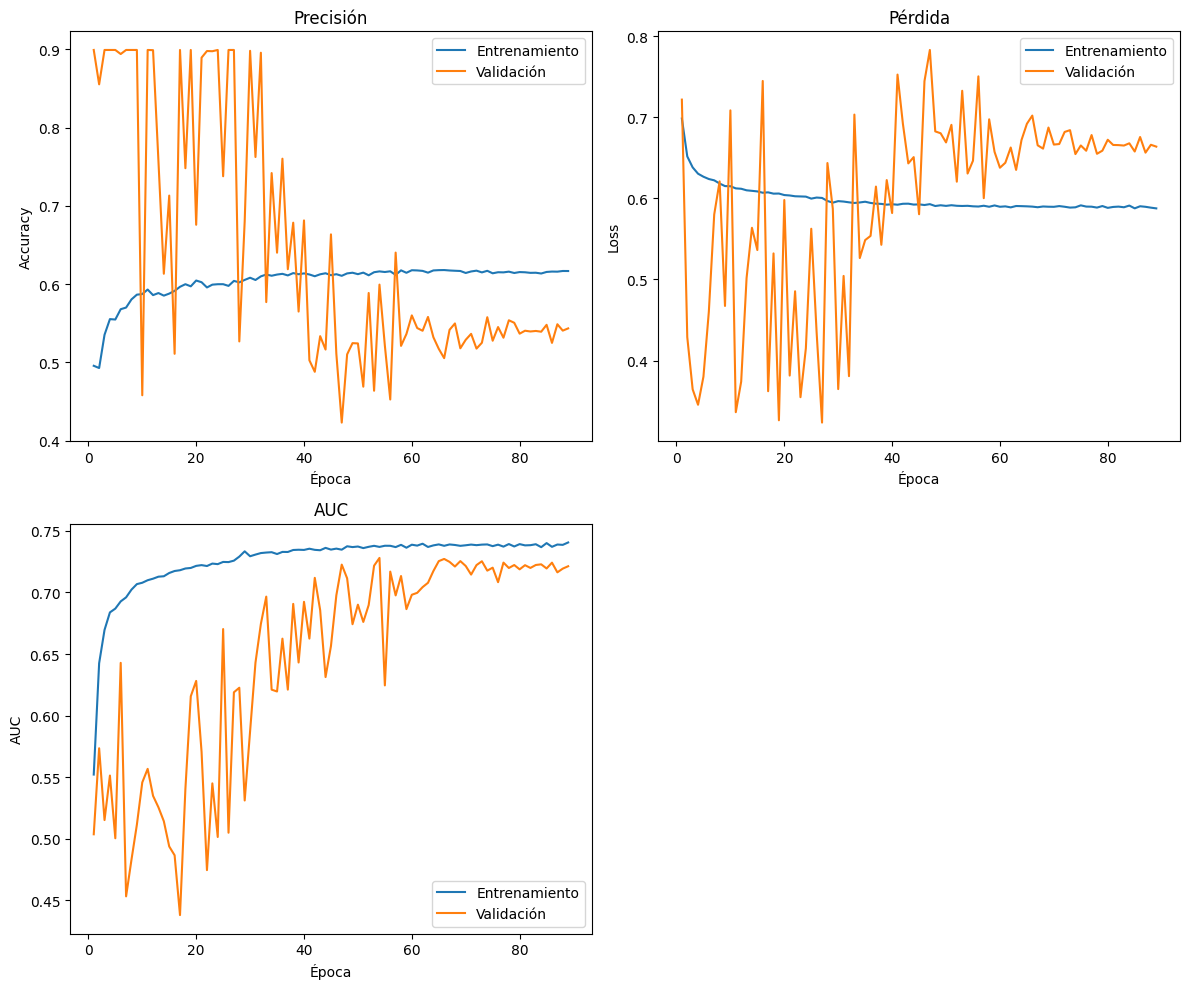

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1961/1961 [==============================] - 31s 15ms/step - loss: 0.6913 - accuracy: 0.4790 - precision: 0.9197 - recall: 0.4606 - auc: 0.5707 - val_loss: 0.7614 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.4813 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 30s 15ms/step - loss: 0.6453 - accuracy: 0.5051 - precision: 0.9432 - recall: 0.4783 - auc: 0.6558 - val_loss: 0.3424 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.6177 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 30s 15ms/step - loss: 0.6315 - accuracy: 0.5479 - precision: 0.9481 - recall: 0.5258 - auc: 0.6831 - val_loss: 0.4658 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.5384 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 30s 15ms/step - loss: 0.6241 - accuracy: 0.5487 - precision: 0.9510 - recall: 0.5249 - auc: 0.6940 - val_loss: 0.7133 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.41      0.46      0.43        57
           1       0.93      0.91      0.92       421

    accuracy                           0.86       478
   macro avg       0.67      0.68      0.68       478
weighted avg       0.86      0.86      0.86       478

AUC clase 1: 0.8419385756552903
F1: 0.9186602870813397

Accuracy: 0.8577405857740585

Precision: 0.9253012048192771

Recall: 0.9121140142517815

Confusion:
 [[ 26  31]
 [ 37 384]]


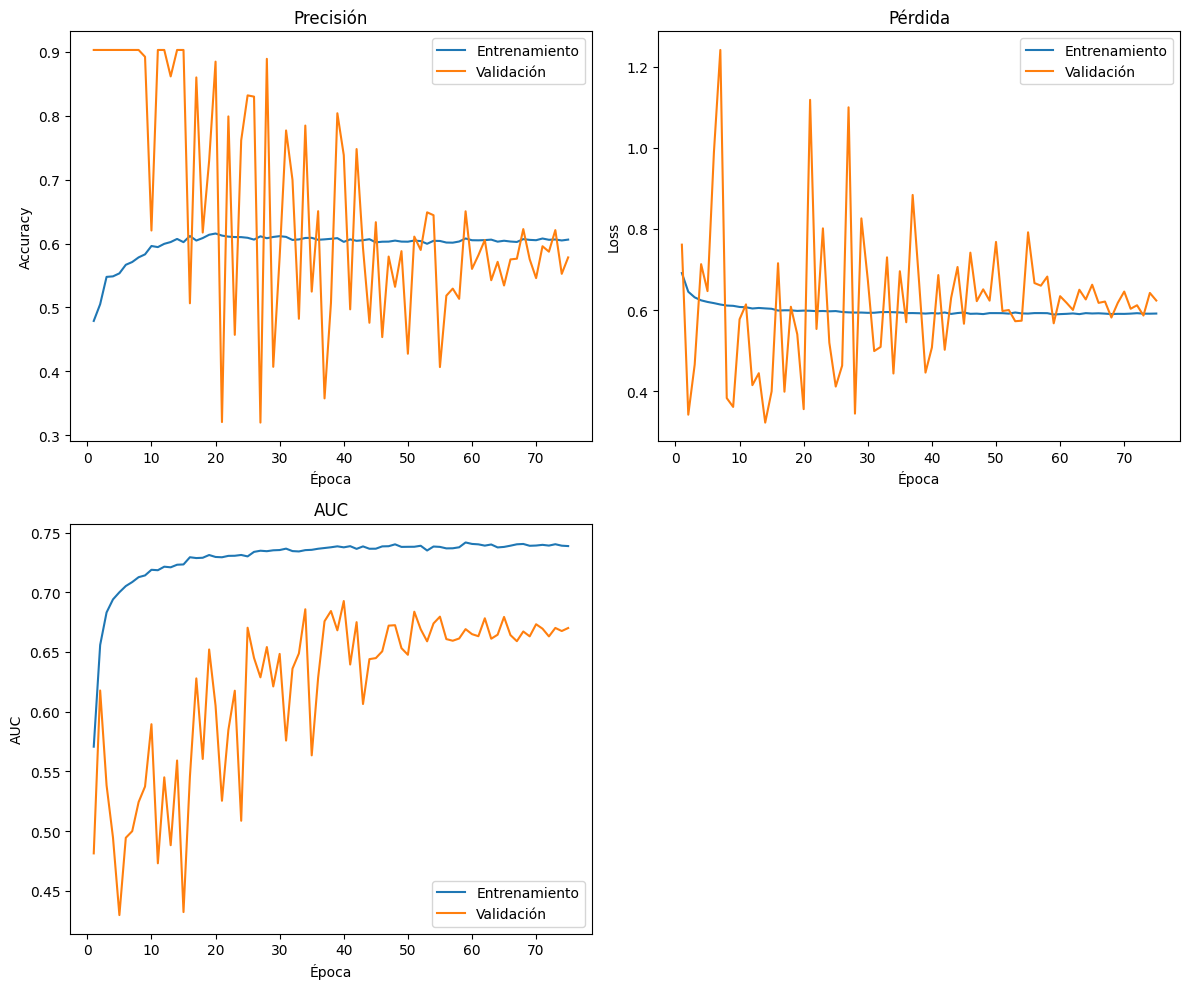

In [29]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    print("----Training metrics------")
    model = GATGraphClassifier(n_classes=1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
          validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch, epochs=100, callbacks=callbacks )


    y_score_test = model.predict(test_loader,steps=test_loader.steps_per_epoch).ravel()
    y_true  = Y_coded[test_indices]



    # Calculo del umbral optimo por el indice de Youden
    y_score_val = model.predict(val_loader,steps=val_loader.steps_per_epoch).ravel()
    fpr, tpr, thresholds = roc_curve(val_labels[i], y_score_val)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    print("Umbral óptimo según Youden:", best_threshold)
    y_pred  =  (y_score_test>= 0.5).astype(int) # y_score_test son las probabilidades del conjunto de test
    
    y_probs_patient,y_true_patient, y_pred_patient = collect_metrics(y_score_test, Y_coded, y_pred, test_indices)
    print("\n----General Metrics------\n")
    print(classification_report(y_true_patient,y_pred_patient))
    f1=f1_score(y_true_patient, y_pred_patient)
    acc=accuracy_score(y_true_patient, y_pred_patient)
    prec=precision_score(y_true_patient, y_pred_patient)
    rec=recall_score(y_true_patient, y_pred_patient)
    auc = roc_auc_score(y_true_patient, y_probs_patient)

    print("AUC clase 1:", auc)
    print("F1:", f1)
    print("\nAccuracy:", acc)
    print("\nPrecision:",prec )
    print("\nRecall:",rec )
    precision.append(prec)
    recall.append(rec)
    accuracy.append(auc)
    F1.append(f1)
    AUC.append(auc)
    print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))

    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, val_auc, label='Validación')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1

In [67]:
b_acc = [0.68,0.77,0.70,0.72,0.72]
print("Balanced accuracy: "+str(sum(b_acc)/5))

Balanced accuracy: 0.718


In [37]:
print("Precision: "+str(sum(precision)/5))
print("Recall: "+str(sum(recall)/5))
print("AUC: "+str(sum(AUC)/5))
print("F1: "+str(sum(F1)/5))
print("Accuracy: "+str(sum(accuracy)/5))

Precision: 0.9596509647055225
Recall: 0.6950118764845605
AUC: 0.8658665666541652
F1: 0.7892339019393524
Accuracy: 0.8658665666541652


**Shallow Results**

In [68]:
shallow_bacc   =  [0.80,0.81,0.81,0.82, 0.83]
shallow_auc    =  [0.9079884985623202, 0.9089469517022962,0.9014876859607451,0.9046547485102304,0.91094720173355]
shallow_F1     =  [0.817174515235457,0.8793774319066148,0.9040404040404041,0.8601864181091877,0.8976982097186701]
shallow_acc    =  [0.7238493723849372,0.805439330543933,0.8410041841004184,0.7803347280334728,0.8326359832635983]
shallow_prec   =  [0.9800664451827242,0.9685714285714285,0.9649595687331537,0.9787878787878788,0.9722991689750693] 
shallow_recall =  [0.7007125890736342,0.8052256532066508,0.850356294536817,0.7672209026128266,0.833729216152019]

In [69]:
print("Precision: "+str(sum(shallow_prec)/5))
print("Recall: "+str(sum(shallow_recall)/5))
print("AUC: "+str(sum(shallow_auc)/5))
print("F1: "+str(sum(shallow_F1)/5))
print("Accuracy: "+str(sum(shallow_acc)/5))
print("Balanced accuracy: "+str(sum(shallow_bacc)/5))

Precision: 0.9729368980500508
Recall: 0.7914489311163895
AUC: 0.9068050172938286
F1: 0.8716953958020668
Accuracy: 0.796652719665272
Balanced accuracy: 0.8139999999999998


----Training metrics------
Epoch 1/100
1965/1965 [==============================] - 26s 13ms/step - loss: 0.5689 - accuracy: 0.6078 - precision: 0.9683 - recall: 0.5825 - auc: 0.7704 - val_loss: 0.7850 - val_accuracy: 0.4247 - val_precision: 0.9602 - val_recall: 0.3797 - val_auc: 0.6329 - lr: 5.0000e-04
Epoch 2/100
1965/1965 [==============================] - 23s 12ms/step - loss: 0.5416 - accuracy: 0.6532 - precision: 0.9710 - recall: 0.6328 - auc: 0.7979 - val_loss: 0.7141 - val_accuracy: 0.4692 - val_precision: 0.9564 - val_recall: 0.4328 - val_auc: 0.6427 - lr: 5.0000e-04
Epoch 3/100
1965/1965 [==============================] - 22s 11ms/step - loss: 0.5247 - accuracy: 0.6836 - precision: 0.9708 - recall: 0.6680 - auc: 0.8136 - val_loss: 0.8197 - val_accuracy: 0.4515 - val_precision: 0.9547 - val_recall: 0.4131 - val_auc: 0.6380 - lr: 5.0000e-04
Epoch 4/100
1965/1965 [==============================] - 25s 12ms/step - loss: 0.5144 - accuracy: 0.6868 - precision: 0.9722 - recall: 0.67

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.29      0.89      0.44        57
           1       0.98      0.70      0.82       421

    accuracy                           0.72       478
   macro avg       0.63      0.80      0.63       478
weighted avg       0.90      0.72      0.77       478

AUC clase 1: 0.9079884985623202
F1: 0.817174515235457

Accuracy: 0.7238493723849372

Precision: 0.9800664451827242

Recall: 0.7007125890736342

Confusion:
 [[ 51   6]
 [126 295]]


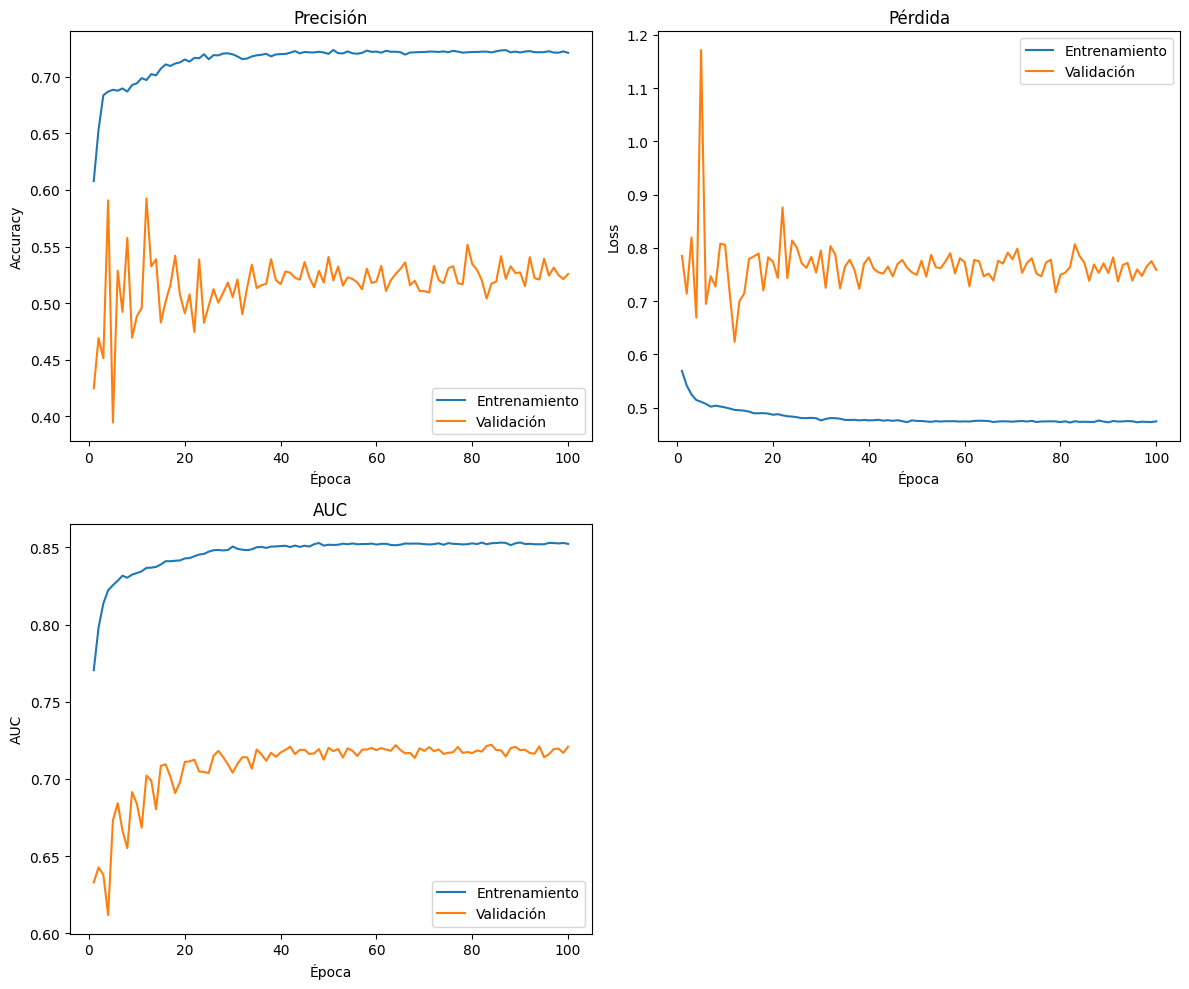

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1940/1940 [==============================] - 27s 13ms/step - loss: 0.5666 - accuracy: 0.6767 - precision: 0.9661 - recall: 0.6647 - auc: 0.7884 - val_loss: 0.6161 - val_accuracy: 0.5438 - val_precision: 0.9540 - val_recall: 0.5141 - val_auc: 0.6922 - lr: 5.0000e-04
Epoch 2/100
1940/1940 [==============================] - 21s 11ms/step - loss: 0.5171 - accuracy: 0.6953 - precision: 0.9706 - recall: 0.6826 - auc: 0.8139 - val_loss: 0.8305 - val_accuracy: 0.5360 - val_precision: 0.9507 - val_recall: 0.5068 - val_auc: 0.6812 - lr: 5.0000e-04
Epoch 3/100
1940/1940 [==============================] - 23s 12ms/step - loss: 0.5132 - accuracy: 0.6953 - precision: 0.9711 - recall: 0.6822 - auc: 0.8177 - val_loss: 0.6412 - val_accuracy: 0.6003 - val_precision: 0.9169 - val_recall: 0.6075 - val_auc: 0.6392 - lr: 5.0000e-04
Epoch 4/100
1940/1940 [==============================] - 23s 12ms/step - loss: 0.5089 - accuracy: 0.6908 - precision: 0.9726 - recall: 0.6760 - auc: 0.8212 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.36      0.81      0.50        57
           1       0.97      0.81      0.88       421

    accuracy                           0.81       478
   macro avg       0.66      0.81      0.69       478
weighted avg       0.90      0.81      0.83       478

AUC clase 1: 0.9089469517022962
F1: 0.8793774319066148

Accuracy: 0.805439330543933

Precision: 0.9685714285714285

Recall: 0.8052256532066508

Confusion:
 [[ 46  11]
 [ 82 339]]


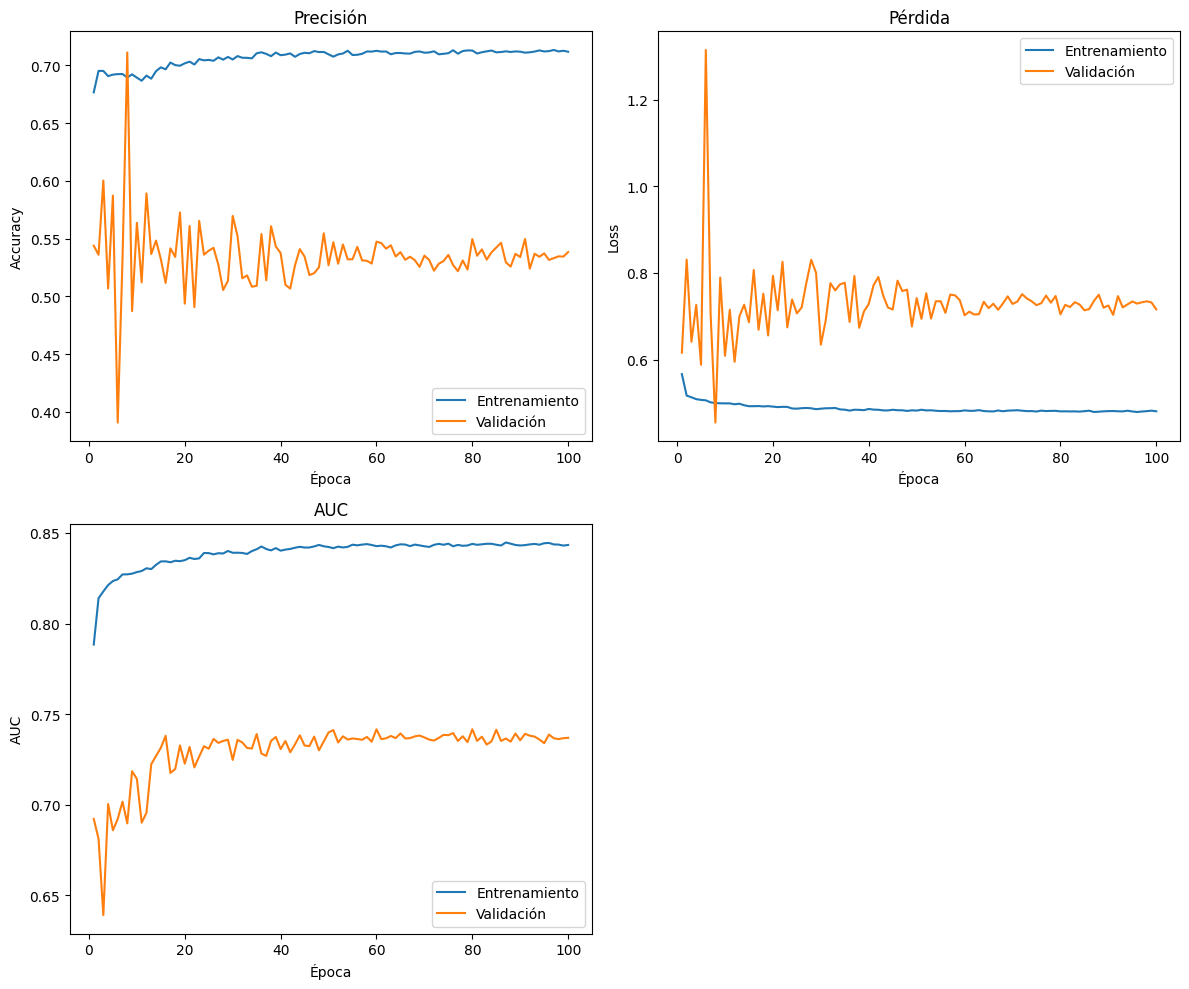

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1961/1961 [==============================] - 24s 12ms/step - loss: 0.6308 - accuracy: 0.6488 - precision: 0.9656 - recall: 0.6322 - auc: 0.7778 - val_loss: 0.7205 - val_accuracy: 0.5540 - val_precision: 0.9226 - val_recall: 0.5501 - val_auc: 0.6059 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 22s 11ms/step - loss: 0.5249 - accuracy: 0.6599 - precision: 0.9726 - recall: 0.6401 - auc: 0.8121 - val_loss: 1.0071 - val_accuracy: 0.3407 - val_precision: 0.9648 - val_recall: 0.2768 - val_auc: 0.6312 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 20s 10ms/step - loss: 0.5243 - accuracy: 0.6574 - precision: 0.9735 - recall: 0.6366 - auc: 0.8135 - val_loss: 0.6973 - val_accuracy: 0.5049 - val_precision: 0.9396 - val_recall: 0.4802 - val_auc: 0.6365 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 22s 11ms/step - loss: 0.5203 - accuracy: 0.6721 - precision: 0.9727 - recall: 0.6540 - auc: 0.8172 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.41      0.77      0.54        57
           1       0.96      0.85      0.90       421

    accuracy                           0.84       478
   macro avg       0.69      0.81      0.72       478
weighted avg       0.90      0.84      0.86       478

AUC clase 1: 0.9014876859607451
F1: 0.9040404040404041

Accuracy: 0.8410041841004184

Precision: 0.9649595687331537

Recall: 0.850356294536817

Confusion:
 [[ 44  13]
 [ 63 358]]


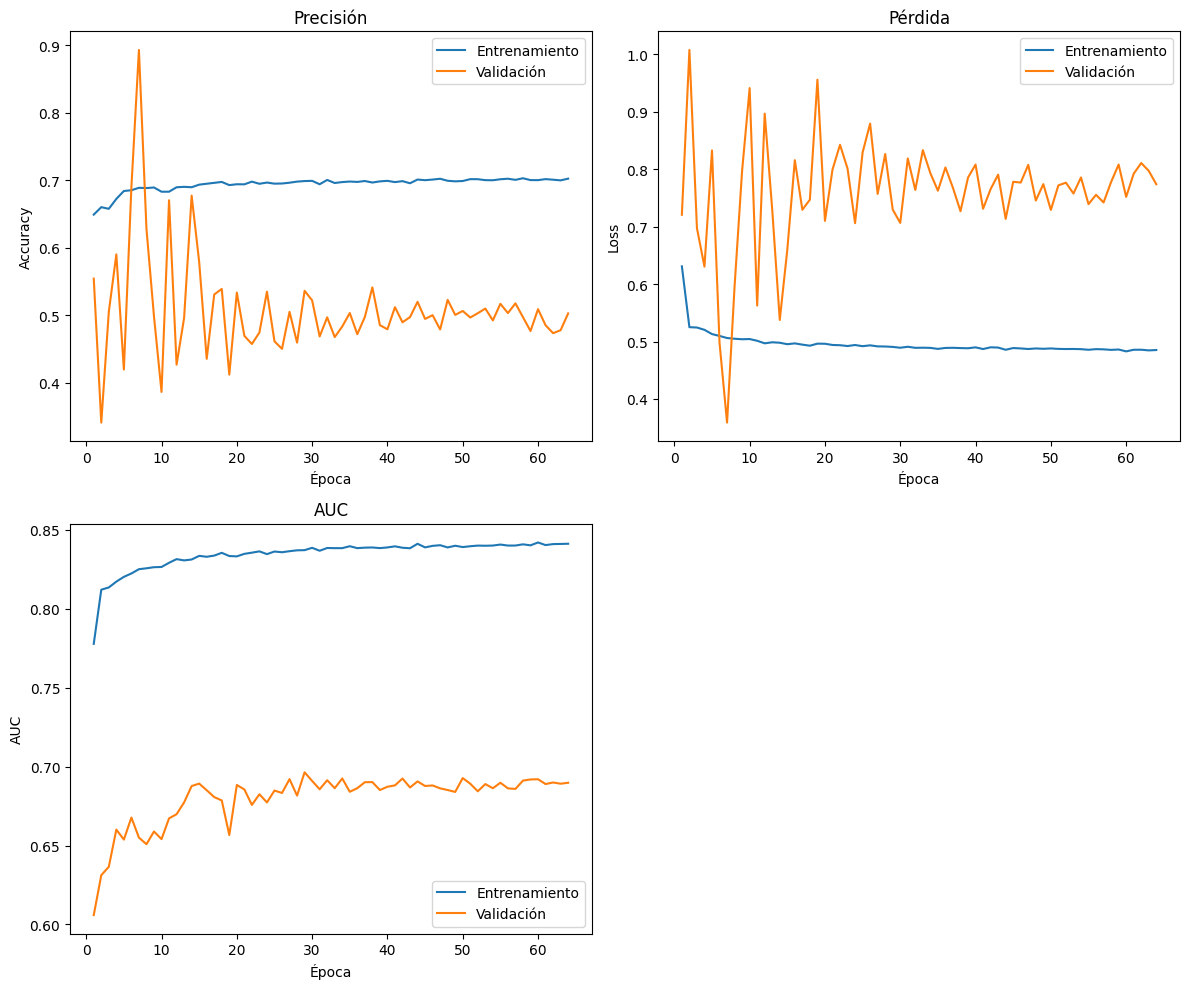

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1960/1960 [==============================] - 24s 12ms/step - loss: 0.5792 - accuracy: 0.6653 - precision: 0.9639 - recall: 0.6524 - auc: 0.7771 - val_loss: 0.6317 - val_accuracy: 0.6317 - val_precision: 0.9286 - val_recall: 0.6395 - val_auc: 0.6438 - lr: 5.0000e-04
Epoch 2/100
1960/1960 [==============================] - 22s 11ms/step - loss: 0.5368 - accuracy: 0.6640 - precision: 0.9712 - recall: 0.6456 - auc: 0.8022 - val_loss: 0.6990 - val_accuracy: 0.4195 - val_precision: 0.9563 - val_recall: 0.3713 - val_auc: 0.6059 - lr: 5.0000e-04
Epoch 3/100
1960/1960 [==============================] - 20s 10ms/step - loss: 0.5268 - accuracy: 0.6695 - precision: 0.9732 - recall: 0.6506 - auc: 0.8099 - val_loss: 0.6875 - val_accuracy: 0.5196 - val_precision: 0.9508 - val_recall: 0.4911 - val_auc: 0.6804 - lr: 5.0000e-04
Epoch 4/100
1960/1960 [==============================] - 22s 11ms/step - loss: 0.5211 - accuracy: 0.6775 - precision: 0.9720 - recall: 0.6606 - auc: 0.8140 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.34      0.88      0.49        57
           1       0.98      0.77      0.86       421

    accuracy                           0.78       478
   macro avg       0.66      0.82      0.67       478
weighted avg       0.90      0.78      0.82       478

AUC clase 1: 0.9046547485102304
F1: 0.8601864181091877

Accuracy: 0.7803347280334728

Precision: 0.9787878787878788

Recall: 0.7672209026128266

Confusion:
 [[ 50   7]
 [ 98 323]]


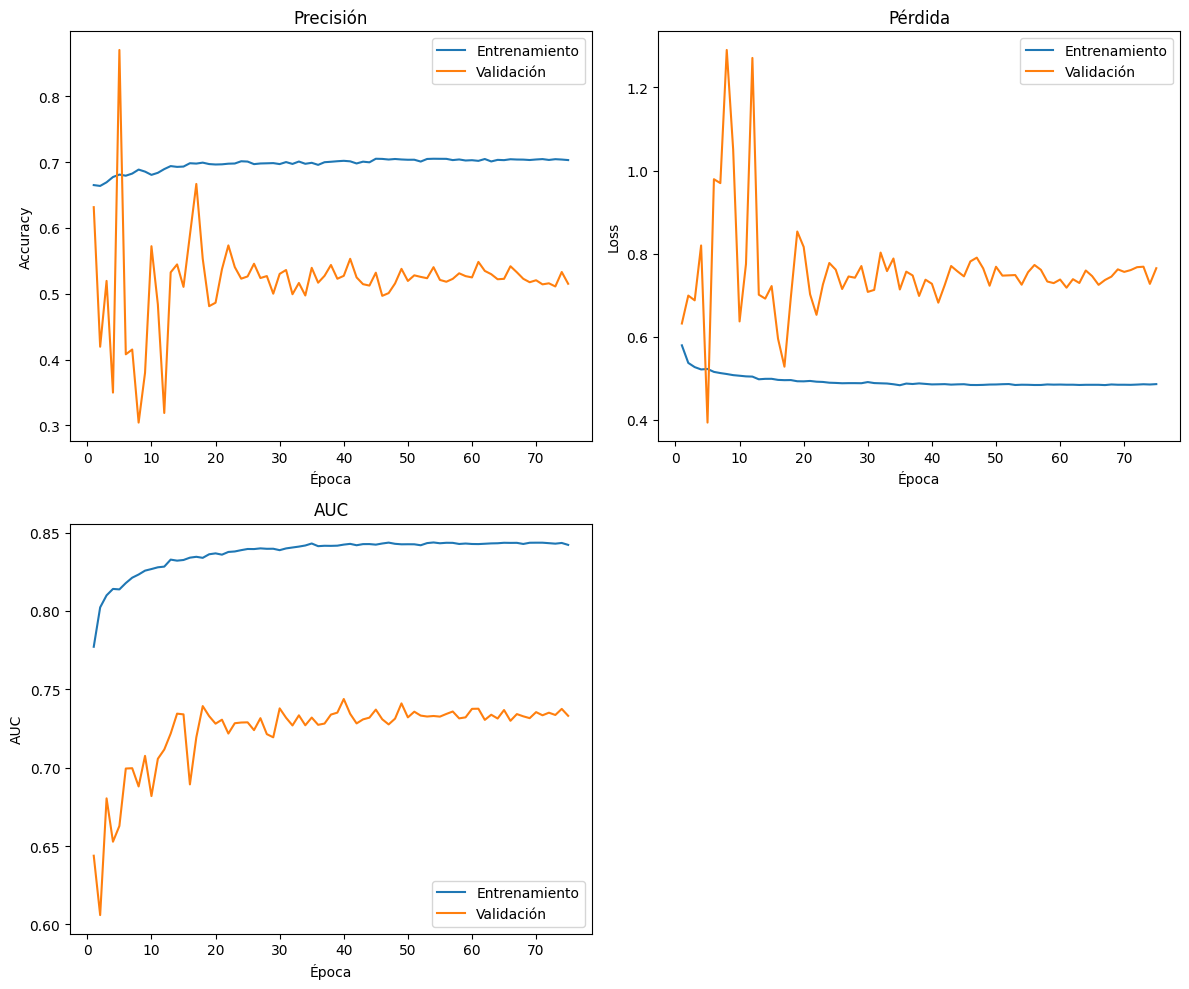

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1961/1961 [==============================] - 21s 10ms/step - loss: 0.5778 - accuracy: 0.6183 - precision: 0.9722 - recall: 0.5923 - auc: 0.7881 - val_loss: 0.7791 - val_accuracy: 0.3584 - val_precision: 0.9683 - val_recall: 0.2990 - val_auc: 0.6347 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 23s 11ms/step - loss: 0.5221 - accuracy: 0.6766 - precision: 0.9733 - recall: 0.6583 - auc: 0.8150 - val_loss: 0.4699 - val_accuracy: 0.8397 - val_precision: 0.8995 - val_recall: 0.9259 - val_auc: 0.5475 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 20s 10ms/step - loss: 0.5113 - accuracy: 0.6976 - precision: 0.9738 - recall: 0.6819 - auc: 0.8216 - val_loss: 2.0598 - val_accuracy: 0.2152 - val_precision: 0.9811 - val_recall: 0.1331 - val_auc: 0.6391 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 22s 11ms/step - loss: 0.5056 - accuracy: 0.6959 - precision: 0.9744 - recall: 0.6795 - auc: 0.8249 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.40      0.82      0.54        57
           1       0.97      0.83      0.90       421

    accuracy                           0.83       478
   macro avg       0.69      0.83      0.72       478
weighted avg       0.90      0.83      0.86       478

AUC clase 1: 0.91094720173355
F1: 0.8976982097186701

Accuracy: 0.8326359832635983

Precision: 0.9722991689750693

Recall: 0.833729216152019

Confusion:
 [[ 47  10]
 [ 70 351]]


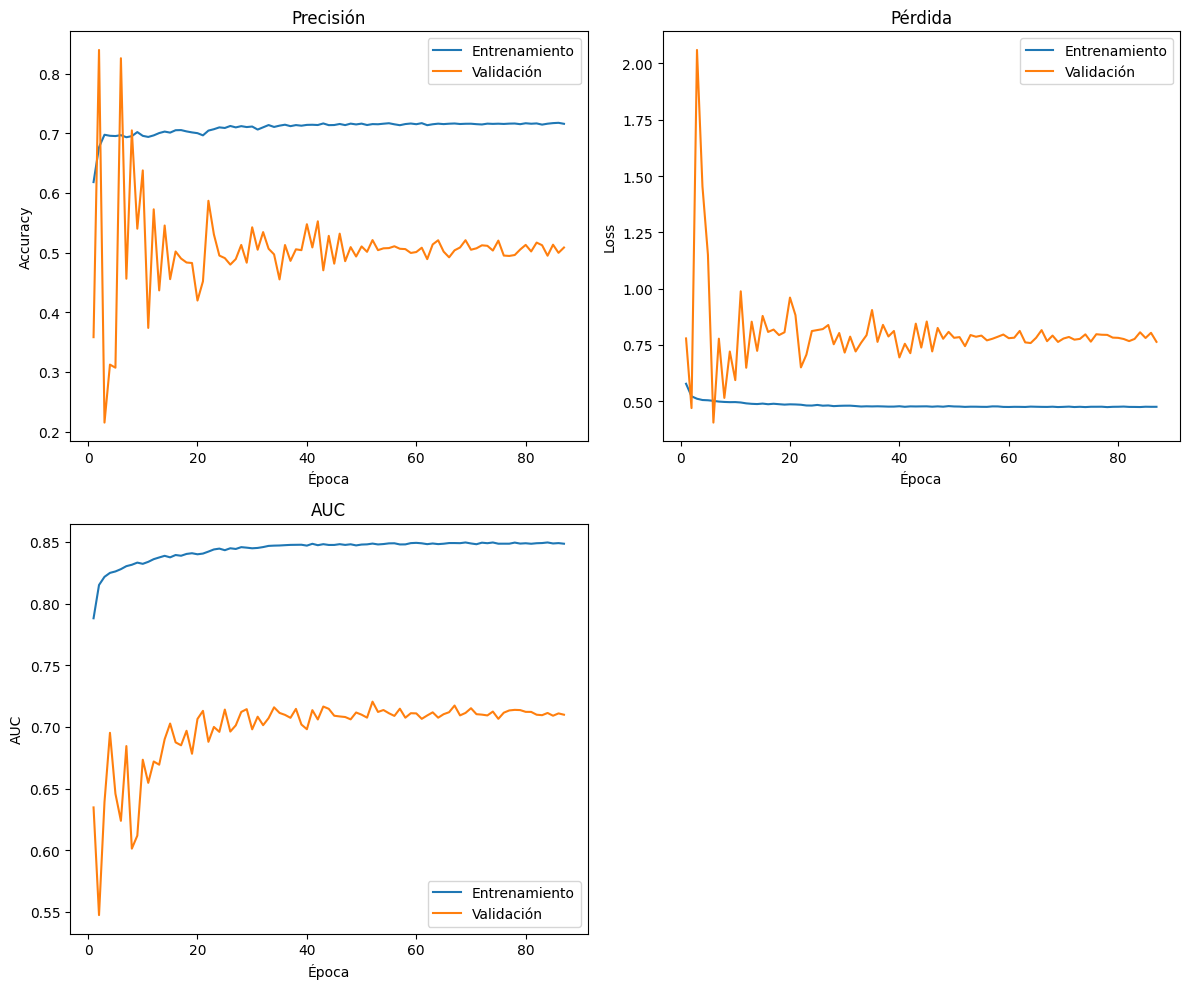

In [24]:
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    print("----Training metrics------")
    model = ShallowGNN(32,20,10) # Podria cogerse cualquier dataset de los folds
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
          validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch, epochs=100,callbacks=callbacks)


    y_score_test = model.predict(test_loader,steps=test_loader.steps_per_epoch).ravel()
    y_true  = Y_coded[test_indices]



    # Calculo del umbral optimo por el indice de Youden
    y_score_val = model.predict(val_loader,steps=val_loader.steps_per_epoch).ravel()
    fpr, tpr, thresholds = roc_curve(val_labels[i], y_score_val)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    print("Umbral óptimo según Youden:", best_threshold)
    y_pred  =  (y_score_test>= best_threshold).astype(int) # y_score_test son las probabilidades del conjunto de test
    
    y_probs_patient,y_true_patient, y_pred_patient = collect_metrics(y_score_test, Y_coded, y_pred, test_indices)
    print("\n----General Metrics------\n")
    print(classification_report(y_true_patient,y_pred_patient))
    f1=f1_score(y_true_patient, y_pred_patient)
    acc=accuracy_score(y_true_patient, y_pred_patient)
    prec=precision_score(y_true_patient, y_pred_patient)
    rec=recall_score(y_true_patient, y_pred_patient)
    auc = roc_auc_score(y_true_patient, y_probs_patient)

    print("AUC clase 1:", auc)
    print("F1:", f1)
    print("\nAccuracy:", acc)
    print("\nPrecision:",prec )
    print("\nRecall:",rec )
    precision.append(prec)
    recall.append(rec)
    accuracy.append(auc)
    F1.append(f1)
    AUC.append(auc)
    print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))

    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    tr_bal_acc = history.history['accuracy']
    val_bal_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, val_auc, label='Validación')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1

**GCN Conv Results**

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1965/1965 [==============================] - 32s 15ms/step - loss: 0.5394 - accuracy: 0.6922 - precision: 0.9690 - recall: 0.6791 - auc: 0.8101 - val_loss: 0.7655 - val_accuracy: 0.4853 - val_precision: 0.9652 - val_recall: 0.4470 - val_auc: 0.6919 - lr: 5.0000e-04
Epoch 2/100
1965/1965 [==============================] - 28s 14ms/step - loss: 0.4982 - accuracy: 0.7148 - precision: 0.9720 - recall: 0.7028 - auc: 0.8344 - val_loss: 0.6111 - val_accuracy: 0.6326 - val_precision: 0.9303 - val_recall: 0.6419 - val_auc: 0.6485 - lr: 5.0000e-04
Epoch 3/100
1965/1965 [==============================] - 28s 14ms/step - loss: 0.4878 - accuracy: 0.7255 - precision: 0.9718 - recall: 0.7152 - auc: 0.8413 - val_loss: 0.5317 - val_accuracy: 0.7164 - val_precision: 0.9198 - val_recall: 0.7520 - val_auc: 0.6460 - lr: 5.0000e-04
Epoch 4/100
1965/1965 [==============================] - 28s 14ms/step - loss: 0.4820 - accuracy: 0.7307 - precision: 0.9725 - recall: 0.7206 - auc: 0.8449 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.39      0.88      0.54        57
           1       0.98      0.81      0.89       421

    accuracy                           0.82       478
   macro avg       0.68      0.84      0.71       478
weighted avg       0.91      0.82      0.85       478

AUC clase 1: 0.8974455140225861
F1: 0.8883116883116883

Accuracy: 0.8200836820083682

Precision: 0.9799426934097422

Recall: 0.8123515439429929

Confusion:
 [[ 50   7]
 [ 79 342]]


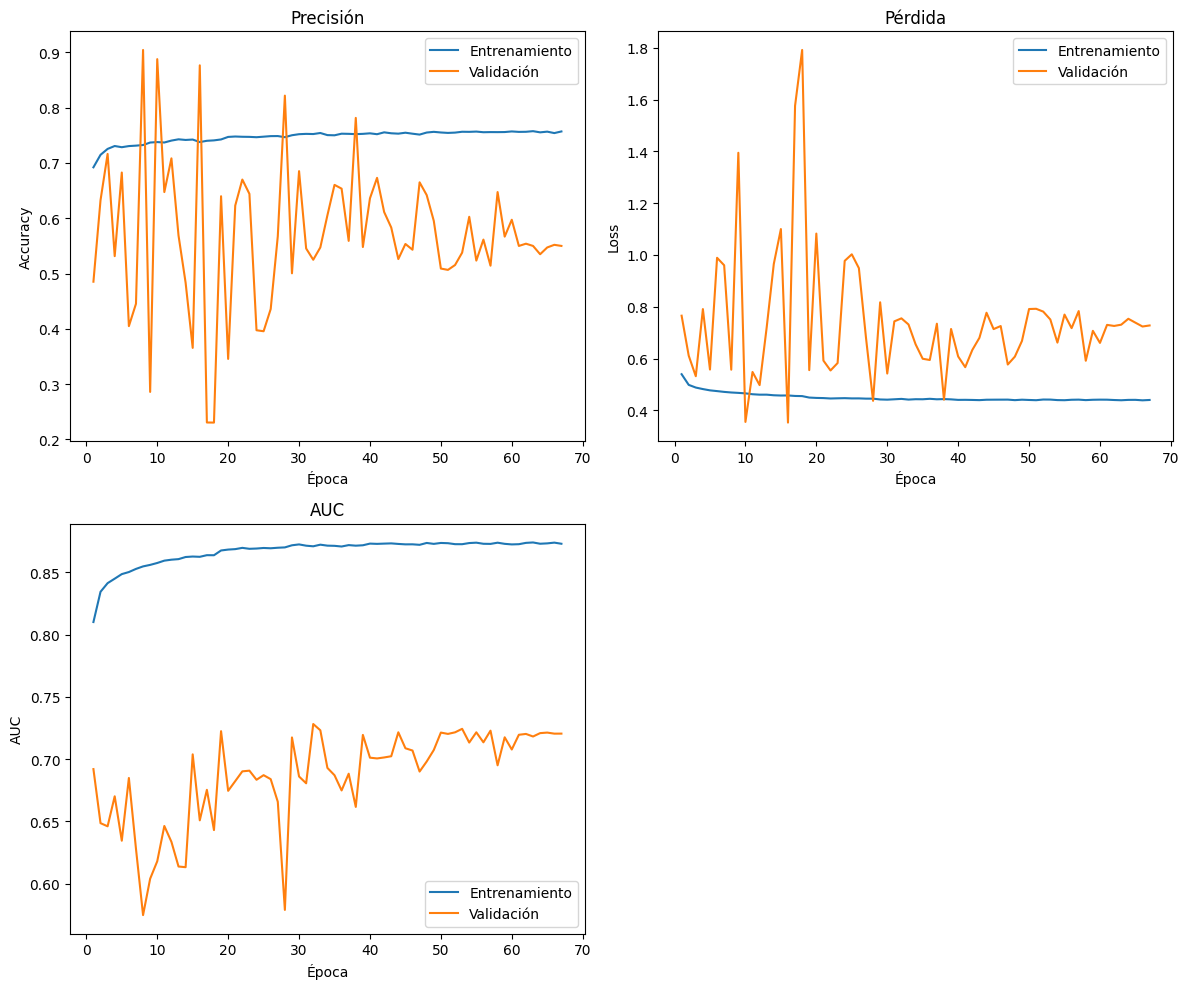

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1940/1940 [==============================] - 30s 15ms/step - loss: 0.5239 - accuracy: 0.6920 - precision: 0.9697 - recall: 0.6796 - auc: 0.8143 - val_loss: 0.5830 - val_accuracy: 0.5882 - val_precision: 0.9575 - val_recall: 0.5640 - val_auc: 0.7177 - lr: 5.0000e-04
Epoch 2/100
1940/1940 [==============================] - 28s 14ms/step - loss: 0.4982 - accuracy: 0.7014 - precision: 0.9730 - recall: 0.6877 - auc: 0.8301 - val_loss: 0.9302 - val_accuracy: 0.4724 - val_precision: 0.9526 - val_recall: 0.4307 - val_auc: 0.6661 - lr: 5.0000e-04
Epoch 3/100
1940/1940 [==============================] - 25s 13ms/step - loss: 0.4914 - accuracy: 0.7098 - precision: 0.9735 - recall: 0.6971 - auc: 0.8349 - val_loss: 0.8109 - val_accuracy: 0.4860 - val_precision: 0.9588 - val_recall: 0.4436 - val_auc: 0.6787 - lr: 5.0000e-04
Epoch 4/100
1940/1940 [==============================] - 28s 14ms/step - loss: 0.4894 - accuracy: 0.7074 - precision: 0.9737 - recall: 0.6941 - auc: 0.8361 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.35      0.82      0.49        57
           1       0.97      0.79      0.87       421

    accuracy                           0.79       478
   macro avg       0.66      0.81      0.68       478
weighted avg       0.90      0.79      0.83       478

AUC clase 1: 0.9023627953494187
F1: 0.8717277486910995

Accuracy: 0.7949790794979079

Precision: 0.9708454810495627

Recall: 0.7909738717339667

Confusion:
 [[ 47  10]
 [ 88 333]]


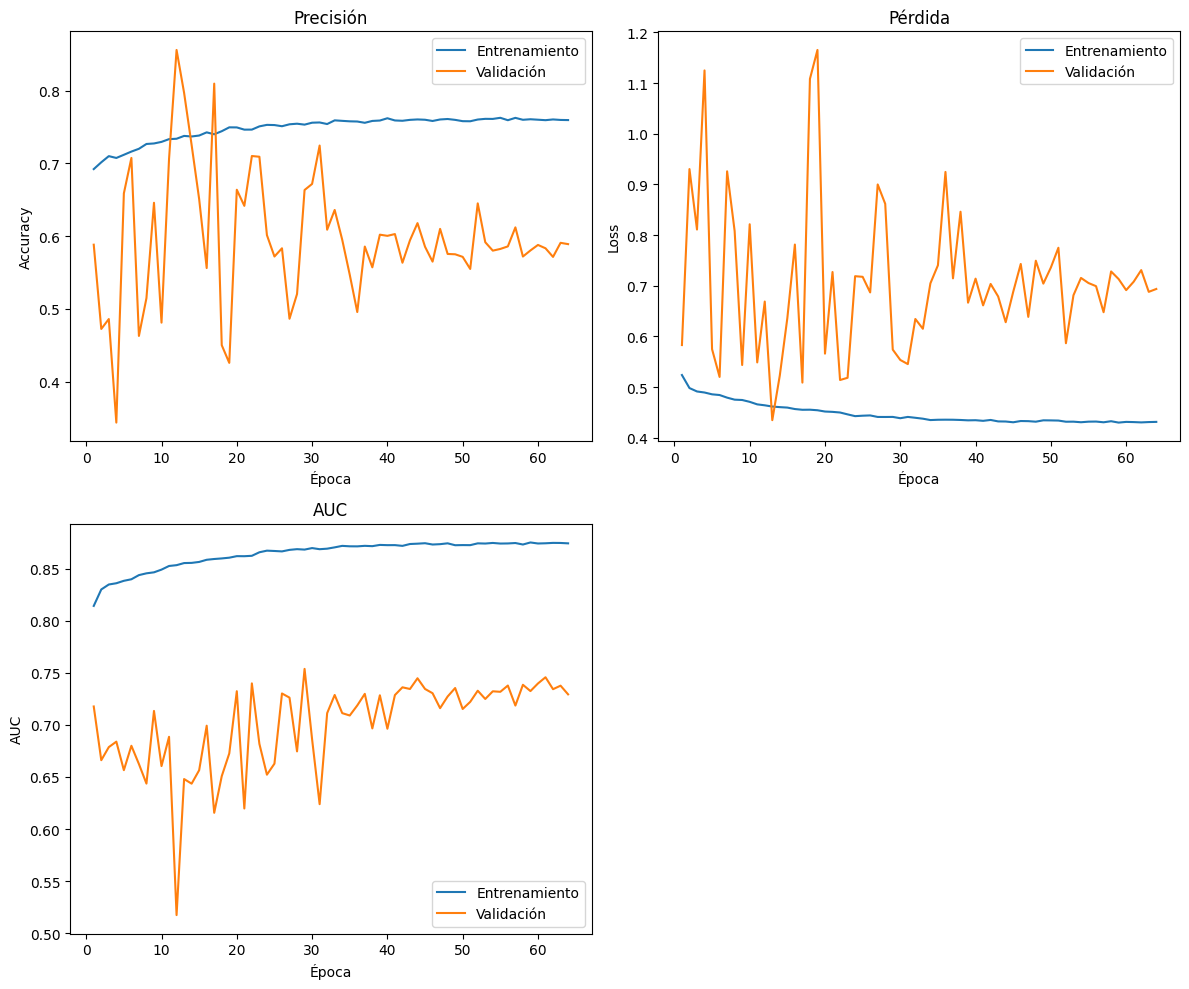

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1961/1961 [==============================] - 30s 14ms/step - loss: 0.5329 - accuracy: 0.6999 - precision: 0.9676 - recall: 0.6896 - auc: 0.8100 - val_loss: 0.6203 - val_accuracy: 0.6416 - val_precision: 0.9209 - val_recall: 0.6579 - val_auc: 0.6314 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 25s 13ms/step - loss: 0.4949 - accuracy: 0.7071 - precision: 0.9730 - recall: 0.6937 - auc: 0.8350 - val_loss: 0.8604 - val_accuracy: 0.4789 - val_precision: 0.9451 - val_recall: 0.4464 - val_auc: 0.6530 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 28s 14ms/step - loss: 0.4863 - accuracy: 0.7086 - precision: 0.9749 - recall: 0.6941 - auc: 0.8412 - val_loss: 0.6850 - val_accuracy: 0.5758 - val_precision: 0.9320 - val_recall: 0.5697 - val_auc: 0.6267 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 28s 14ms/step - loss: 0.4808 - accuracy: 0.7082 - precision: 0.9753 - recall: 0.6932 - auc: 0.8448 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.35      0.86      0.50        57
           1       0.98      0.79      0.87       421

    accuracy                           0.79       478
   macro avg       0.66      0.82      0.69       478
weighted avg       0.90      0.79      0.83       478

AUC clase 1: 0.91428095178564
F1: 0.8710526315789474

Accuracy: 0.7949790794979079

Precision: 0.976401179941003

Recall: 0.7862232779097387

Confusion:
 [[ 49   8]
 [ 90 331]]


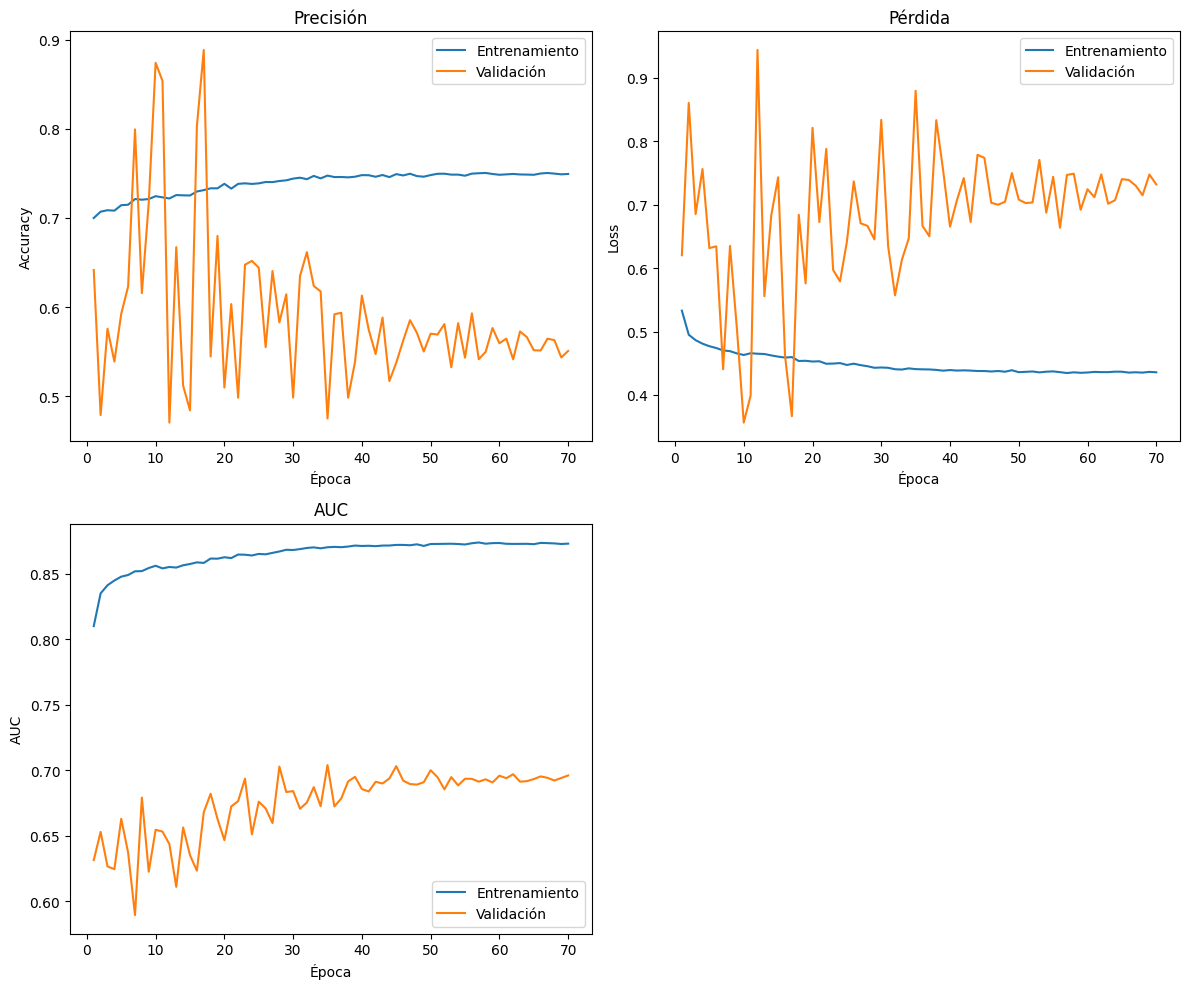

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1960/1960 [==============================] - 30s 15ms/step - loss: 0.5457 - accuracy: 0.6908 - precision: 0.9664 - recall: 0.6799 - auc: 0.8004 - val_loss: 0.9655 - val_accuracy: 0.3936 - val_precision: 0.9585 - val_recall: 0.3403 - val_auc: 0.6608 - lr: 5.0000e-04
Epoch 2/100
1960/1960 [==============================] - 28s 14ms/step - loss: 0.5040 - accuracy: 0.7045 - precision: 0.9711 - recall: 0.6922 - auc: 0.8290 - val_loss: 1.1477 - val_accuracy: 0.4153 - val_precision: 0.9763 - val_recall: 0.3584 - val_auc: 0.6983 - lr: 5.0000e-04
Epoch 3/100
1960/1960 [==============================] - 28s 14ms/step - loss: 0.4968 - accuracy: 0.7074 - precision: 0.9718 - recall: 0.6950 - auc: 0.8339 - val_loss: 0.5486 - val_accuracy: 0.6538 - val_precision: 0.9278 - val_recall: 0.6669 - val_auc: 0.6815 - lr: 5.0000e-04
Epoch 4/100
1960/1960 [==============================] - 25s 13ms/step - loss: 0.4922 - accuracy: 0.7113 - precision: 0.9716 - recall: 0.6996 - auc: 0.8367 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.35      0.84      0.50        57
           1       0.97      0.79      0.87       421

    accuracy                           0.80       478
   macro avg       0.66      0.82      0.69       478
weighted avg       0.90      0.80      0.83       478

AUC clase 1: 0.9032795766137434
F1: 0.872870249017038

Accuracy: 0.797071129707113

Precision: 0.9736842105263158

Recall: 0.7909738717339667

Confusion:
 [[ 48   9]
 [ 88 333]]


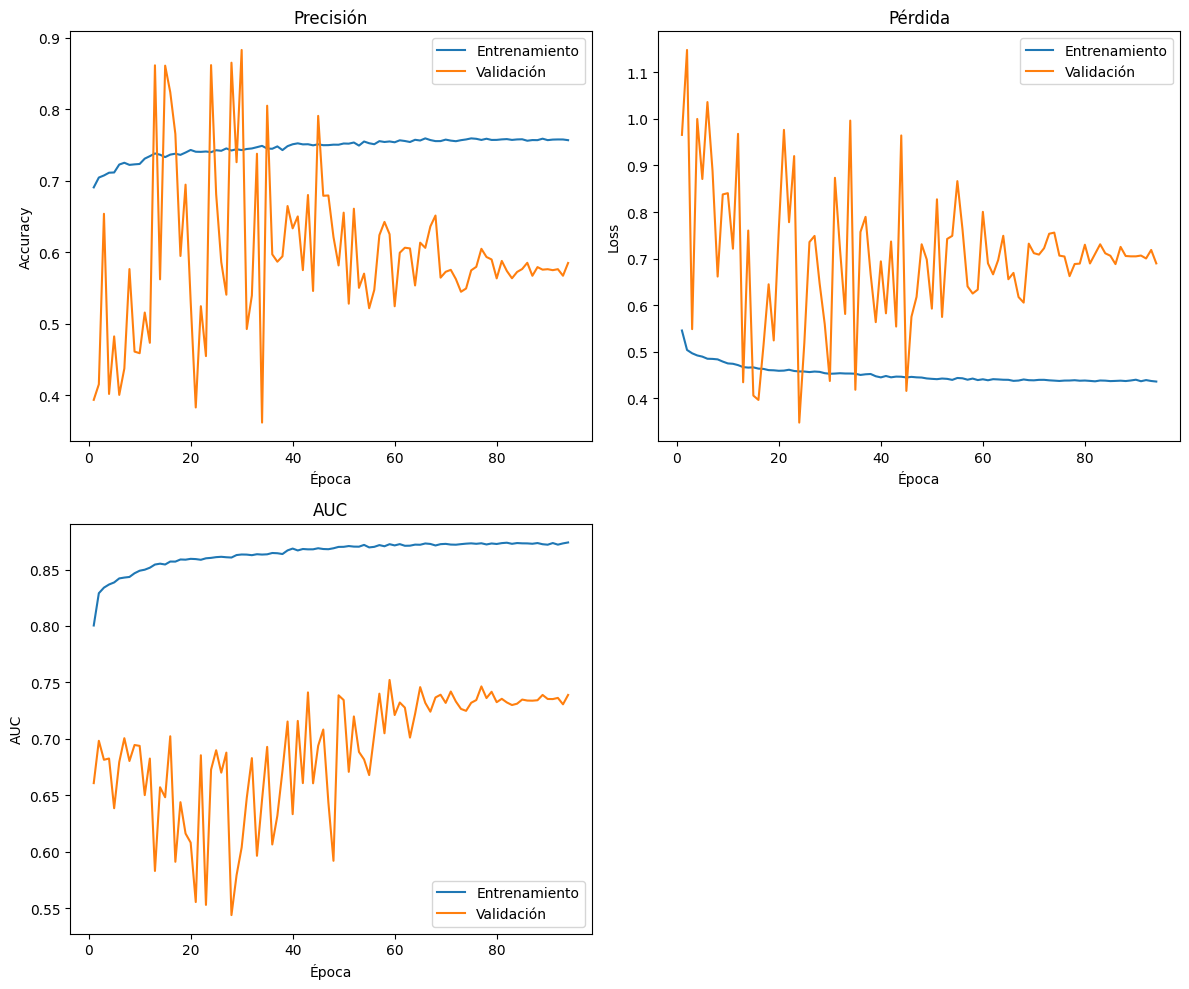

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1961/1961 [==============================] - 30s 14ms/step - loss: 0.5319 - accuracy: 0.6749 - precision: 0.9720 - recall: 0.6573 - auc: 0.8114 - val_loss: 0.7921 - val_accuracy: 0.4657 - val_precision: 0.9586 - val_recall: 0.4265 - val_auc: 0.6607 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 26s 13ms/step - loss: 0.4973 - accuracy: 0.6954 - precision: 0.9752 - recall: 0.6783 - auc: 0.8321 - val_loss: 0.6453 - val_accuracy: 0.6311 - val_precision: 0.9136 - val_recall: 0.6531 - val_auc: 0.5615 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 28s 14ms/step - loss: 0.4903 - accuracy: 0.7081 - precision: 0.9749 - recall: 0.6930 - auc: 0.8374 - val_loss: 0.6790 - val_accuracy: 0.5383 - val_precision: 0.9316 - val_recall: 0.5272 - val_auc: 0.6298 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 28s 14ms/step - loss: 0.4837 - accuracy: 0.7130 - precision: 0.9752 - recall: 0.6985 - auc: 0.8418 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.41      0.86      0.55        57
           1       0.98      0.83      0.90       421

    accuracy                           0.83       478
   macro avg       0.69      0.85      0.73       478
weighted avg       0.91      0.83      0.86       478

AUC clase 1: 0.9243238738175606
F1: 0.8985879332477535

Accuracy: 0.8347280334728033

Precision: 0.9776536312849162

Recall: 0.831353919239905

Confusion:
 [[ 49   8]
 [ 71 350]]


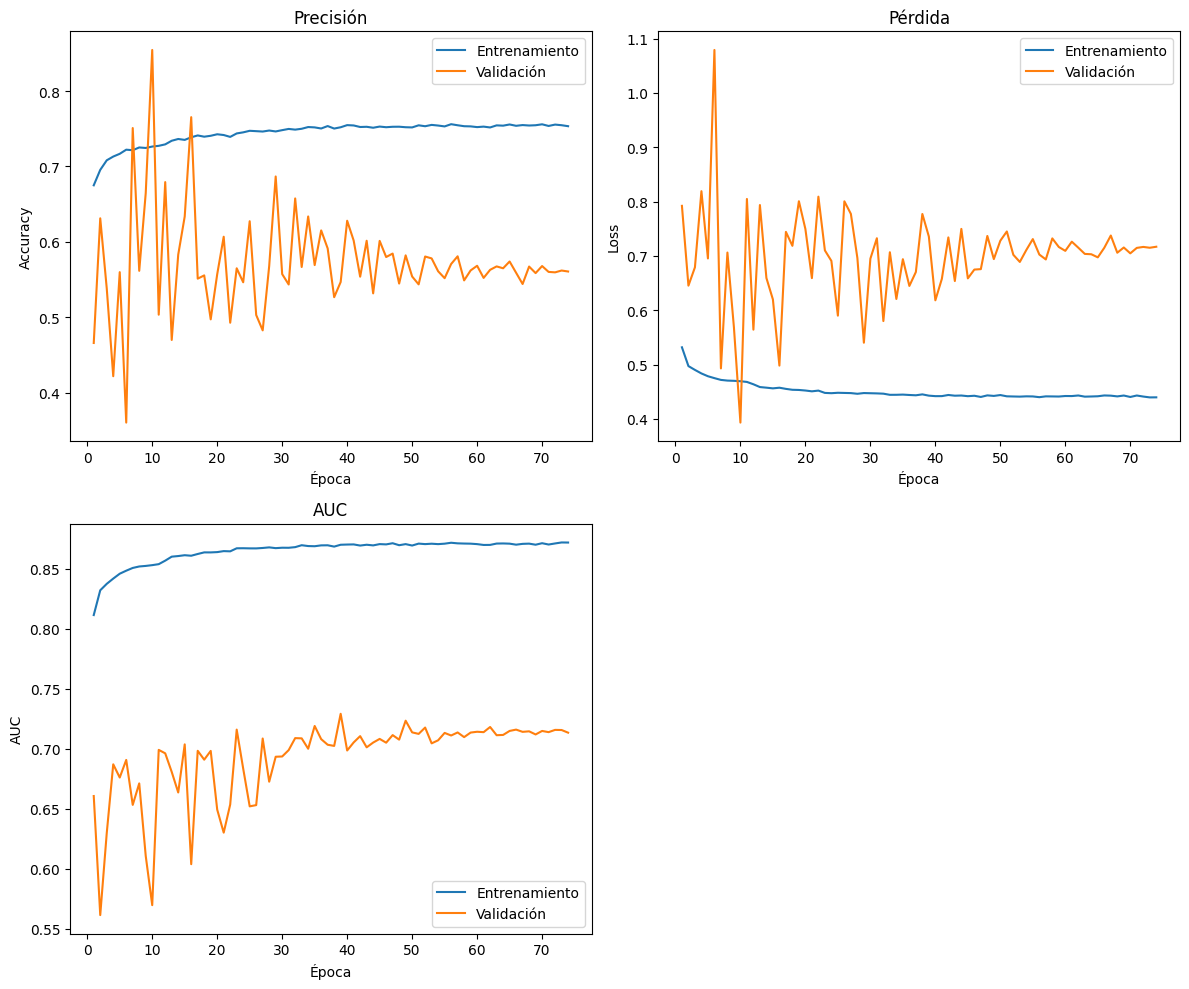

In [27]:
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    model = GraphConvNetReduced(16,32,64) 
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    print("----Training metrics------")
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
          validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch, epochs=100,callbacks=callbacks)

    y_score_test = model.predict(test_loader,steps=test_loader.steps_per_epoch).ravel()
    y_true  = Y_coded[test_indices]

    # Calculo del umbral optimo por el indice de Youden
    y_score_val = model.predict(val_loader,steps=val_loader.steps_per_epoch).ravel()
    fpr, tpr, thresholds = roc_curve(val_labels[i], y_score_val)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    print("Umbral óptimo según Youden:", best_threshold)
    y_pred  =  (y_score_test>= best_threshold).astype(int) # y_score_test son las probabilidades del conjunto de test
    
    y_probs_patient,y_true_patient, y_pred_patient = collect_metrics(y_score_test, Y_coded, y_pred, test_indices)
    print("\n----General Metrics------\n")
    print(classification_report(y_true_patient,y_pred_patient))
    f1=f1_score(y_true_patient, y_pred_patient)
    acc=accuracy_score(y_true_patient, y_pred_patient)
    prec=precision_score(y_true_patient, y_pred_patient)
    rec=recall_score(y_true_patient, y_pred_patient)
    auc = roc_auc_score(y_true_patient, y_probs_patient)
    
    print("AUC clase 1:", auc)
    print("F1:", f1)
    print("\nAccuracy:", acc)
    print("\nPrecision:",prec )
    print("\nRecall:",rec )
    precision.append(prec)
    recall.append(rec)
    accuracy.append(auc)
    F1.append(f1)
    AUC.append(auc)
    print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))


    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, val_auc, label='Validación')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1

In [70]:
GCN_Conv_bacc   =  [0.84,0.81,0.82,0.82, 0.85]
GCN_Conv_auc    =  [0.8974455140225861, 0.9023627953494187,0.91428095178564,0.9032795766137434,0.9243238738175606]
GCN_Conv_F1     =  [0.8883116883116883,0.8717277486910995,0.8710526315789474,0.872870249017038,0.8985879332477535]
GCN_Conv_acc    =  [0.8200836820083682,0.7949790794979079,0.7949790794979079,0.797071129707113,0.8347280334728033]
GCN_Conv_prec   =  [0.9799426934097422,0.9708454810495627,0.976401179941003,0.9736842105263158,0.9776536312849162] 
GCN_Conv_recall =  [0.8123515439429929,0.7909738717339667,0.7862232779097387,0.7909738717339667,0.831353919239905]

In [71]:
print("Precision: "+str(sum(GCN_Conv_prec)/5))
print("Recall: "+str(sum(GCN_Conv_recall)/5))
print("AUC: "+str(sum(GCN_Conv_auc)/5))
print("F1: "+str(sum(GCN_Conv_F1)/5))
print("Accuracy: "+str(sum(GCN_Conv_acc)/5))
print("Balanced accuracy: "+str(sum(GCN_Conv_bacc)/5))

Precision: 0.9757054392423081
Recall: 0.8023752969121138
AUC: 0.9083385423177898
F1: 0.8805100501693053
Accuracy: 0.80836820083682
Balanced accuracy: 0.828


**Deep Results**

In [72]:
deep_bacc   =  [0.82,0.85,0.82 ,0.82 ,0.84]
deep_auc    =  [0.9084885610701338, 0.9156561236821269, 0.9012793265824895, 0.921073467516773, 0.9204483893820061]
deep_F1     =  [0.851006711409396,0.8792650918635171, 0.8710526315789474,0.9136420525657072,0.8685258964143426]
deep_acc    =  [0.7677824267782427,0.8075313807531381, 0.7949790794979079, 0.8556485355648535, 0.7928870292887029]
deep_prec   =  [0.9783950617283951,0.9824046920821115, 0.976401179941003, 0.9656084656084656, 0.9849397590361446] 
deep_recall =  [0.7529691211401425,0.7957244655581948, 0.7862232779097387,0.8669833729216152, 0.7767220902612827]

In [73]:
print("Precision: "+str(sum(deep_prec)/5))
print("Recall: "+str(sum(deep_recall)/5))
print("AUC: "+str(sum(deep_auc)/5))
print("F1: "+str(sum(deep_F1)/5))
print("Accuracy: "+str(sum(deep_acc)/5))
print("Balanced accuracy: "+str(sum(deep_bacc)/5))

Precision: 0.9775498316792239
Recall: 0.7957244655581948
AUC: 0.913389173646706
F1: 0.8766984767663821
Accuracy: 0.803765690376569
Balanced accuracy: 0.8299999999999998


**Predicciones por sujeto**

La predicción a nivel de sujeto se calcula como la moda de todas las ventanas que pertenecen a este y la media de las probabilidades será usada para el cálculo de AUC

In [33]:
class TestSetCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_loader, test_loader, val_labels, labels, test_indices):
        super().__init__()
        self.val_loader   = val_loader
        self.test_loader  = test_loader
        self.val_labels   = val_labels
        self.labels       = labels
        self.test_indices = test_indices
        self.test_history = {"accuracy": [], "auc": []}
    def on_epoch_end(self, epoch, logs=None):
        y_score_test = model.predict(self.test_loader,steps=self.test_loader.steps_per_epoch).ravel()
        # Calculo del umbral optimo por el indice de Youden
        y_score_val = model.predict(self.val_loader,steps=self.val_loader.steps_per_epoch).ravel()
        fpr, tpr, thresholds = roc_curve(self.val_labels, y_score_val)
        youden_index = tpr - fpr
        best_threshold = thresholds[np.argmax(youden_index)]
        print("Umbral óptimo según Youden:", best_threshold)
        y_pred  =  (y_score_test>= best_threshold).astype(int) # y_score_test son las probabilidades del conjunto de test
        
        y_probs_patient, y_true_patient, y_pred_patient = collect_metrics(y_score_test, self.labels , y_pred, self.test_indices)

        acc=accuracy_score(y_true_patient, y_pred_patient)
        auc = roc_auc_score(y_true_patient, y_probs_patient)
        self.test_history["accuracy"].append(acc)
        self.test_history["auc"].append(auc)

    def on_train_end(self, logs=None):
        y_score_test = model.predict(self.test_loader,steps=self.test_loader.steps_per_epoch).ravel()
        # Calculo del umbral optimo por el indice de Youden
        y_score_val = model.predict(self.val_loader,steps=self.val_loader.steps_per_epoch).ravel()
        fpr, tpr, thresholds = roc_curve(self.val_labels, y_score_val)
        youden_index = tpr - fpr
        best_threshold = thresholds[np.argmax(youden_index)]
        print("Umbral óptimo según Youden:", best_threshold)
        y_pred  =  (y_score_test>= best_threshold).astype(int) # y_score_test son las probabilidades del conjunto de test
        
        y_probs_patient,y_true_patient, y_pred_patient = collect_metrics(y_score_test, Y_coded, y_pred, test_indices)
        print("\n----General Metrics------\n")
        print(classification_report(y_true_patient,y_pred_patient))
        f1=f1_score(y_true_patient, y_pred_patient)
        acc=accuracy_score(y_true_patient, y_pred_patient)
        prec=precision_score(y_true_patient, y_pred_patient)
        rec=recall_score(y_true_patient, y_pred_patient)
        auc = roc_auc_score(y_true_patient, y_probs_patient)
    
        print("AUC clase 1:", auc)
        print("\nF1:", f1)
        print("\nAccuracy:", acc)
        print("\nPrecision:",prec )
        print("\nRecall:",rec )
        precision.append(prec)
        recall.append(rec)
        accuracy.append(auc)
        F1.append(f1)
        AUC.append(auc)
        print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))

**Importantisimo steps_per_epoch es un parametro para indicar cuantos batches ha de tomar**

**Deep GNN con pesos y optimizacion**

In [34]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0
# Definir los callbacks
checkpoint_cb = ModelCheckpoint(filepath="Deep_opt64_V2.ckpt",   # nombre del archivo
monitor="val_auc",mode="max",save_best_only=True,save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=35, restore_best_weights=True),
reduce_lr = ReduceLROnPlateau(monitor='val_auc',patience=10, factor=0.5,min_lr=1e-6)

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1965/1965 [==============================] - 53s 24ms/step - loss: 0.5425 - accuracy: 0.7064 - precision: 0.9659 - recall: 0.6979 - auc: 0.8086 - val_loss: 0.6686 - val_accuracy: 0.5423 - val_precision: 0.9354 - val_recall: 0.5306 - val_auc: 0.6308 - lr: 5.0000e-04
Epoch 2/100
1965/1965 [==============================] - 42s 21ms/step - loss: 0.4986 - accuracy: 0.6979 - precision: 0.9741 - recall: 0.6819 - auc: 0.8347 - val_loss: 0.8160 - val_accuracy: 0.3571 - val_precision: 0.9700 - val_recall: 0.2984 - val_auc: 0.6392 - lr: 5.0000e-04
Epoch 3/100
1965/1965 [==============================] - 43s 22ms/step - loss: 0.4912 - accuracy: 0.7089 - precision: 0.9742 - recall: 0.6944 - auc: 0.8396 - val_loss: 0.7188 - val_accuracy: 0.5763 - val_precision: 0.9352 - val_recall: 0.5711 - val_auc: 0.6528 - lr: 5.0000e-04
Epoch 4/100
1965/1965 [==============================] - 46s 23ms/step - loss: 0.4861 - accuracy: 0.7098 - precision: 0.9747 - recall: 0.6950 - auc: 0.8432 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.32      0.88      0.47        57
           1       0.98      0.75      0.85       421

    accuracy                           0.77       478
   macro avg       0.65      0.82      0.66       478
weighted avg       0.90      0.77      0.81       478

AUC clase 1: 0.9084885610701338
F1: 0.851006711409396

Accuracy: 0.7677824267782427

Precision: 0.9783950617283951

Recall: 0.7529691211401425

Confusion:
 [[ 50   7]
 [104 317]]


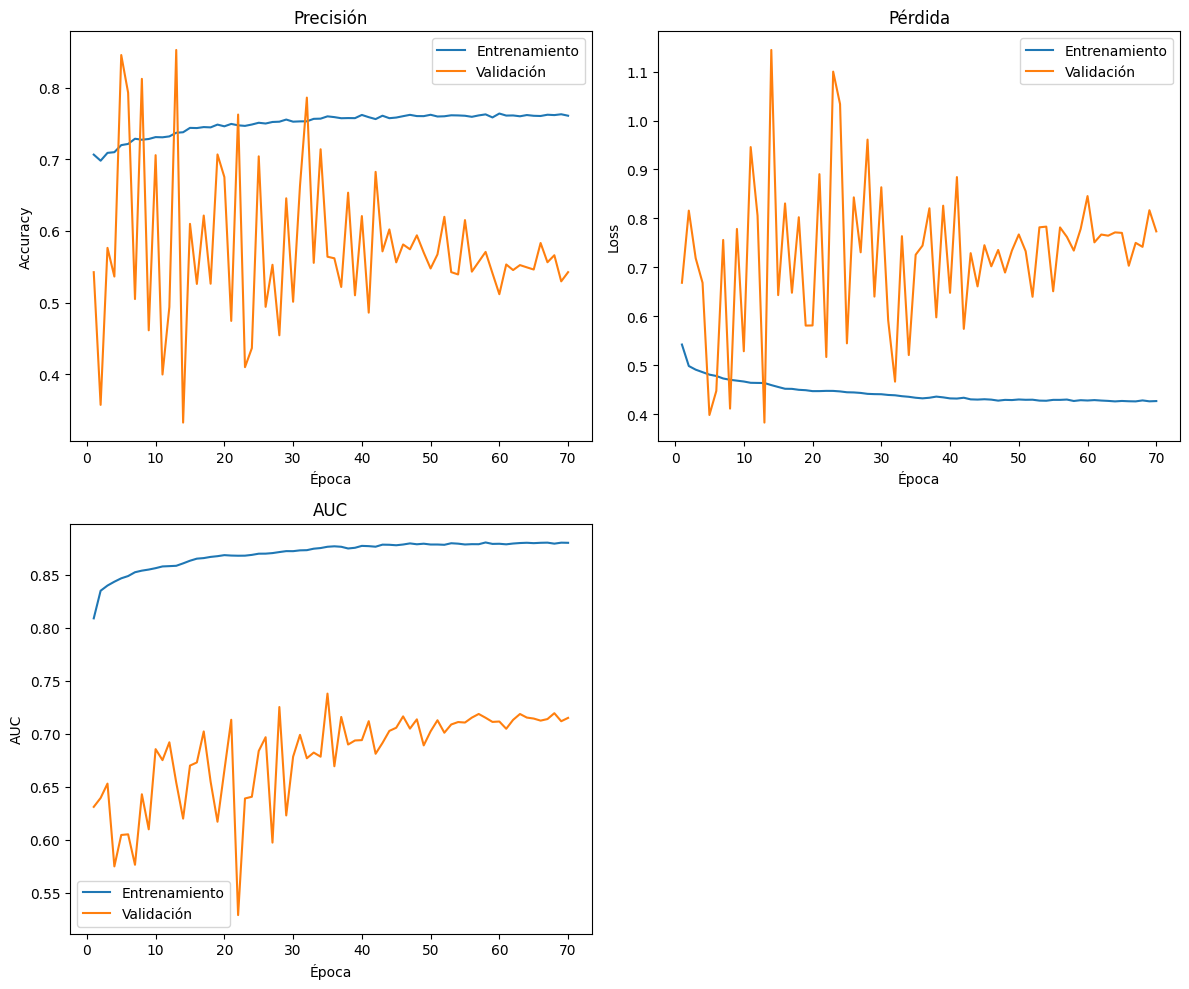

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1940/1940 [==============================] - 48s 23ms/step - loss: 0.5484 - accuracy: 0.6657 - precision: 0.9682 - recall: 0.6504 - auc: 0.7964 - val_loss: 0.7456 - val_accuracy: 0.4078 - val_precision: 0.9595 - val_recall: 0.3519 - val_auc: 0.6431 - lr: 5.0000e-04
Epoch 2/100
1940/1940 [==============================] - 43s 22ms/step - loss: 0.5097 - accuracy: 0.6856 - precision: 0.9727 - recall: 0.6700 - auc: 0.8217 - val_loss: 0.8439 - val_accuracy: 0.4226 - val_precision: 0.9777 - val_recall: 0.3618 - val_auc: 0.6973 - lr: 5.0000e-04
Epoch 3/100
1940/1940 [==============================] - 46s 23ms/step - loss: 0.4965 - accuracy: 0.7028 - precision: 0.9732 - recall: 0.6892 - auc: 0.8318 - val_loss: 0.9044 - val_accuracy: 0.4304 - val_precision: 0.9631 - val_recall: 0.3767 - val_auc: 0.6578 - lr: 5.0000e-04
Epoch 4/100
1940/1940 [==============================] - 42s 21ms/step - loss: 0.4899 - accuracy: 0.7024 - precision: 0.9742 - recall: 0.6880 - auc: 0.8364 - val_loss

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1940/1940 [==============================] - 39s 20ms/step - loss: 0.4527 - accuracy: 0.7450 - precision: 0.9762 - recall: 0.7350 - auc: 0.8617 - val_loss: 0.6207 - val_accuracy: 0.6349 - val_precision: 0.9558 - val_recall: 0.6199 - val_auc: 0.7483 - lr: 2.5000e-04
Epoch 27/100
1940/1940 [==============================] - 33s 17ms/step - loss: 0.4528 - accuracy: 0.7444 - precision: 0.9764 - recall: 0.7342 - auc: 0.8620 - val_loss: 0.5767 - val_accuracy: 0.6627 - val_precision: 0.9271 - val_recall: 0.6754 - val_auc: 0.6815 - lr: 2.5000e-04
Epoch 28/100
1940/1940 [==============================] - 34s 18ms/step - loss: 0.4509 - accuracy: 0.7424 - precision: 0.9765 - recall: 0.7318 - auc: 0.8630 - val_loss: 0.6670 - val_accuracy: 0.6180 - val_precision: 0.9369 - val_recall: 0.6136 - val_auc: 0.6838 - lr: 2.5000e-04
Epoch 29/100
1940/1940 [==============================] - 36s 18ms/step - loss: 0.4498 - accuracy: 0.7455 - precision: 0.9767 - recall: 0.7351 - auc: 0.8639 - val_loss: 0.5865 

ValueError: Found input variables with inconsistent numbers of samples: [31075, 32397]

507/507 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.45028877


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.37      0.89      0.53        57
           1       0.98      0.80      0.88       421

    accuracy                           0.81       478
   macro avg       0.68      0.85      0.70       478
weighted avg       0.91      0.81      0.84       478

AUC clase 1: 0.9156561236821269
F1: 0.8792650918635171

Accuracy: 0.8075313807531381

Precision: 0.9824046920821115

Recall: 0.7957244655581948

Confusion:
 [[ 51   6]
 [ 86 335]]


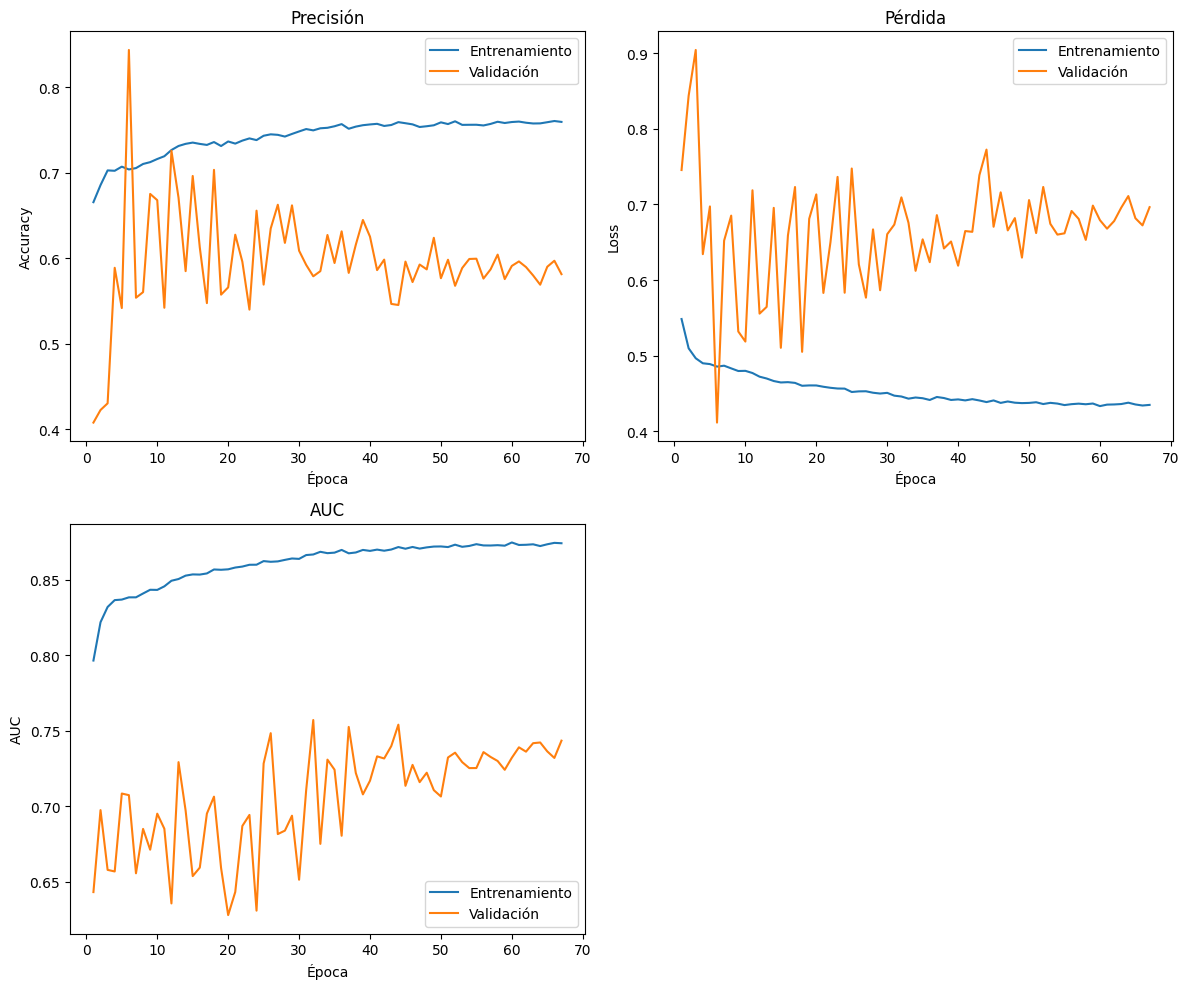

Umbral óptimo según Youden: 0.5668494


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.35      0.86      0.50        57
           1       0.98      0.79      0.87       421

    accuracy                           0.79       478
   macro avg       0.66      0.82      0.69       478
weighted avg       0.90      0.79      0.83       478

AUC clase 1: 0.9012793265824895
F1: 0.8710526315789474

Accuracy: 0.7949790794979079

Precision: 0.976401179941003

Recall: 0.7862232779097387

Confusion:
 [[ 49   8]
 [ 90 331]]


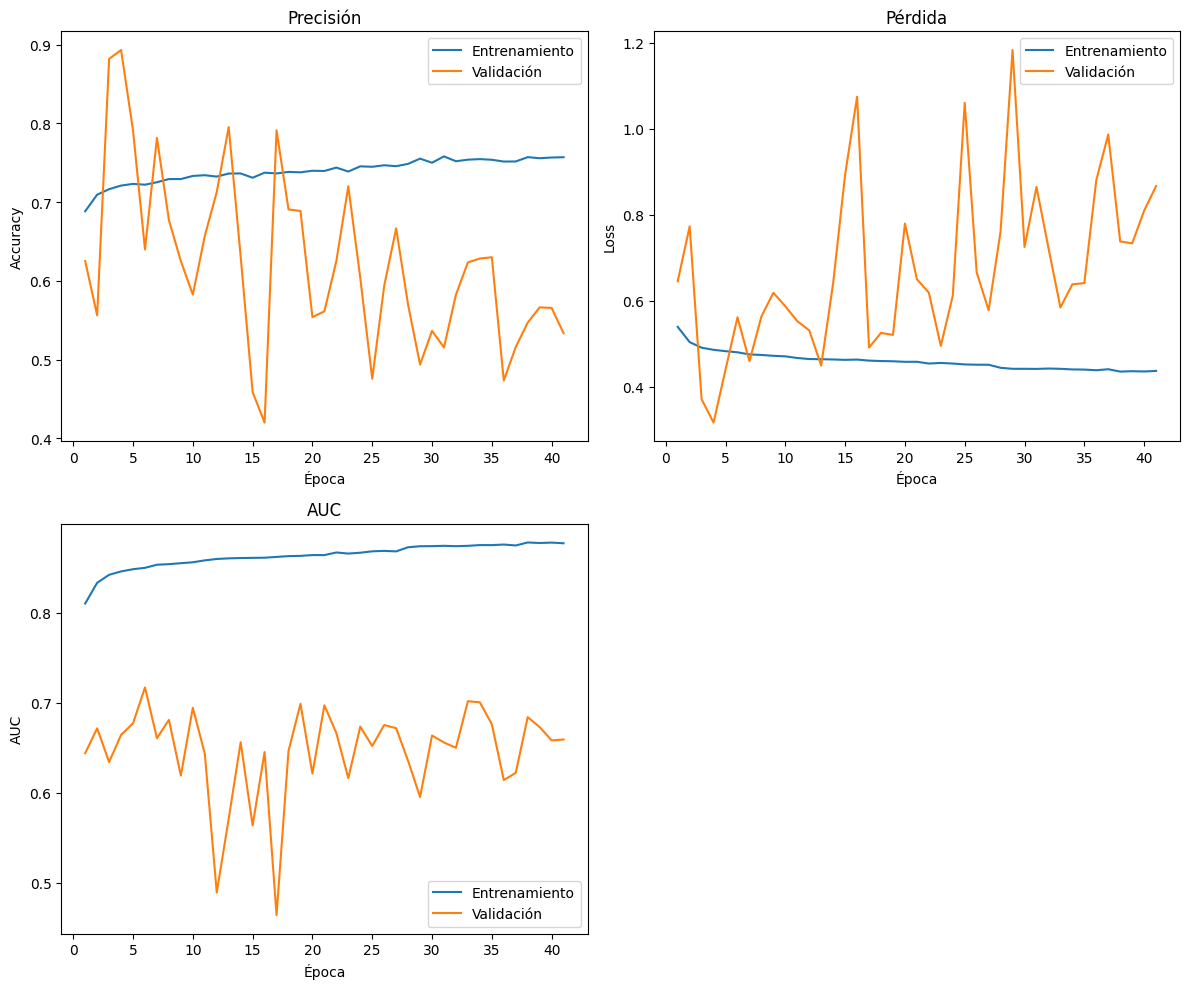

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1955/1955 [==============================] - 42s 20ms/step - loss: 0.5232 - accuracy: 0.7019 - precision: 0.9687 - recall: 0.6931 - auc: 0.8108 - val_loss: 0.7607 - val_accuracy: 0.5258 - val_precision: 0.9322 - val_recall: 0.4959 - val_auc: 0.6698 - lr: 5.0000e-04
Epoch 2/100
1955/1955 [==============================] - 32s 16ms/step - loss: 0.4898 - accuracy: 0.7158 - precision: 0.9724 - recall: 0.7060 - auc: 0.8308 - val_loss: 0.8908 - val_accuracy: 0.3871 - val_precision: 0.9640 - val_recall: 0.3136 - val_auc: 0.6742 - lr: 5.0000e-04
Epoch 3/100
1955/1955 [==============================] - 34s 17ms/step - loss: 0.4843 - accuracy: 0.7194 - precision: 0.9734 - recall: 0.7093 - auc: 0.8350 - val_loss: 0.5786 - val_accuracy: 0.7060 - val_precision: 0.9032 - val_recall: 0.7450 - val_auc: 0.6471 - lr: 5.0000e-04
Epoch 4/100
1955/1955 [==============================] - 35s 18ms/step - loss: 0.4793 - accuracy: 0.7303 - precision: 0.9715 - recall: 0.7233 - auc: 0.8389 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.44      0.77      0.56        57
           1       0.97      0.87      0.91       421

    accuracy                           0.86       478
   macro avg       0.70      0.82      0.74       478
weighted avg       0.90      0.86      0.87       478

AUC clase 1: 0.921073467516773
F1: 0.9136420525657072

Accuracy: 0.8556485355648535

Precision: 0.9656084656084656

Recall: 0.8669833729216152

Confusion:
 [[ 44  13]
 [ 56 365]]


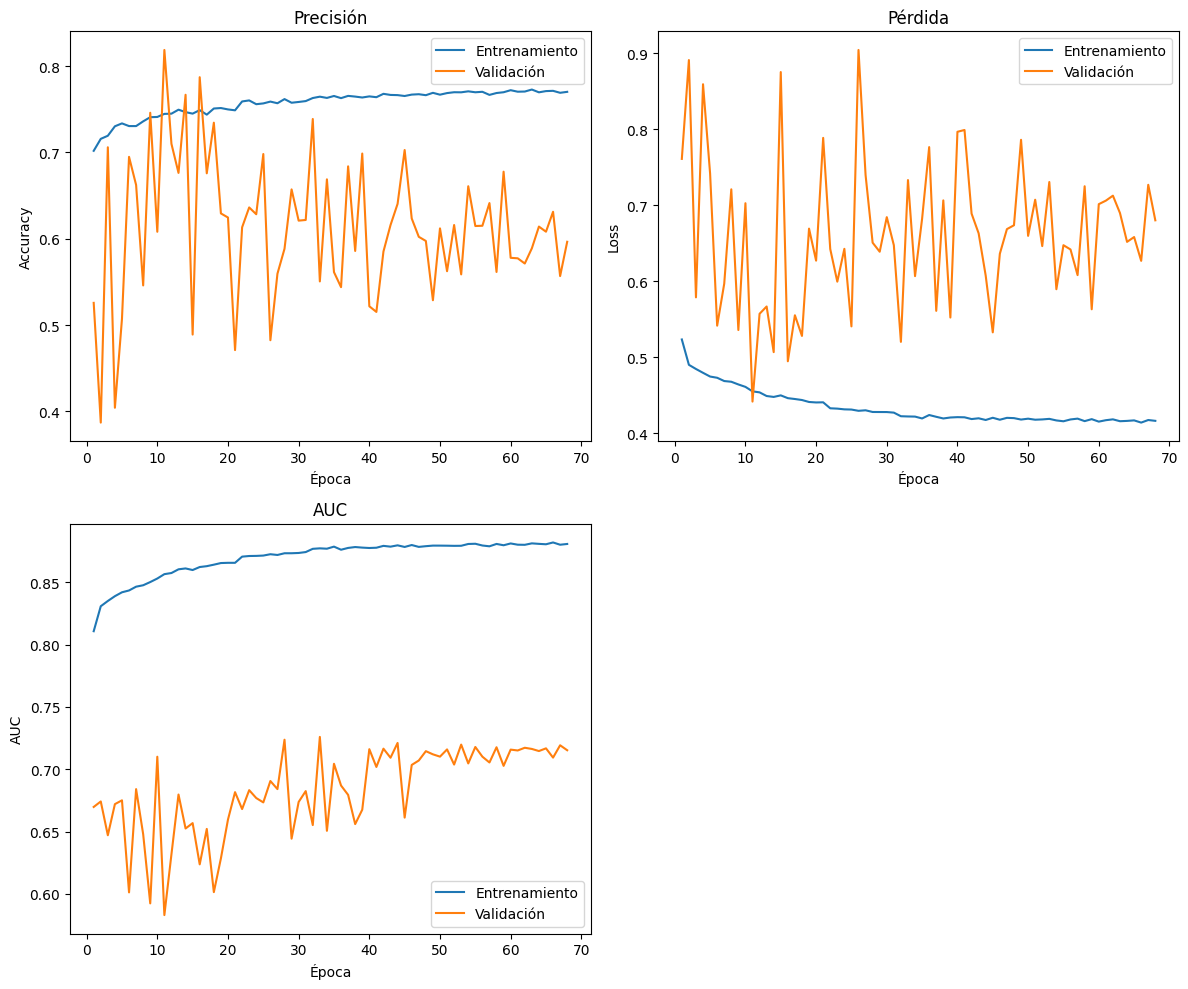

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100
1964/1964 [==============================] - 37s 18ms/step - loss: 0.5370 - accuracy: 0.6832 - precision: 0.9696 - recall: 0.6670 - auc: 0.8148 - val_loss: 0.3782 - val_accuracy: 0.8493 - val_precision: 0.9268 - val_recall: 0.9074 - val_auc: 0.7033 - lr: 5.0000e-04
Epoch 2/100
1964/1964 [==============================] - 33s 17ms/step - loss: 0.5030 - accuracy: 0.6940 - precision: 0.9743 - recall: 0.6761 - auc: 0.8353 - val_loss: 0.6778 - val_accuracy: 0.5158 - val_precision: 0.9614 - val_recall: 0.4921 - val_auc: 0.6884 - lr: 5.0000e-04
Epoch 3/100
1964/1964 [==============================] - 36s 18ms/step - loss: 0.4982 - accuracy: 0.6925 - precision: 0.9744 - recall: 0.6742 - auc: 0.8376 - val_loss: 0.9723 - val_accuracy: 0.3228 - val_precision: 0.9896 - val_recall: 0.2648 - val_auc: 0.6723 - lr: 5.0000e-04
Epoch 4/100
1964/1964 [==============================] - 35s 18ms/step - loss: 0.4939 - accuracy: 0.6966 - precision: 0.9750 - recall: 0.6785 - auc: 0.8403 - val_loss

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.36      0.91      0.51        57
           1       0.98      0.78      0.87       421

    accuracy                           0.79       478
   macro avg       0.67      0.84      0.69       478
weighted avg       0.91      0.79      0.83       478

AUC clase 1: 0.9204483893820061
F1: 0.8685258964143426

Accuracy: 0.7928870292887029

Precision: 0.9849397590361446

Recall: 0.7767220902612827

Confusion:
 [[ 52   5]
 [ 94 327]]


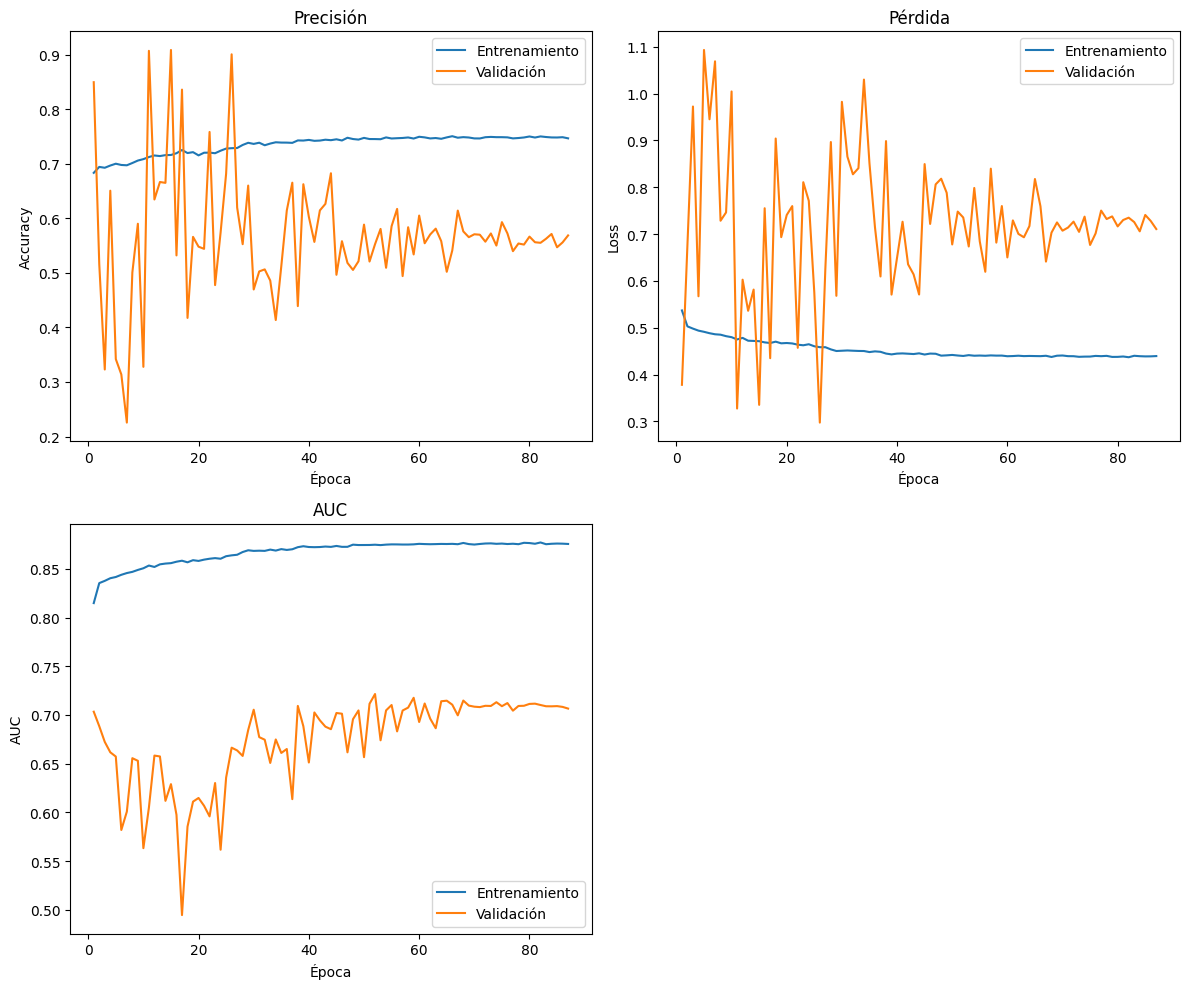

In [66]:
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    model = DeepGNN(16,32,64,50) # Podria cogerse cualquier dataset de los folds
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    print("----Training metrics------")
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
              validation_data=val_loader.load(),validation_steps=val_loader.steps_per_epoch, epochs=100,callbacks=[checkpoint_cb, early_stopping, reduce_lr])
    

    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, test_cb.history, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, val_auc, label='Validación')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1

**Graficas de test**

In [35]:
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    model = DeepGNN(16,32,64,50) # Podria cogerse cualquier dataset de los folds
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    print("----Training metrics------")
    test_cb = TestSetCallback(val_loader,test_loader, val_labels[i], Y_coded, test_indices)
    callbacks = [checkpoint_cb, early_stopping, reduce_lr,test_cb]
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
              validation_data=val_loader.load(),validation_steps=val_loader.steps_per_epoch, epochs=100,callbacks=[checkpoint_cb, early_stopping, reduce_lr,test_cb])
    

    tr_acc = history.history['accuracy']
    tr_auc = history.history['auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, test_cb.test_history["accuracy"], label='Test')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()


    # AUC
    plt.subplot(2, 2, 2)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, test_cb.test_history["auc"], label='Test')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1

----Training metrics------
Epoch 1/100
482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.44648963


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 53s 26ms/step - loss: 0.5414 - accuracy: 0.6831 - precision: 0.9703 - recall: 0.6677 - auc: 0.8124 - val_loss: 0.7157 - val_accuracy: 0.4753 - val_precision: 0.9466 - val_recall: 0.4450 - val_auc: 0.6333 - lr: 5.0000e-04
Epoch 2/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.71215796


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 50s 25ms/step - loss: 0.5007 - accuracy: 0.7124 - precision: 0.9722 - recall: 0.6999 - auc: 0.8334 - val_loss: 0.6726 - val_accuracy: 0.5280 - val_precision: 0.9439 - val_recall: 0.5084 - val_auc: 0.6701 - lr: 5.0000e-04
Epoch 3/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.50146085


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 48s 24ms/step - loss: 0.4904 - accuracy: 0.7124 - precision: 0.9741 - recall: 0.6984 - auc: 0.8401 - val_loss: 0.8850 - val_accuracy: 0.4400 - val_precision: 0.9694 - val_recall: 0.3933 - val_auc: 0.6668 - lr: 5.0000e-04
Epoch 4/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.60647947


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 50s 25ms/step - loss: 0.4854 - accuracy: 0.7175 - precision: 0.9743 - recall: 0.7041 - auc: 0.8436 - val_loss: 0.6241 - val_accuracy: 0.5907 - val_precision: 0.9292 - val_recall: 0.5926 - val_auc: 0.6036 - lr: 5.0000e-04
Epoch 5/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.46833915


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 51s 26ms/step - loss: 0.4803 - accuracy: 0.7200 - precision: 0.9751 - recall: 0.7064 - auc: 0.8468 - val_loss: 0.9043 - val_accuracy: 0.3973 - val_precision: 0.9502 - val_recall: 0.3520 - val_auc: 0.6032 - lr: 5.0000e-04
Epoch 6/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.74014527


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 50s 25ms/step - loss: 0.4748 - accuracy: 0.7247 - precision: 0.9748 - recall: 0.7119 - auc: 0.8507 - val_loss: 0.6752 - val_accuracy: 0.5887 - val_precision: 0.9280 - val_recall: 0.5911 - val_auc: 0.6284 - lr: 5.0000e-04
Epoch 7/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.6922161


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 51s 26ms/step - loss: 0.4720 - accuracy: 0.7281 - precision: 0.9755 - recall: 0.7153 - auc: 0.8526 - val_loss: 0.6217 - val_accuracy: 0.6195 - val_precision: 0.9104 - val_recall: 0.6425 - val_auc: 0.5570 - lr: 5.0000e-04
Epoch 8/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.78206086


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 50s 25ms/step - loss: 0.4686 - accuracy: 0.7308 - precision: 0.9755 - recall: 0.7185 - auc: 0.8550 - val_loss: 0.5049 - val_accuracy: 0.7192 - val_precision: 0.9331 - val_recall: 0.7428 - val_auc: 0.6984 - lr: 5.0000e-04
Epoch 9/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.8267224


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 50s 25ms/step - loss: 0.4661 - accuracy: 0.7351 - precision: 0.9757 - recall: 0.7232 - auc: 0.8565 - val_loss: 0.8474 - val_accuracy: 0.4950 - val_precision: 0.9272 - val_recall: 0.4793 - val_auc: 0.5858 - lr: 5.0000e-04
Epoch 10/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.99887925


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 52s 26ms/step - loss: 0.4621 - accuracy: 0.7391 - precision: 0.9751 - recall: 0.7282 - auc: 0.8587 - val_loss: 0.4823 - val_accuracy: 0.9044 - val_precision: 0.9046 - val_recall: 0.9998 - val_auc: 0.4953 - lr: 5.0000e-04
Epoch 11/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.75981057


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 51s 26ms/step - loss: 0.4620 - accuracy: 0.7402 - precision: 0.9755 - recall: 0.7292 - auc: 0.8595 - val_loss: 1.0958 - val_accuracy: 0.4489 - val_precision: 0.9583 - val_recall: 0.4084 - val_auc: 0.6539 - lr: 5.0000e-04
Epoch 12/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.8270243


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 48s 24ms/step - loss: 0.4589 - accuracy: 0.7399 - precision: 0.9763 - recall: 0.7282 - auc: 0.8611 - val_loss: 0.5280 - val_accuracy: 0.7077 - val_precision: 0.9317 - val_recall: 0.7304 - val_auc: 0.6956 - lr: 5.0000e-04
Epoch 13/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.94443506


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 45s 23ms/step - loss: 0.4574 - accuracy: 0.7410 - precision: 0.9760 - recall: 0.7297 - auc: 0.8619 - val_loss: 0.5136 - val_accuracy: 0.7534 - val_precision: 0.9242 - val_recall: 0.7924 - val_auc: 0.6897 - lr: 5.0000e-04
Epoch 14/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.8612707


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 45s 23ms/step - loss: 0.4572 - accuracy: 0.7424 - precision: 0.9765 - recall: 0.7308 - auc: 0.8629 - val_loss: 0.4489 - val_accuracy: 0.7799 - val_precision: 0.9195 - val_recall: 0.8292 - val_auc: 0.6476 - lr: 5.0000e-04
Epoch 15/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.6158363


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 46s 23ms/step - loss: 0.4568 - accuracy: 0.7429 - precision: 0.9760 - recall: 0.7319 - auc: 0.8627 - val_loss: 0.8371 - val_accuracy: 0.4499 - val_precision: 0.9559 - val_recall: 0.4108 - val_auc: 0.6313 - lr: 5.0000e-04
Epoch 16/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.9806892


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 45s 23ms/step - loss: 0.4553 - accuracy: 0.7460 - precision: 0.9753 - recall: 0.7359 - auc: 0.8638 - val_loss: 0.5015 - val_accuracy: 0.8145 - val_precision: 0.9084 - val_recall: 0.8841 - val_auc: 0.5887 - lr: 5.0000e-04
Epoch 17/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 2s 3ms/step
Umbral óptimo según Youden: 0.85969734


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 48s 24ms/step - loss: 0.4511 - accuracy: 0.7499 - precision: 0.9765 - recall: 0.7394 - auc: 0.8664 - val_loss: 0.6160 - val_accuracy: 0.6447 - val_precision: 0.9180 - val_recall: 0.6667 - val_auc: 0.5953 - lr: 5.0000e-04
Epoch 18/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5516648


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4523 - accuracy: 0.7455 - precision: 0.9763 - recall: 0.7345 - auc: 0.8653 - val_loss: 1.0983 - val_accuracy: 0.3737 - val_precision: 0.9544 - val_recall: 0.3229 - val_auc: 0.6122 - lr: 5.0000e-04
Epoch 19/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.9416061


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4520 - accuracy: 0.7487 - precision: 0.9758 - recall: 0.7386 - auc: 0.8656 - val_loss: 0.5480 - val_accuracy: 0.7150 - val_precision: 0.9167 - val_recall: 0.7534 - val_auc: 0.6184 - lr: 5.0000e-04
Epoch 20/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.8541551


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4533 - accuracy: 0.7482 - precision: 0.9758 - recall: 0.7380 - auc: 0.8652 - val_loss: 0.7124 - val_accuracy: 0.5722 - val_precision: 0.9174 - val_recall: 0.5791 - val_auc: 0.5846 - lr: 5.0000e-04
Epoch 21/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.8683443


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4455 - accuracy: 0.7559 - precision: 0.9761 - recall: 0.7466 - auc: 0.8692 - val_loss: 0.5720 - val_accuracy: 0.6808 - val_precision: 0.9233 - val_recall: 0.7057 - val_auc: 0.6467 - lr: 2.5000e-04
Epoch 22/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.763813


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4426 - accuracy: 0.7563 - precision: 0.9763 - recall: 0.7468 - auc: 0.8714 - val_loss: 0.6826 - val_accuracy: 0.6207 - val_precision: 0.9289 - val_recall: 0.6288 - val_auc: 0.6293 - lr: 2.5000e-04
Epoch 23/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.7997041


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4435 - accuracy: 0.7556 - precision: 0.9768 - recall: 0.7456 - auc: 0.8708 - val_loss: 0.4874 - val_accuracy: 0.7786 - val_precision: 0.9169 - val_recall: 0.8305 - val_auc: 0.6093 - lr: 2.5000e-04
Epoch 24/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.57220316


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4420 - accuracy: 0.7491 - precision: 0.9775 - recall: 0.7377 - auc: 0.8717 - val_loss: 0.7395 - val_accuracy: 0.5270 - val_precision: 0.9464 - val_recall: 0.5057 - val_auc: 0.6605 - lr: 2.5000e-04
Epoch 25/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.9718231


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4416 - accuracy: 0.7513 - precision: 0.9773 - recall: 0.7404 - auc: 0.8721 - val_loss: 0.4254 - val_accuracy: 0.8047 - val_precision: 0.9168 - val_recall: 0.8623 - val_auc: 0.6527 - lr: 2.5000e-04
Epoch 26/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.65749645


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 17ms/step - loss: 0.4398 - accuracy: 0.7537 - precision: 0.9774 - recall: 0.7430 - auc: 0.8732 - val_loss: 0.6206 - val_accuracy: 0.6276 - val_precision: 0.9356 - val_recall: 0.6317 - val_auc: 0.6806 - lr: 2.5000e-04
Epoch 27/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.37510958


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4426 - accuracy: 0.7513 - precision: 0.9771 - recall: 0.7405 - auc: 0.8714 - val_loss: 0.8957 - val_accuracy: 0.4482 - val_precision: 0.9755 - val_recall: 0.3999 - val_auc: 0.7032 - lr: 2.5000e-04
Epoch 28/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.7331072


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4428 - accuracy: 0.7530 - precision: 0.9769 - recall: 0.7426 - auc: 0.8717 - val_loss: 0.7623 - val_accuracy: 0.5359 - val_precision: 0.9309 - val_recall: 0.5259 - val_auc: 0.6083 - lr: 2.5000e-04
Epoch 29/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.70097435


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4396 - accuracy: 0.7569 - precision: 0.9774 - recall: 0.7467 - auc: 0.8732 - val_loss: 0.5866 - val_accuracy: 0.6676 - val_precision: 0.9307 - val_recall: 0.6833 - val_auc: 0.6587 - lr: 2.5000e-04
Epoch 30/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.627615


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4408 - accuracy: 0.7532 - precision: 0.9778 - recall: 0.7422 - auc: 0.8729 - val_loss: 0.6900 - val_accuracy: 0.5675 - val_precision: 0.9502 - val_recall: 0.5507 - val_auc: 0.6952 - lr: 2.5000e-04
Epoch 31/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.52168


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4356 - accuracy: 0.7564 - precision: 0.9775 - recall: 0.7461 - auc: 0.8758 - val_loss: 0.6880 - val_accuracy: 0.5736 - val_precision: 0.9539 - val_recall: 0.5555 - val_auc: 0.6966 - lr: 1.2500e-04
Epoch 32/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.37230897


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4354 - accuracy: 0.7559 - precision: 0.9773 - recall: 0.7456 - auc: 0.8758 - val_loss: 0.8526 - val_accuracy: 0.4725 - val_precision: 0.9704 - val_recall: 0.4299 - val_auc: 0.7102 - lr: 1.2500e-04
Epoch 33/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5662037


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4362 - accuracy: 0.7566 - precision: 0.9779 - recall: 0.7460 - auc: 0.8753 - val_loss: 0.6410 - val_accuracy: 0.6188 - val_precision: 0.9505 - val_recall: 0.6103 - val_auc: 0.7077 - lr: 1.2500e-04
Epoch 34/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5609592


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4369 - accuracy: 0.7576 - precision: 0.9778 - recall: 0.7471 - auc: 0.8748 - val_loss: 0.7022 - val_accuracy: 0.5833 - val_precision: 0.9546 - val_recall: 0.5662 - val_auc: 0.7025 - lr: 1.2500e-04
Epoch 35/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.46678862


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4342 - accuracy: 0.7593 - precision: 0.9777 - recall: 0.7492 - auc: 0.8762 - val_loss: 0.8026 - val_accuracy: 0.5042 - val_precision: 0.9663 - val_recall: 0.4681 - val_auc: 0.7096 - lr: 1.2500e-04
Epoch 36/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.64547944


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4374 - accuracy: 0.7571 - precision: 0.9775 - recall: 0.7468 - auc: 0.8750 - val_loss: 0.9126 - val_accuracy: 0.5481 - val_precision: 0.9467 - val_recall: 0.5303 - val_auc: 0.6539 - lr: 1.2500e-04
Epoch 37/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.48384598


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 33s 17ms/step - loss: 0.4342 - accuracy: 0.7573 - precision: 0.9782 - recall: 0.7465 - auc: 0.8764 - val_loss: 0.8074 - val_accuracy: 0.5243 - val_precision: 0.9598 - val_recall: 0.4947 - val_auc: 0.6927 - lr: 1.2500e-04
Epoch 38/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.5780414


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 38s 19ms/step - loss: 0.4360 - accuracy: 0.7569 - precision: 0.9780 - recall: 0.7462 - auc: 0.8755 - val_loss: 0.7285 - val_accuracy: 0.5687 - val_precision: 0.9511 - val_recall: 0.5515 - val_auc: 0.6839 - lr: 1.2500e-04
Epoch 39/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.72290176


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 38s 19ms/step - loss: 0.4347 - accuracy: 0.7593 - precision: 0.9780 - recall: 0.7490 - auc: 0.8763 - val_loss: 0.6590 - val_accuracy: 0.6112 - val_precision: 0.9362 - val_recall: 0.6118 - val_auc: 0.6614 - lr: 1.2500e-04
Epoch 40/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.70355666


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4335 - accuracy: 0.7611 - precision: 0.9782 - recall: 0.7508 - auc: 0.8771 - val_loss: 0.6584 - val_accuracy: 0.6305 - val_precision: 0.9389 - val_recall: 0.6326 - val_auc: 0.6753 - lr: 1.2500e-04
Epoch 41/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.565529


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4326 - accuracy: 0.7617 - precision: 0.9782 - recall: 0.7515 - auc: 0.8774 - val_loss: 0.7004 - val_accuracy: 0.5805 - val_precision: 0.9569 - val_recall: 0.5614 - val_auc: 0.7126 - lr: 6.2500e-05
Epoch 42/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5230668


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4330 - accuracy: 0.7597 - precision: 0.9780 - recall: 0.7494 - auc: 0.8774 - val_loss: 0.6844 - val_accuracy: 0.6006 - val_precision: 0.9557 - val_recall: 0.5855 - val_auc: 0.7130 - lr: 6.2500e-05
Epoch 43/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.58833563


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 40s 20ms/step - loss: 0.4311 - accuracy: 0.7639 - precision: 0.9778 - recall: 0.7544 - auc: 0.8781 - val_loss: 0.7187 - val_accuracy: 0.5713 - val_precision: 0.9558 - val_recall: 0.5515 - val_auc: 0.7033 - lr: 6.2500e-05
Epoch 44/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.5898393


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4305 - accuracy: 0.7630 - precision: 0.9783 - recall: 0.7529 - auc: 0.8784 - val_loss: 0.7003 - val_accuracy: 0.5784 - val_precision: 0.9525 - val_recall: 0.5619 - val_auc: 0.6978 - lr: 6.2500e-05
Epoch 45/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.414266


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 38s 19ms/step - loss: 0.4319 - accuracy: 0.7612 - precision: 0.9781 - recall: 0.7511 - auc: 0.8774 - val_loss: 0.8385 - val_accuracy: 0.4910 - val_precision: 0.9701 - val_recall: 0.4511 - val_auc: 0.7119 - lr: 6.2500e-05
Epoch 46/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5346732


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 38s 19ms/step - loss: 0.4318 - accuracy: 0.7601 - precision: 0.9781 - recall: 0.7498 - auc: 0.8778 - val_loss: 0.7072 - val_accuracy: 0.5735 - val_precision: 0.9601 - val_recall: 0.5513 - val_auc: 0.7184 - lr: 6.2500e-05
Epoch 47/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.69132274


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4323 - accuracy: 0.7585 - precision: 0.9784 - recall: 0.7477 - auc: 0.8776 - val_loss: 0.6421 - val_accuracy: 0.6393 - val_precision: 0.9424 - val_recall: 0.6403 - val_auc: 0.6928 - lr: 6.2500e-05
Epoch 48/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.411229


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4315 - accuracy: 0.7608 - precision: 0.9778 - recall: 0.7509 - auc: 0.8778 - val_loss: 0.8308 - val_accuracy: 0.5058 - val_precision: 0.9698 - val_recall: 0.4681 - val_auc: 0.7208 - lr: 6.2500e-05
Epoch 49/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.5356243


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4320 - accuracy: 0.7600 - precision: 0.9784 - recall: 0.7495 - auc: 0.8777 - val_loss: 0.7805 - val_accuracy: 0.5233 - val_precision: 0.9597 - val_recall: 0.4937 - val_auc: 0.7003 - lr: 6.2500e-05
Epoch 50/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.52501637


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 38s 19ms/step - loss: 0.4321 - accuracy: 0.7616 - precision: 0.9780 - recall: 0.7516 - auc: 0.8777 - val_loss: 0.7297 - val_accuracy: 0.5683 - val_precision: 0.9553 - val_recall: 0.5484 - val_auc: 0.6969 - lr: 6.2500e-05
Epoch 51/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.55120564


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4291 - accuracy: 0.7602 - precision: 0.9781 - recall: 0.7499 - auc: 0.8791 - val_loss: 0.7403 - val_accuracy: 0.5616 - val_precision: 0.9609 - val_recall: 0.5371 - val_auc: 0.7191 - lr: 3.1250e-05
Epoch 52/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.50942004


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4312 - accuracy: 0.7614 - precision: 0.9778 - recall: 0.7515 - auc: 0.8784 - val_loss: 0.7555 - val_accuracy: 0.5583 - val_precision: 0.9652 - val_recall: 0.5308 - val_auc: 0.7223 - lr: 3.1250e-05
Epoch 53/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.53349316


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4318 - accuracy: 0.7621 - precision: 0.9781 - recall: 0.7520 - auc: 0.8779 - val_loss: 0.7332 - val_accuracy: 0.5535 - val_precision: 0.9628 - val_recall: 0.5267 - val_auc: 0.7197 - lr: 3.1250e-05
Epoch 54/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5101262


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4310 - accuracy: 0.7617 - precision: 0.9781 - recall: 0.7517 - auc: 0.8782 - val_loss: 0.7221 - val_accuracy: 0.5687 - val_precision: 0.9614 - val_recall: 0.5451 - val_auc: 0.7191 - lr: 3.1250e-05
Epoch 55/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5201245


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4314 - accuracy: 0.7598 - precision: 0.9779 - recall: 0.7496 - auc: 0.8777 - val_loss: 0.7260 - val_accuracy: 0.5726 - val_precision: 0.9629 - val_recall: 0.5486 - val_auc: 0.7199 - lr: 3.1250e-05
Epoch 56/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.46301717


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 17ms/step - loss: 0.4296 - accuracy: 0.7617 - precision: 0.9786 - recall: 0.7511 - auc: 0.8789 - val_loss: 0.7547 - val_accuracy: 0.5509 - val_precision: 0.9646 - val_recall: 0.5226 - val_auc: 0.7193 - lr: 3.1250e-05
Epoch 57/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5473273


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4316 - accuracy: 0.7626 - precision: 0.9776 - recall: 0.7530 - auc: 0.8781 - val_loss: 0.7265 - val_accuracy: 0.5659 - val_precision: 0.9627 - val_recall: 0.5410 - val_auc: 0.7202 - lr: 3.1250e-05
Epoch 58/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.520002


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4297 - accuracy: 0.7612 - precision: 0.9786 - recall: 0.7506 - auc: 0.8789 - val_loss: 0.7559 - val_accuracy: 0.5448 - val_precision: 0.9653 - val_recall: 0.5153 - val_auc: 0.7208 - lr: 3.1250e-05
Epoch 59/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.54687047


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4308 - accuracy: 0.7605 - precision: 0.9778 - recall: 0.7505 - auc: 0.8785 - val_loss: 0.6816 - val_accuracy: 0.5880 - val_precision: 0.9548 - val_recall: 0.5715 - val_auc: 0.7116 - lr: 3.1250e-05
Epoch 60/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.51762086


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4304 - accuracy: 0.7606 - precision: 0.9779 - recall: 0.7505 - auc: 0.8785 - val_loss: 0.7572 - val_accuracy: 0.5478 - val_precision: 0.9665 - val_recall: 0.5180 - val_auc: 0.7236 - lr: 3.1250e-05
Epoch 61/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.55752766


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4296 - accuracy: 0.7591 - precision: 0.9782 - recall: 0.7485 - auc: 0.8788 - val_loss: 0.7170 - val_accuracy: 0.5742 - val_precision: 0.9601 - val_recall: 0.5521 - val_auc: 0.7172 - lr: 1.5625e-05
Epoch 62/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5457485


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4288 - accuracy: 0.7610 - precision: 0.9788 - recall: 0.7502 - auc: 0.8794 - val_loss: 0.7159 - val_accuracy: 0.5776 - val_precision: 0.9601 - val_recall: 0.5561 - val_auc: 0.7188 - lr: 1.5625e-05
Epoch 63/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5219485


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4286 - accuracy: 0.7619 - precision: 0.9788 - recall: 0.7513 - auc: 0.8793 - val_loss: 0.6921 - val_accuracy: 0.5888 - val_precision: 0.9574 - val_recall: 0.5708 - val_auc: 0.7115 - lr: 1.5625e-05
Epoch 64/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5317758


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4290 - accuracy: 0.7627 - precision: 0.9784 - recall: 0.7525 - auc: 0.8793 - val_loss: 0.7094 - val_accuracy: 0.5794 - val_precision: 0.9595 - val_recall: 0.5585 - val_auc: 0.7170 - lr: 1.5625e-05
Epoch 65/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.5299513


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4286 - accuracy: 0.7611 - precision: 0.9783 - recall: 0.7508 - auc: 0.8796 - val_loss: 0.7417 - val_accuracy: 0.5574 - val_precision: 0.9635 - val_recall: 0.5307 - val_auc: 0.7201 - lr: 1.5625e-05
Epoch 66/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.54497033


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4293 - accuracy: 0.7608 - precision: 0.9787 - recall: 0.7501 - auc: 0.8793 - val_loss: 0.7146 - val_accuracy: 0.5731 - val_precision: 0.9603 - val_recall: 0.5507 - val_auc: 0.7160 - lr: 1.5625e-05
Epoch 67/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.55378157


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4296 - accuracy: 0.7614 - precision: 0.9778 - recall: 0.7515 - auc: 0.8789 - val_loss: 0.7199 - val_accuracy: 0.5754 - val_precision: 0.9601 - val_recall: 0.5536 - val_auc: 0.7170 - lr: 1.5625e-05
Epoch 68/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.539256


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 32s 16ms/step - loss: 0.4287 - accuracy: 0.7622 - precision: 0.9783 - recall: 0.7521 - auc: 0.8792 - val_loss: 0.7434 - val_accuracy: 0.5578 - val_precision: 0.9633 - val_recall: 0.5313 - val_auc: 0.7217 - lr: 1.5625e-05
Epoch 69/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.51213646


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 31s 16ms/step - loss: 0.4299 - accuracy: 0.7620 - precision: 0.9788 - recall: 0.7514 - auc: 0.8793 - val_loss: 0.7327 - val_accuracy: 0.5663 - val_precision: 0.9625 - val_recall: 0.5416 - val_auc: 0.7217 - lr: 1.5625e-05
Epoch 70/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5158005


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 31s 16ms/step - loss: 0.4303 - accuracy: 0.7633 - precision: 0.9787 - recall: 0.7529 - auc: 0.8789 - val_loss: 0.7304 - val_accuracy: 0.5663 - val_precision: 0.9611 - val_recall: 0.5425 - val_auc: 0.7168 - lr: 1.5625e-05
Epoch 71/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5497046


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4278 - accuracy: 0.7625 - precision: 0.9787 - recall: 0.7520 - auc: 0.8798 - val_loss: 0.7442 - val_accuracy: 0.5573 - val_precision: 0.9642 - val_recall: 0.5302 - val_auc: 0.7210 - lr: 7.8125e-06
Epoch 72/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5405058


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 33s 17ms/step - loss: 0.4314 - accuracy: 0.7610 - precision: 0.9783 - recall: 0.7506 - auc: 0.8781 - val_loss: 0.7333 - val_accuracy: 0.5654 - val_precision: 0.9620 - val_recall: 0.5408 - val_auc: 0.7187 - lr: 7.8125e-06
Epoch 73/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5438611


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 32s 16ms/step - loss: 0.4297 - accuracy: 0.7612 - precision: 0.9782 - recall: 0.7509 - auc: 0.8788 - val_loss: 0.7159 - val_accuracy: 0.5734 - val_precision: 0.9593 - val_recall: 0.5517 - val_auc: 0.7134 - lr: 7.8125e-06
Epoch 74/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.54117405


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4284 - accuracy: 0.7620 - precision: 0.9789 - recall: 0.7513 - auc: 0.8797 - val_loss: 0.7126 - val_accuracy: 0.5760 - val_precision: 0.9593 - val_recall: 0.5548 - val_auc: 0.7162 - lr: 7.8125e-06
Epoch 75/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.54335785


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4296 - accuracy: 0.7621 - precision: 0.9787 - recall: 0.7515 - auc: 0.8793 - val_loss: 0.7120 - val_accuracy: 0.5783 - val_precision: 0.9592 - val_recall: 0.5575 - val_auc: 0.7145 - lr: 7.8125e-06
Epoch 76/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.5237384


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4298 - accuracy: 0.7633 - precision: 0.9781 - recall: 0.7534 - auc: 0.8793 - val_loss: 0.7177 - val_accuracy: 0.5748 - val_precision: 0.9591 - val_recall: 0.5536 - val_auc: 0.7161 - lr: 7.8125e-06
Epoch 77/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.55607766


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4289 - accuracy: 0.7625 - precision: 0.9786 - recall: 0.7521 - auc: 0.8797 - val_loss: 0.7137 - val_accuracy: 0.5762 - val_precision: 0.9591 - val_recall: 0.5551 - val_auc: 0.7142 - lr: 7.8125e-06
Epoch 78/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5154869


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4287 - accuracy: 0.7624 - precision: 0.9782 - recall: 0.7522 - auc: 0.8796 - val_loss: 0.7401 - val_accuracy: 0.5614 - val_precision: 0.9625 - val_recall: 0.5360 - val_auc: 0.7204 - lr: 7.8125e-06
Epoch 79/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5145077


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 17ms/step - loss: 0.4304 - accuracy: 0.7609 - precision: 0.9781 - recall: 0.7506 - auc: 0.8786 - val_loss: 0.7429 - val_accuracy: 0.5602 - val_precision: 0.9624 - val_recall: 0.5346 - val_auc: 0.7197 - lr: 7.8125e-06
Epoch 80/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5439973


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 33s 16ms/step - loss: 0.4285 - accuracy: 0.7637 - precision: 0.9788 - recall: 0.7533 - auc: 0.8797 - val_loss: 0.7272 - val_accuracy: 0.5688 - val_precision: 0.9612 - val_recall: 0.5452 - val_auc: 0.7180 - lr: 7.8125e-06
Epoch 81/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5399405


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 17ms/step - loss: 0.4280 - accuracy: 0.7629 - precision: 0.9784 - recall: 0.7527 - auc: 0.8798 - val_loss: 0.7293 - val_accuracy: 0.5689 - val_precision: 0.9604 - val_recall: 0.5458 - val_auc: 0.7168 - lr: 3.9063e-06
Epoch 82/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.55128896


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 37s 19ms/step - loss: 0.4272 - accuracy: 0.7628 - precision: 0.9782 - recall: 0.7527 - auc: 0.8800 - val_loss: 0.7314 - val_accuracy: 0.5668 - val_precision: 0.9614 - val_recall: 0.5429 - val_auc: 0.7193 - lr: 3.9063e-06
Epoch 83/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5223747


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4287 - accuracy: 0.7624 - precision: 0.9785 - recall: 0.7521 - auc: 0.8794 - val_loss: 0.7257 - val_accuracy: 0.5668 - val_precision: 0.9613 - val_recall: 0.5429 - val_auc: 0.7194 - lr: 3.9063e-06
Epoch 84/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5572072


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4282 - accuracy: 0.7612 - precision: 0.9783 - recall: 0.7509 - auc: 0.8796 - val_loss: 0.7244 - val_accuracy: 0.5698 - val_precision: 0.9602 - val_recall: 0.5470 - val_auc: 0.7175 - lr: 3.9063e-06
Epoch 85/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5605872


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4288 - accuracy: 0.7623 - precision: 0.9785 - recall: 0.7519 - auc: 0.8794 - val_loss: 0.7196 - val_accuracy: 0.5721 - val_precision: 0.9612 - val_recall: 0.5490 - val_auc: 0.7195 - lr: 3.9063e-06
Epoch 86/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5571726


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4270 - accuracy: 0.7632 - precision: 0.9788 - recall: 0.7527 - auc: 0.8805 - val_loss: 0.7247 - val_accuracy: 0.5709 - val_precision: 0.9607 - val_recall: 0.5479 - val_auc: 0.7180 - lr: 3.9063e-06
Epoch 87/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.51923573


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 17ms/step - loss: 0.4271 - accuracy: 0.7634 - precision: 0.9787 - recall: 0.7530 - auc: 0.8806 - val_loss: 0.7230 - val_accuracy: 0.5707 - val_precision: 0.9607 - val_recall: 0.5477 - val_auc: 0.7176 - lr: 3.9063e-06
Epoch 88/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5420555


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4283 - accuracy: 0.7622 - precision: 0.9781 - recall: 0.7521 - auc: 0.8797 - val_loss: 0.7282 - val_accuracy: 0.5692 - val_precision: 0.9620 - val_recall: 0.5452 - val_auc: 0.7202 - lr: 3.9063e-06
Epoch 89/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.5407508


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4286 - accuracy: 0.7617 - precision: 0.9783 - recall: 0.7514 - auc: 0.8797 - val_loss: 0.7324 - val_accuracy: 0.5675 - val_precision: 0.9619 - val_recall: 0.5433 - val_auc: 0.7205 - lr: 3.9063e-06
Epoch 90/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.52807534


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 35s 18ms/step - loss: 0.4289 - accuracy: 0.7627 - precision: 0.9785 - recall: 0.7524 - auc: 0.8795 - val_loss: 0.7174 - val_accuracy: 0.5744 - val_precision: 0.9613 - val_recall: 0.5516 - val_auc: 0.7191 - lr: 3.9063e-06
Epoch 91/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.53796583


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 34s 17ms/step - loss: 0.4307 - accuracy: 0.7623 - precision: 0.9780 - recall: 0.7523 - auc: 0.8787 - val_loss: 0.7281 - val_accuracy: 0.5678 - val_precision: 0.9613 - val_recall: 0.5440 - val_auc: 0.7189 - lr: 1.9531e-06
Epoch 92/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 3ms/step
Umbral óptimo según Youden: 0.53564936


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4296 - accuracy: 0.7612 - precision: 0.9782 - recall: 0.7509 - auc: 0.8789 - val_loss: 0.7363 - val_accuracy: 0.5613 - val_precision: 0.9623 - val_recall: 0.5359 - val_auc: 0.7193 - lr: 1.9531e-06
Epoch 93/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.52852386


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 36s 18ms/step - loss: 0.4292 - accuracy: 0.7619 - precision: 0.9785 - recall: 0.7514 - auc: 0.8793 - val_loss: 0.7223 - val_accuracy: 0.5712 - val_precision: 0.9610 - val_recall: 0.5482 - val_auc: 0.7174 - lr: 1.9531e-06
Epoch 94/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.54474664


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


1965/1965 [==============================] - 32s 16ms/step - loss: 0.4299 - accuracy: 0.7625 - precision: 0.9783 - recall: 0.7523 - auc: 0.8790 - val_loss: 0.7236 - val_accuracy: 0.5702 - val_precision: 0.9615 - val_recall: 0.5467 - val_auc: 0.7197 - lr: 1.9531e-06
Epoch 95/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.51762086


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")


482/482 [==============================] - 1s 2ms/step
Umbral óptimo según Youden: 0.51762086


/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.31      0.89      0.46        57
           1       0.98      0.73      0.84       421

    accuracy                           0.75       478
   macro avg       0.65      0.81      0.65       478
weighted avg       0.90      0.75      0.79       478

AUC clase 1: 0.9090302954535984

F1: 0.8380952380952381

Accuracy: 0.7510460251046025

Precision: 0.9808917197452229

Recall: 0.7315914489311164

Confusion:
 [[ 51   6]
 [113 308]]


KeyError: 'accuracy'

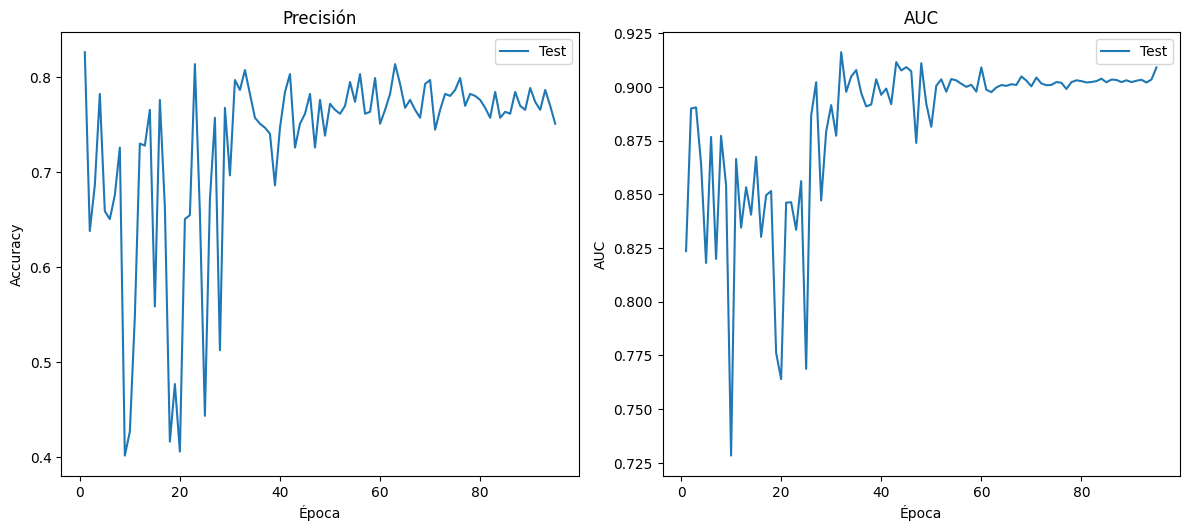

In [39]:
    tr_auc = history.history['auc']
    tr_acc = history.history["accuracy"]

    epochs = range(1, 95 + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, test_cb.test_history["accuracy"], label='Test')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()


    # AUC
    plt.subplot(2, 2, 2)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, test_cb.test_history["auc"], label='Test')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [45]:
model = DeepGNN(16,32,64,50) 
model.load_weights("best_model_weights.ckpt")

**Shallow GNN con optimizacion**

In [25]:
checkpoint_cb = ModelCheckpoint(filepath="Shallow_Disjoint512.ckpt",   # nombre del archivo
monitor="val_auc",mode="max",save_best_only=True,save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=35, restore_best_weights=True),
reduce_lr = ReduceLROnPlateau(monitor='val_auc',patience=10, factor=0.5,min_lr=1e-6)
callbacks = [checkpoint_cb, early_stopping, reduce_lr]

In [24]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0

----Training metrics------
Epoch 1/100
1933/1957 [============================>.] - ETA: 0s - loss: 0.2837 - accuracy: 0.8985 - precision: 0.9008 - recall: 0.9971 - auc: 0.7845   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 21s 10ms/step - loss: 0.2836 - accuracy: 0.8984 - precision: 0.9007 - recall: 0.9971 - auc: 0.7851 - val_loss: 0.3575 - val_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 1.0000 - val_auc: 0.6347 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 18s 9ms/step - loss: 0.2652 - accuracy: 0.9008 - precision: 0.9008 - recall: 1.0000 - auc: 0.8104 - val_loss: 0.3493 - val_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 1.0000 - val_auc: 0.6284 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 20s 10ms/step - loss: 0.2623 - accuracy: 0.9005 - precision: 0.9006 - recall: 0.9998 - auc: 0.8177 - val_loss: 0.3996 - val_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 1.0000 - val_auc: 0.6258 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 19s 10ms/step - loss: 0.2597 - accuracy: 0.9005 - precision: 0.9005 - recall: 0.9999 - auc: 0.8235 - val_loss: 0.3488 - val_accuracy: 

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.10      0.16      0.12        57
           1       0.88      0.81      0.84       421

    accuracy                           0.73       478
   macro avg       0.49      0.48      0.48       478
weighted avg       0.78      0.73      0.75       478

AUC clase 1: 0.4751843980497562
F1: 0.8405438813349815

Accuracy: 0.7301255230125523

Precision: 0.8762886597938144

Recall: 0.8076009501187649

Confusion:
 [[  9  48]
 [ 81 340]]


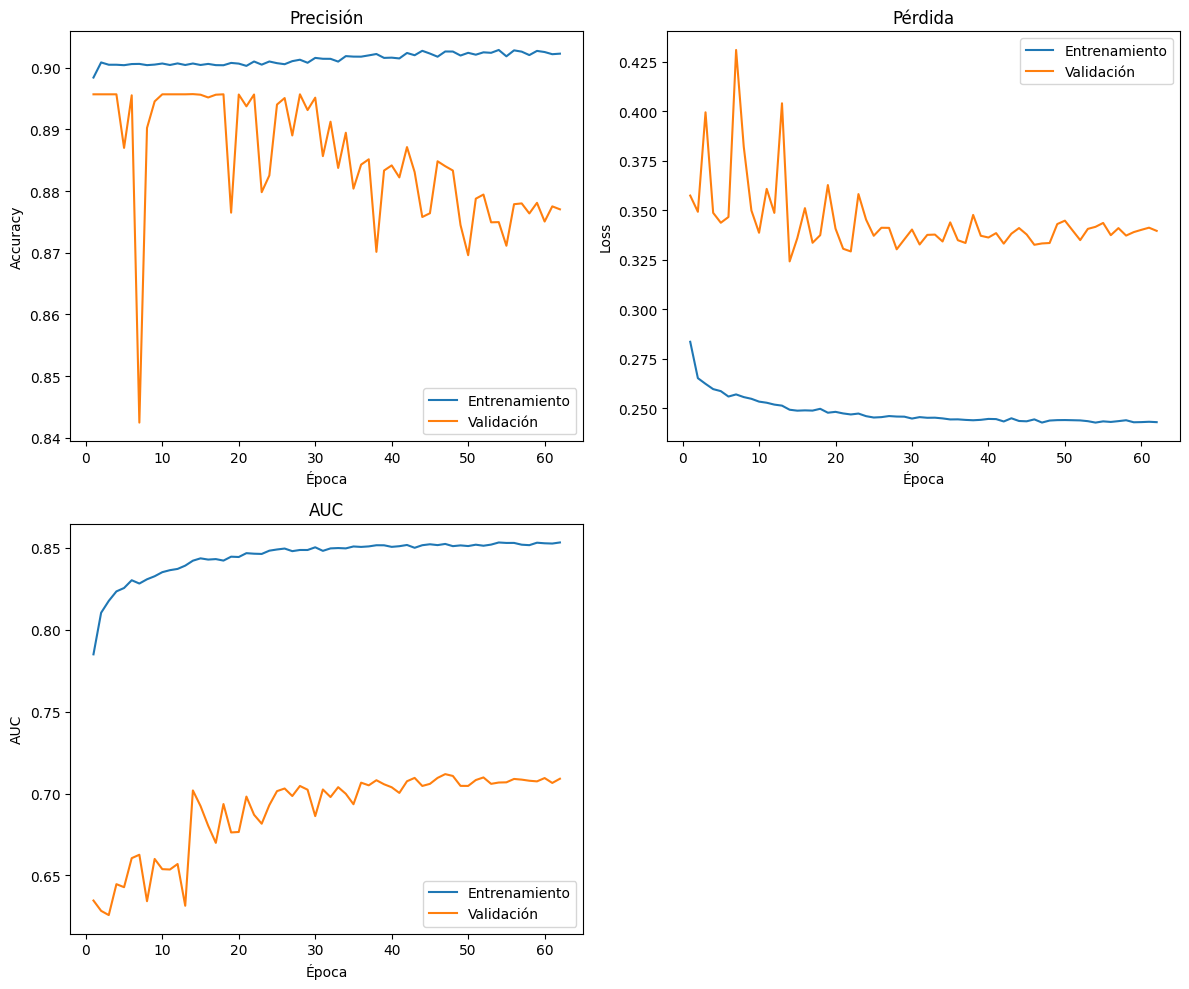

----Training metrics------
Epoch 1/100
1934/1957 [============================>.] - ETA: 0s - loss: 0.3101 - accuracy: 0.8902 - precision: 0.9014 - recall: 0.9858 - auc: 0.7527   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 21s 10ms/step - loss: 0.3098 - accuracy: 0.8903 - precision: 0.9015 - recall: 0.9860 - auc: 0.7530 - val_loss: 0.3241 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.6875 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 17s 9ms/step - loss: 0.2720 - accuracy: 0.9003 - precision: 0.9003 - recall: 1.0000 - auc: 0.7972 - val_loss: 0.3489 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.6149 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 19s 10ms/step - loss: 0.2674 - accuracy: 0.9002 - precision: 0.9004 - recall: 0.9997 - auc: 0.8085 - val_loss: 0.4521 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.6443 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 18s 9ms/step - loss: 0.2646 - accuracy: 0.9000 - precision: 0.9003 - recall: 0.9995 - auc: 0.8143 - val_loss: 0.3241 - val_accuracy: 0

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.12      0.32      0.18        57
           1       0.88      0.70      0.78       421

    accuracy                           0.65       478
   macro avg       0.50      0.51      0.48       478
weighted avg       0.79      0.65      0.71       478

AUC clase 1: 0.5332749927074218
F1: 0.7782204515272244

Accuracy: 0.6506276150627615

Precision: 0.8825301204819277

Recall: 0.6959619952494062

Confusion:
 [[ 18  39]
 [128 293]]


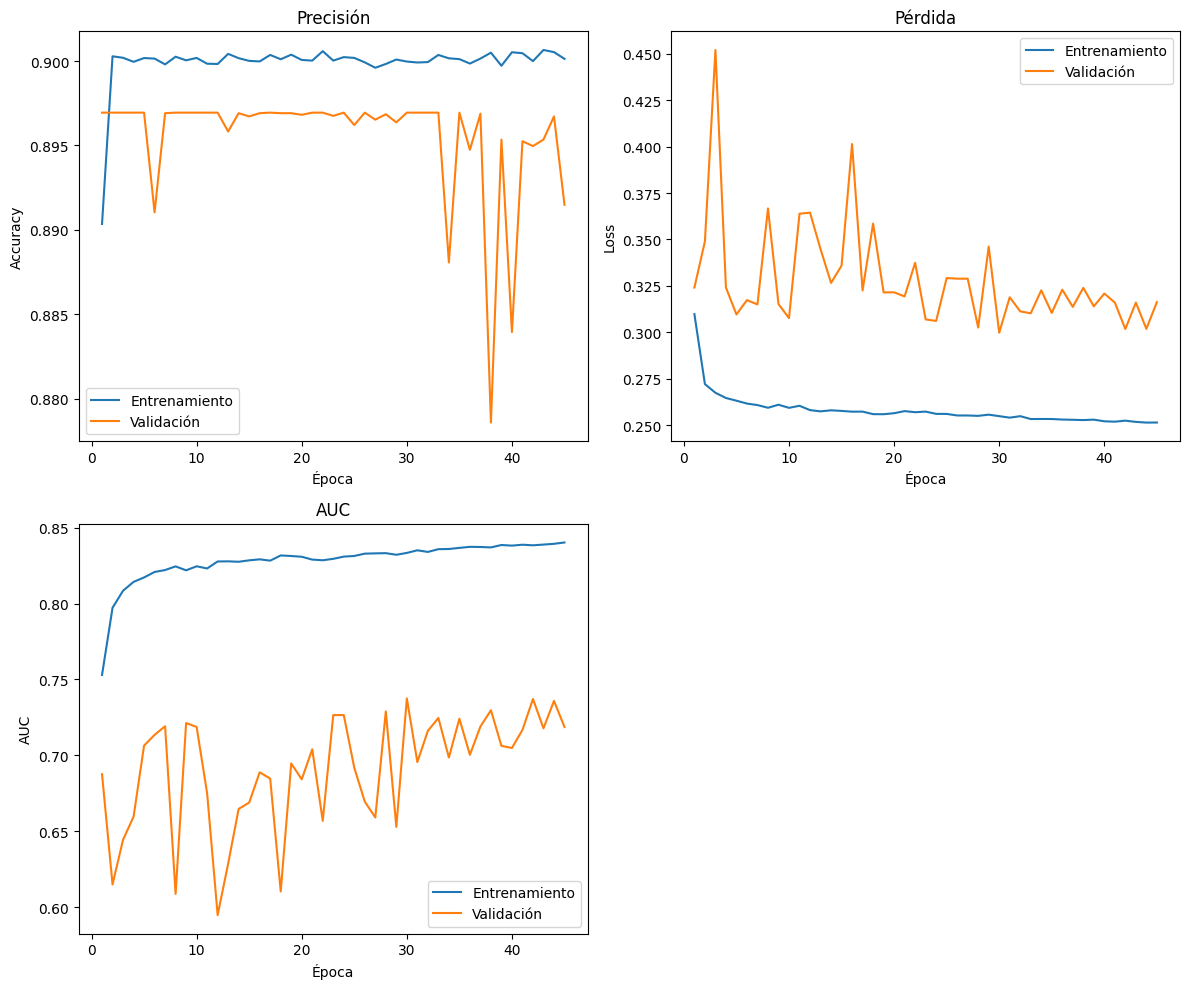

----Training metrics------
Epoch 1/100
1934/1957 [============================>.] - ETA: 0s - loss: 0.2866 - accuracy: 0.8954 - precision: 0.8962 - recall: 0.9990 - auc: 0.7906   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 18s 9ms/step - loss: 0.2863 - accuracy: 0.8954 - precision: 0.8962 - recall: 0.9990 - auc: 0.7911 - val_loss: 0.3278 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.6098 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 17s 9ms/step - loss: 0.2698 - accuracy: 0.8961 - precision: 0.8961 - recall: 1.0000 - auc: 0.8168 - val_loss: 0.3035 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.6292 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 16s 8ms/step - loss: 0.2696 - accuracy: 0.8962 - precision: 0.8962 - recall: 1.0000 - auc: 0.8179 - val_loss: 0.3158 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.6461 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 17s 9ms/step - loss: 0.2672 - accuracy: 0.8964 - precision: 0.8964 - recall: 1.0000 - auc: 0.8220 - val_loss: 0.3079 - val_accuracy: 0.9

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.10      0.16      0.12        57
           1       0.88      0.81      0.84       421

    accuracy                           0.73       478
   macro avg       0.49      0.48      0.48       478
weighted avg       0.78      0.73      0.75       478

AUC clase 1: 0.4761011793140809
F1: 0.8391089108910891

Accuracy: 0.7280334728033473

Precision: 0.875968992248062

Recall: 0.8052256532066508

Confusion:
 [[  9  48]
 [ 82 339]]


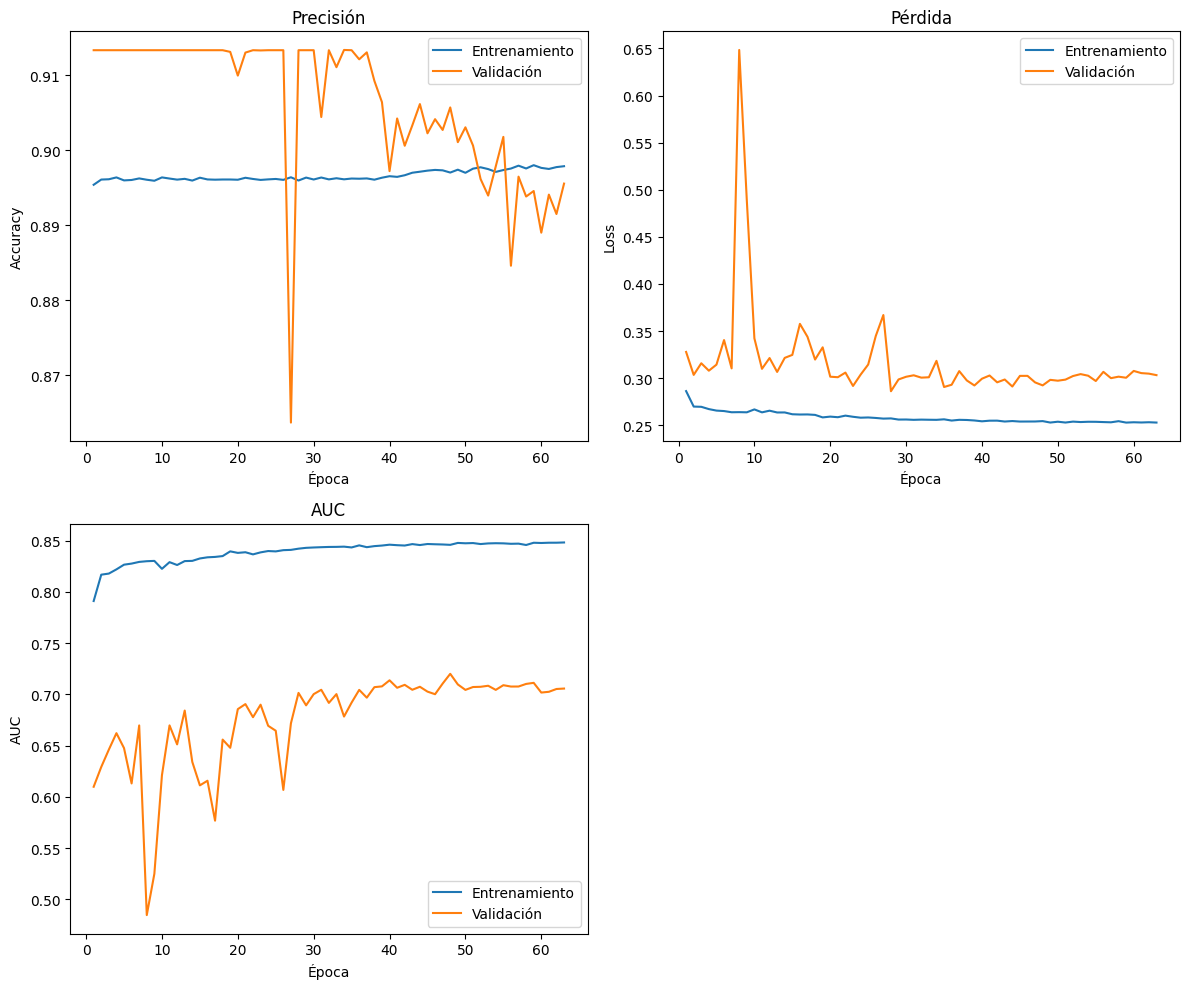

----Training metrics------
Epoch 1/100
1776/1958 [==========================>...] - ETA: 1s - loss: 0.2767 - accuracy: 0.9002 - precision: 0.9026 - recall: 0.9970 - auc: 0.7876   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1958/1958 [==============================] - 17s 8ms/step - loss: 0.2757 - accuracy: 0.9004 - precision: 0.9026 - recall: 0.9972 - auc: 0.7892 - val_loss: 0.3761 - val_accuracy: 0.8887 - val_precision: 0.8887 - val_recall: 1.0000 - val_auc: 0.6248 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 17s 9ms/step - loss: 0.2608 - accuracy: 0.9024 - precision: 0.9024 - recall: 1.0000 - auc: 0.8148 - val_loss: 0.3646 - val_accuracy: 0.8887 - val_precision: 0.8887 - val_recall: 1.0000 - val_auc: 0.6723 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 17s 9ms/step - loss: 0.2597 - accuracy: 0.9023 - precision: 0.9023 - recall: 1.0000 - auc: 0.8176 - val_loss: 0.3571 - val_accuracy: 0.8887 - val_precision: 0.8887 - val_recall: 1.0000 - val_auc: 0.5924 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 17s 8ms/step - loss: 0.2570 - accuracy: 0.9023 - precision: 0.9023 - recall: 1.0000 - auc: 0.8242 - val_loss: 0.3536 - val_accuracy: 0.8

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.10      0.07      0.08        57
           1       0.88      0.91      0.90       421

    accuracy                           0.81       478
   macro avg       0.49      0.49      0.49       478
weighted avg       0.79      0.81      0.80       478

AUC clase 1: 0.5249822894528483
F1: 0.8951048951048951

Accuracy: 0.8117154811715481

Precision: 0.8787185354691075

Recall: 0.9121140142517815

Confusion:
 [[  4  53]
 [ 37 384]]


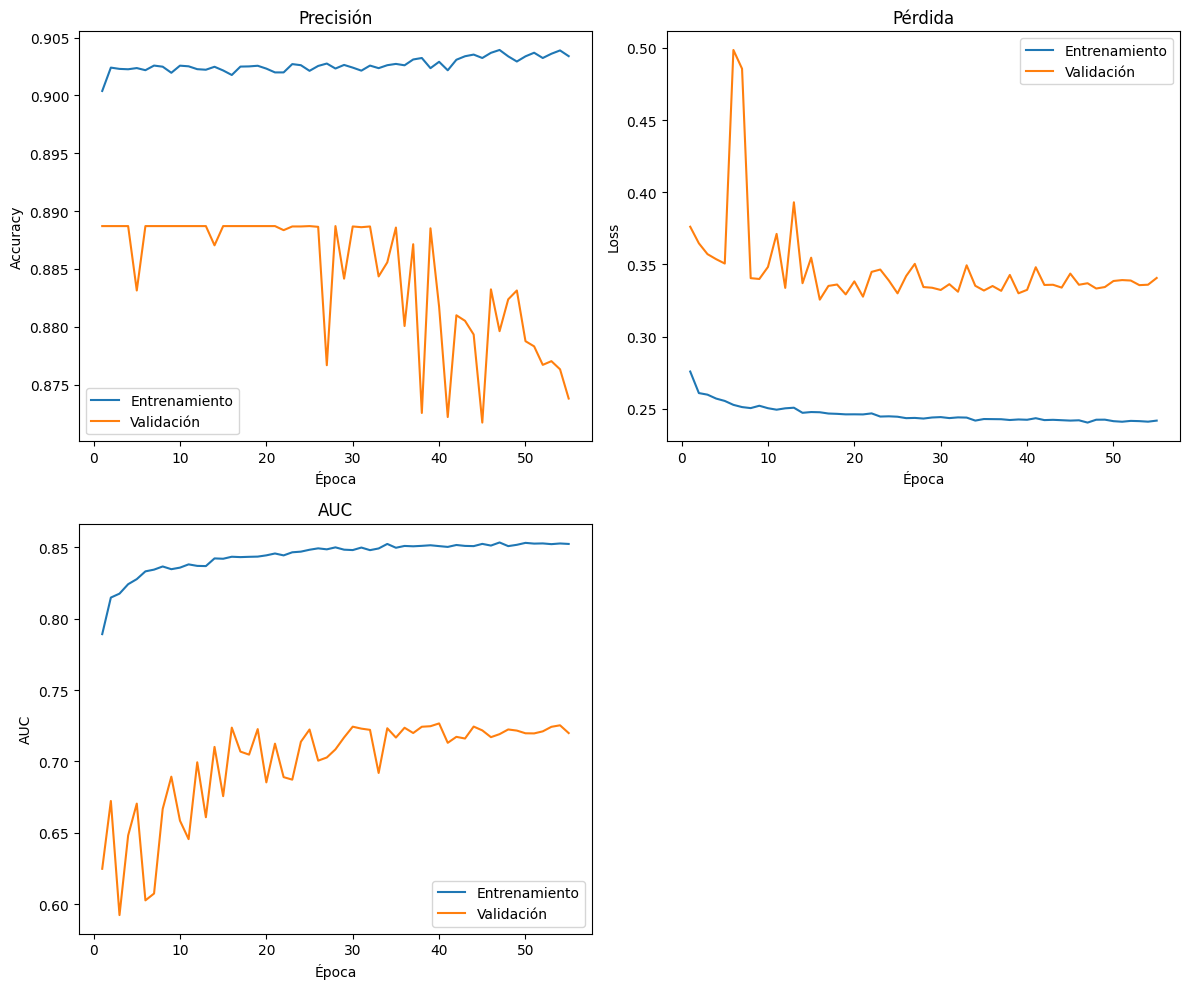

----Training metrics------
Epoch 1/100
 833/1957 [===========>..................] - ETA: 8s - loss: 0.3998 - accuracy: 0.8630 - precision: 0.8989 - recall: 0.9551 - auc: 0.6236   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 18s 9ms/step - loss: 0.3359 - accuracy: 0.8831 - precision: 0.8984 - recall: 0.9808 - auc: 0.7056 - val_loss: 0.3295 - val_accuracy: 0.9034 - val_precision: 0.9034 - val_recall: 1.0000 - val_auc: 0.6608 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 16s 8ms/step - loss: 0.2750 - accuracy: 0.8989 - precision: 0.8990 - recall: 0.9999 - auc: 0.7950 - val_loss: 0.3511 - val_accuracy: 0.9034 - val_precision: 0.9034 - val_recall: 1.0000 - val_auc: 0.6790 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 17s 8ms/step - loss: 0.2685 - accuracy: 0.8991 - precision: 0.8994 - recall: 0.9996 - auc: 0.8077 - val_loss: 0.3312 - val_accuracy: 0.9032 - val_precision: 0.9034 - val_recall: 0.9998 - val_auc: 0.6369 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 16s 8ms/step - loss: 0.2700 - accuracy: 0.8976 - precision: 0.8983 - recall: 0.9990 - auc: 0.8096 - val_loss: 0.3186 - val_accuracy: 0.9

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.16      0.28      0.21        57
           1       0.89      0.81      0.85       421

    accuracy                           0.74       478
   macro avg       0.53      0.54      0.53       478
weighted avg       0.81      0.74      0.77       478

AUC clase 1: 0.5370671333916739
F1: 0.8478802992518704

Accuracy: 0.7447698744769874

Precision: 0.8923884514435696

Recall: 0.8076009501187649

Confusion:
 [[ 16  41]
 [ 81 340]]


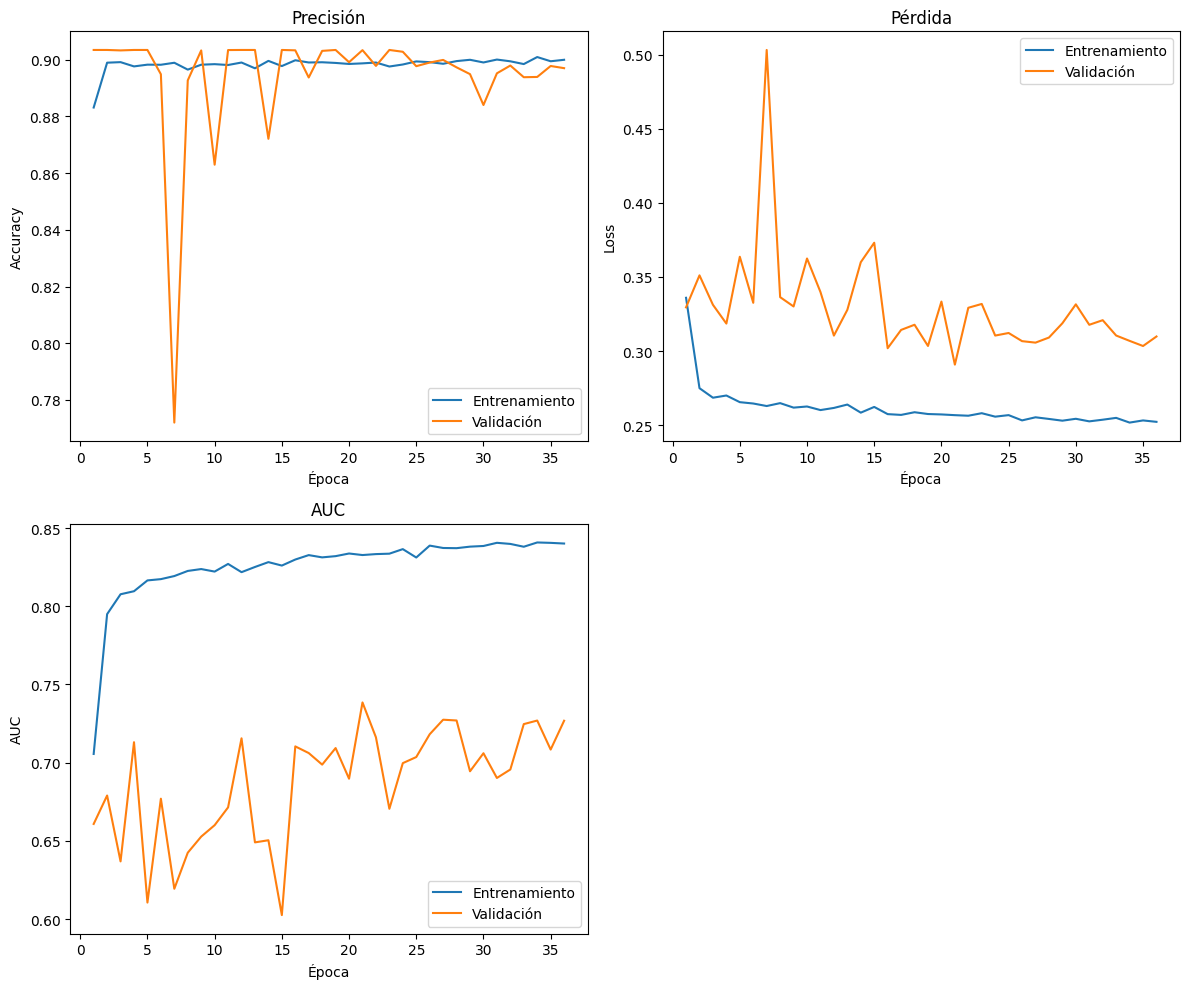

In [74]:
print("\n----General Metrics------\n")
print(classification_report(y_true_patient,y_pred_patient))
f1=f1_score(y_true_patient, y_pred_patient)
acc=accuracy_score(y_true_patient, y_pred_patient)
prec=precision_score(y_true_patient, y_pred_patient)
rec=recall_score(y_true_patient, y_pred_patient)
auc = roc_auc_score(y_true_patient, y_probs_patient)
print("AUC clase 1:", auc)
print("F1:", f1)
print("\nAccuracy:", acc)
print("\nPrecision:",prec )
print("\nRecall:",rec )
metricas.append((f1,acc, prec, rec,auc))
print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))


----General Metrics------

              precision    recall  f1-score   support

           0       0.31      0.82      0.46        40
           1       0.97      0.74      0.84       279

    accuracy                           0.75       319
   macro avg       0.64      0.78      0.65       319
weighted avg       0.89      0.75      0.79       319

AUC clase 1: 0.8584229390681004
F1: 0.8397565922920892

Accuracy: 0.7523510971786834

Precision: 0.9672897196261683

Recall: 0.7419354838709677

Confusion:
 [[ 33   7]
 [ 72 207]]


**GraphConvNetReduced con optimizacion**

In [25]:
checkpoint_cb = ModelCheckpoint(filepath="GraphConvReduced_64.ckpt",   # nombre del archivo
monitor="val_auc",mode="max",save_best_only=True,save_weights_only=True)

early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=35, restore_best_weights=True),
reduce_lr = ReduceLROnPlateau(monitor='val_auc',patience=10, factor=0.5,min_lr=1e-6)
callbacks = [checkpoint_cb, early_stopping, reduce_lr]

In [26]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0

----Training metrics------
Epoch 1/100
1957/1957 [==============================] - 27s 13ms/step - loss: 0.2694 - accuracy: 0.8986 - precision: 0.9021 - recall: 0.9955 - auc: 0.8111 - val_loss: 0.3411 - val_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 1.0000 - val_auc: 0.6737 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 24s 12ms/step - loss: 0.2521 - accuracy: 0.9003 - precision: 0.9015 - recall: 0.9983 - auc: 0.8378 - val_loss: 0.3697 - val_accuracy: 0.8847 - val_precision: 0.8954 - val_recall: 0.9865 - val_auc: 0.6274 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 25s 13ms/step - loss: 0.2470 - accuracy: 0.9008 - precision: 0.9030 - recall: 0.9970 - auc: 0.8453 - val_loss: 0.7438 - val_accuracy: 0.8957 - val_precision: 0.8957 - val_recall: 1.0000 - val_auc: 0.5210 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 25s 13ms/step - loss: 0.2466 - accuracy: 0.9013 - precision: 0.9047 - recall: 0.9952 - auc: 0.

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        57
           1       0.88      1.00      0.94       421

    accuracy                           0.88       478
   macro avg       0.44      0.50      0.47       478
weighted avg       0.78      0.88      0.82       478

AUC clase 1: 0.5499229070300454
F1: 0.9365962180200222

Accuracy: 0.8807531380753139

Precision: 0.8807531380753139

Recall: 1.0

Confusion:
 [[  0  57]
 [  0 421]]


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

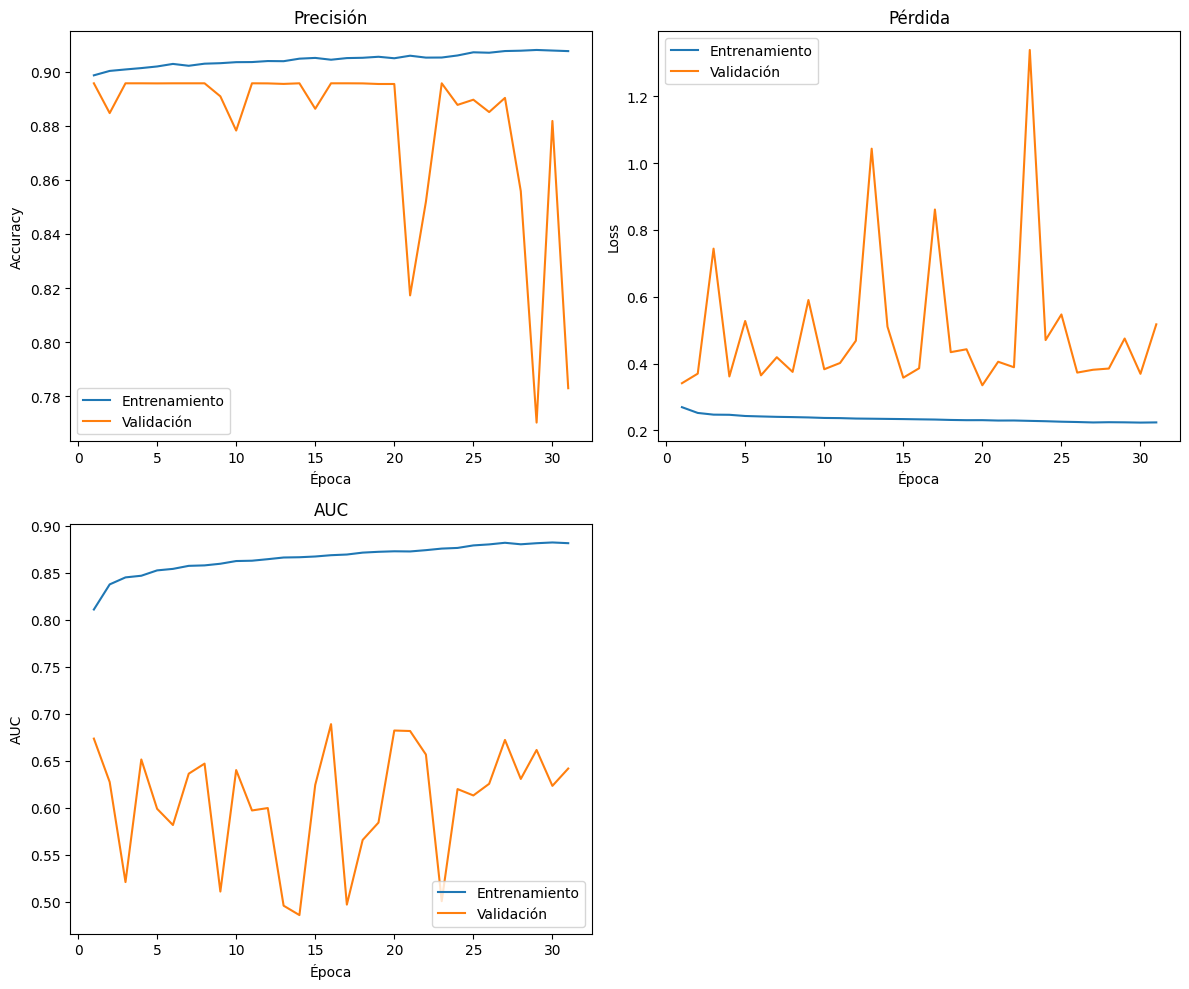

----Training metrics------
Epoch 1/100
1929/1957 [============================>.] - ETA: 0s - loss: 0.2710 - accuracy: 0.8983 - precision: 0.9010 - recall: 0.9966 - auc: 0.8073   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 23s 11ms/step - loss: 0.2707 - accuracy: 0.8984 - precision: 0.9011 - recall: 0.9966 - auc: 0.8074 - val_loss: 0.3507 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.6439 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 20s 10ms/step - loss: 0.2580 - accuracy: 0.9002 - precision: 0.9002 - recall: 1.0000 - auc: 0.8272 - val_loss: 0.3444 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.5405 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2560 - accuracy: 0.9003 - precision: 0.9003 - recall: 0.9999 - auc: 0.8312 - val_loss: 0.4172 - val_accuracy: 0.8969 - val_precision: 0.8969 - val_recall: 1.0000 - val_auc: 0.6335 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2540 - accuracy: 0.9001 - precision: 0.9012 - recall: 0.9984 - auc: 0.8345 - val_loss: 0.3316 - val_accuracy:

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.13      0.60      0.21        57
           1       0.89      0.44      0.59       421

    accuracy                           0.46       478
   macro avg       0.51      0.52      0.40       478
weighted avg       0.80      0.46      0.55       478

AUC clase 1: 0.5249406175771972
F1: 0.5927099841521395

Accuracy: 0.46234309623430964

Precision: 0.8904761904761904

Recall: 0.44418052256532065

Confusion:
 [[ 34  23]
 [234 187]]


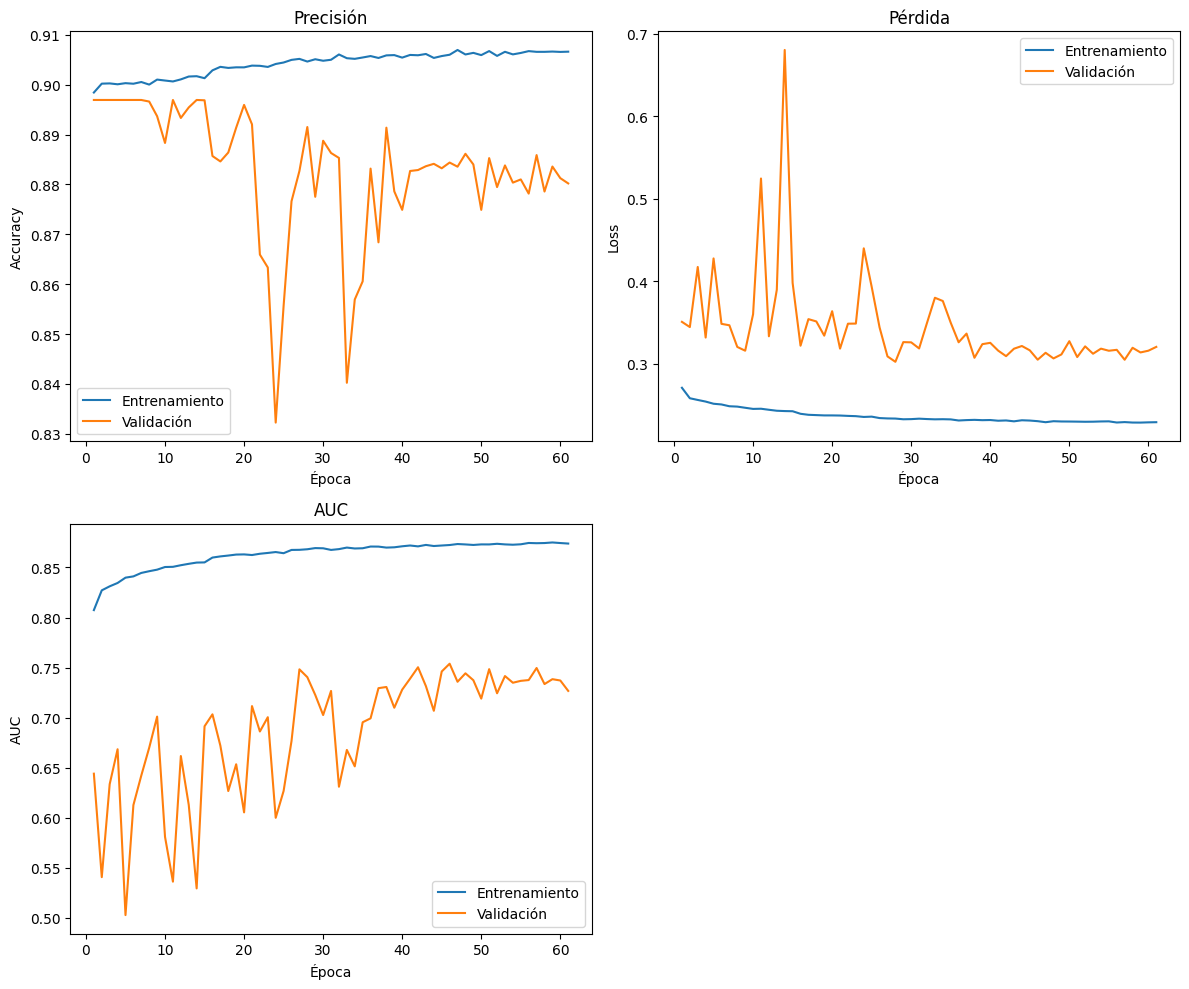

----Training metrics------
Epoch 1/100
1928/1957 [============================>.] - ETA: 0s - loss: 0.2817 - accuracy: 0.8935 - precision: 0.8978 - recall: 0.9944 - auc: 0.8040   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 22s 11ms/step - loss: 0.2812 - accuracy: 0.8936 - precision: 0.8978 - recall: 0.9945 - auc: 0.8045 - val_loss: 0.3985 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.6271 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2611 - accuracy: 0.8960 - precision: 0.8970 - recall: 0.9986 - auc: 0.8335 - val_loss: 0.6318 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.5030 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2564 - accuracy: 0.8963 - precision: 0.8999 - recall: 0.9951 - auc: 0.8418 - val_loss: 0.6199 - val_accuracy: 0.9134 - val_precision: 0.9134 - val_recall: 1.0000 - val_auc: 0.5088 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 20s 10ms/step - loss: 0.2541 - accuracy: 0.8970 - precision: 0.9007 - recall: 0.9947 - auc: 0.8455 - val_loss: 0.3190 - val_accuracy:

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.14      0.33      0.20        57
           1       0.89      0.73      0.80       421

    accuracy                           0.68       478
   macro avg       0.52      0.53      0.50       478
weighted avg       0.80      0.68      0.73       478

AUC clase 1: 0.4928949452014836
F1: 0.803129074315515

Accuracy: 0.6841004184100419

Precision: 0.8901734104046243

Recall: 0.7315914489311164

Confusion:
 [[ 19  38]
 [113 308]]


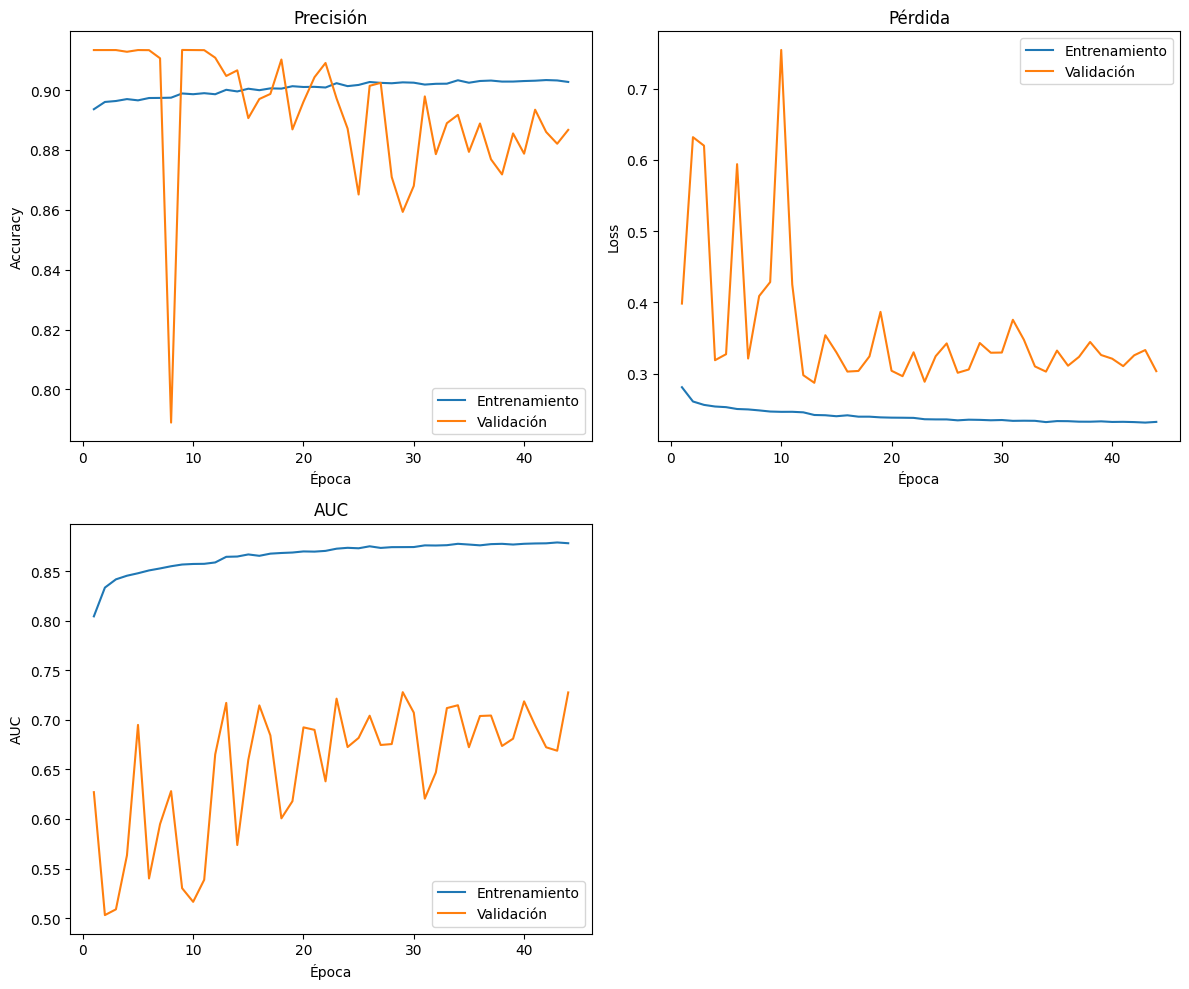

----Training metrics------
Epoch 1/100
1771/1958 [==========================>...] - ETA: 1s - loss: 0.2626 - accuracy: 0.9021 - precision: 0.9027 - recall: 0.9992 - auc: 0.8133   

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1958/1958 [==============================] - 22s 11ms/step - loss: 0.2618 - accuracy: 0.9021 - precision: 0.9026 - recall: 0.9993 - auc: 0.8148 - val_loss: 0.3942 - val_accuracy: 0.8887 - val_precision: 0.8887 - val_recall: 1.0000 - val_auc: 0.6344 - lr: 0.0010
Epoch 2/100
1958/1958 [==============================] - 21s 11ms/step - loss: 0.2508 - accuracy: 0.9023 - precision: 0.9023 - recall: 1.0000 - auc: 0.8350 - val_loss: 0.4094 - val_accuracy: 0.8884 - val_precision: 0.8887 - val_recall: 0.9997 - val_auc: 0.5777 - lr: 0.0010
Epoch 3/100
1958/1958 [==============================] - 21s 11ms/step - loss: 0.2464 - accuracy: 0.9029 - precision: 0.9042 - recall: 0.9981 - auc: 0.8421 - val_loss: 0.5322 - val_accuracy: 0.8887 - val_precision: 0.8887 - val_recall: 1.0000 - val_auc: 0.5700 - lr: 0.0010
Epoch 4/100
1958/1958 [==============================] - 20s 10ms/step - loss: 0.2439 - accuracy: 0.9026 - precision: 0.9051 - recall: 0.9964 - auc: 0.8485 - val_loss: 0.3843 - val_accuracy:

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.11      0.46      0.18        57
           1       0.87      0.50      0.64       421

    accuracy                           0.50       478
   macro avg       0.49      0.48      0.41       478
weighted avg       0.78      0.50      0.58       478

AUC clase 1: 0.5021461015960329
F1: 0.6385542168674698

Accuracy: 0.497907949790795

Precision: 0.8724279835390947

Recall: 0.503562945368171

Confusion:
 [[ 26  31]
 [209 212]]


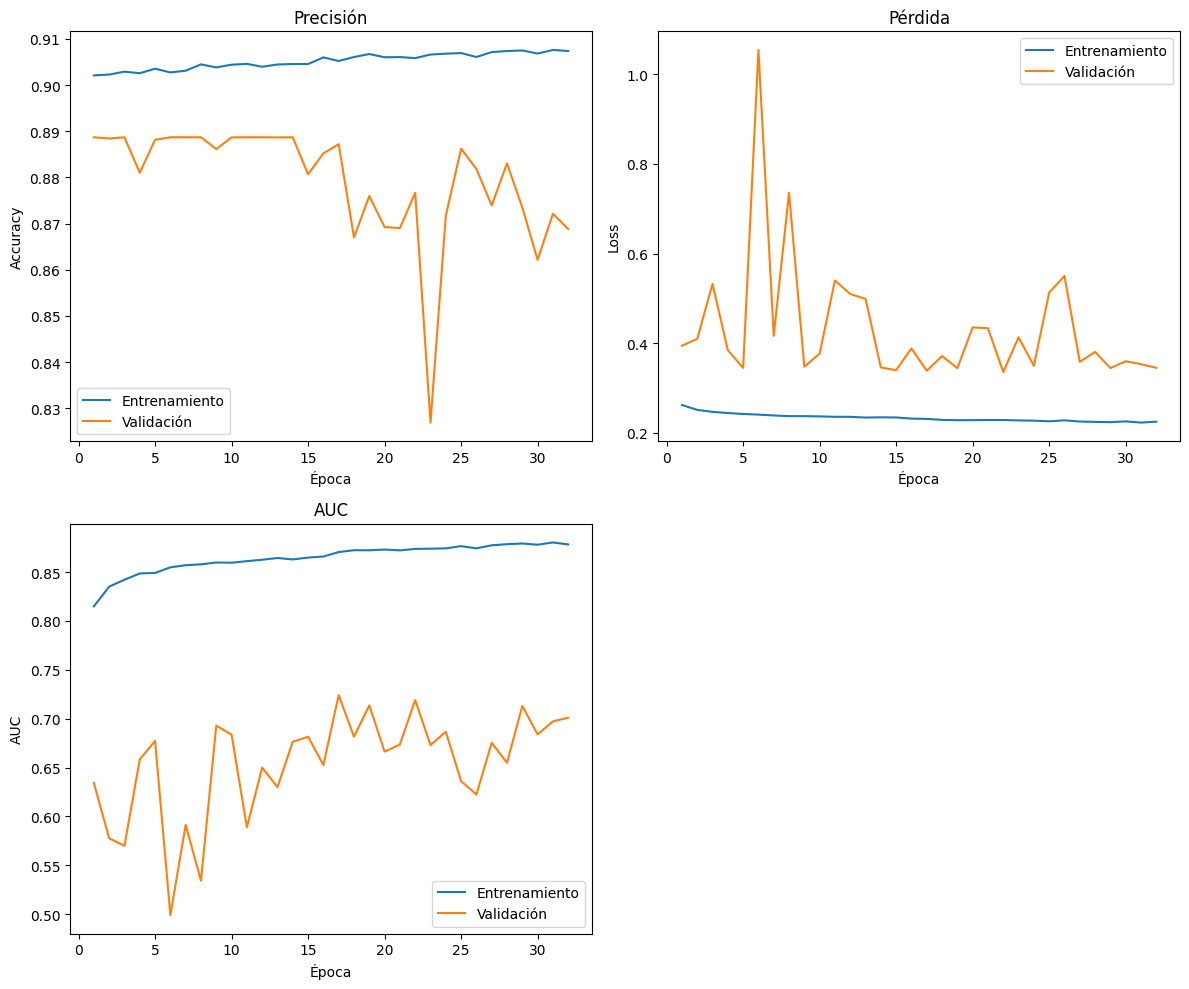

----Training metrics------
Epoch 1/100
 828/1957 [===========>..................] - ETA: 10s - loss: 0.2820 - accuracy: 0.8963 - precision: 0.8984 - recall: 0.9972 - auc: 0.7905  

/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


1957/1957 [==============================] - 23s 11ms/step - loss: 0.2727 - accuracy: 0.8975 - precision: 0.8987 - recall: 0.9984 - auc: 0.8061 - val_loss: 0.3206 - val_accuracy: 0.9034 - val_precision: 0.9034 - val_recall: 1.0000 - val_auc: 0.6091 - lr: 0.0010
Epoch 2/100
1957/1957 [==============================] - 20s 10ms/step - loss: 0.2590 - accuracy: 0.8995 - precision: 0.9004 - recall: 0.9987 - auc: 0.8265 - val_loss: 0.3215 - val_accuracy: 0.8924 - val_precision: 0.9032 - val_recall: 0.9866 - val_auc: 0.7129 - lr: 0.0010
Epoch 3/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2568 - accuracy: 0.8985 - precision: 0.9005 - recall: 0.9972 - auc: 0.8345 - val_loss: 0.3328 - val_accuracy: 0.8972 - val_precision: 0.9038 - val_recall: 0.9918 - val_auc: 0.6706 - lr: 0.0010
Epoch 4/100
1957/1957 [==============================] - 21s 11ms/step - loss: 0.2518 - accuracy: 0.9001 - precision: 0.9026 - recall: 0.9964 - auc: 0.8409 - val_loss: 0.3199 - val_accuracy:

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.14      0.44      0.21        57
           1       0.89      0.62      0.73       421

    accuracy                           0.60       478
   macro avg       0.51      0.53      0.47       478
weighted avg       0.80      0.60      0.67       478

AUC clase 1: 0.5205650706338292
F1: 0.7310924369747899

Accuracy: 0.5983263598326359

Precision: 0.8907849829351536

Recall: 0.6199524940617577

Confusion:
 [[ 25  32]
 [160 261]]


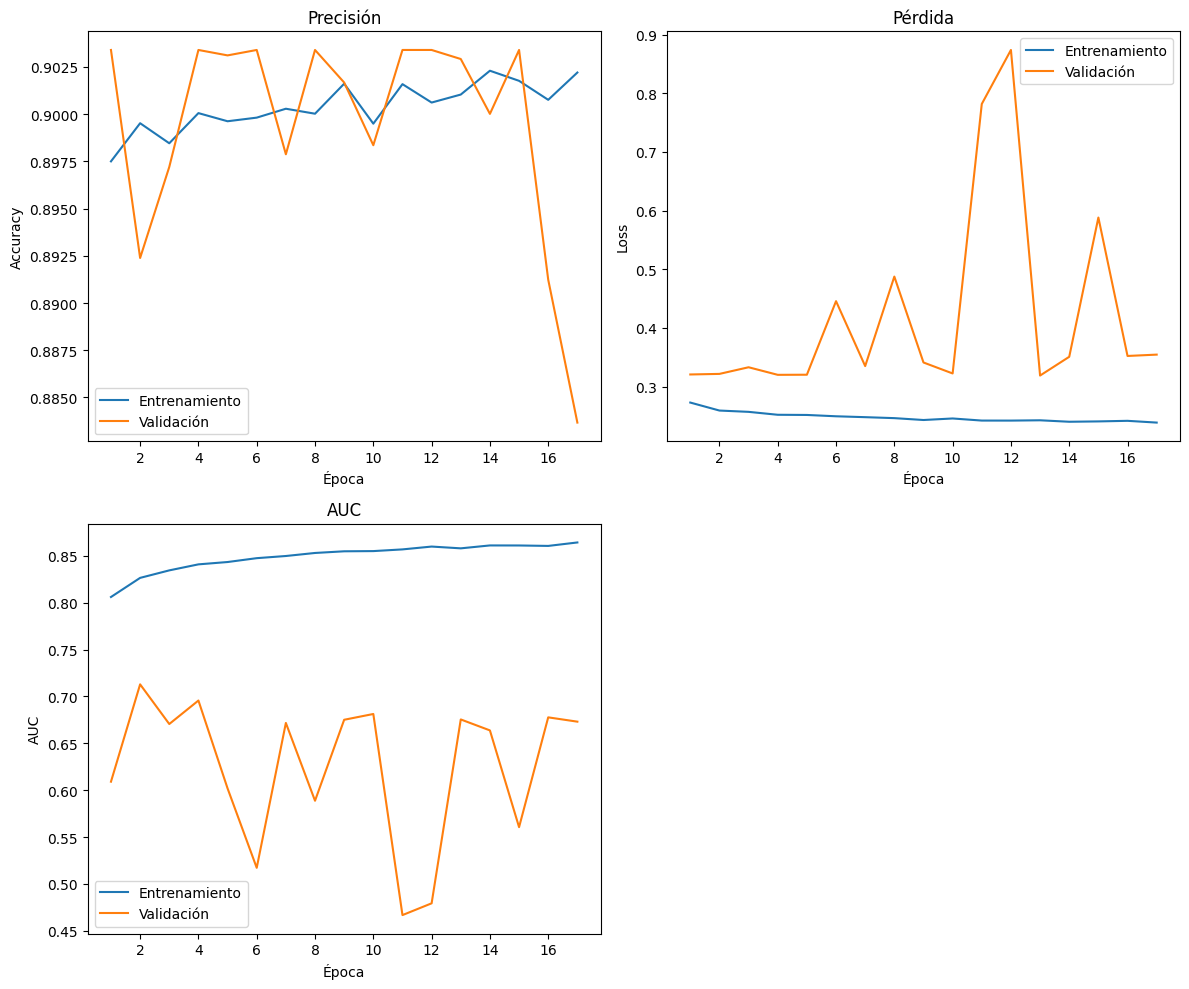

In [34]:
print("\n----General Metrics------\n")
print(classification_report(y_true_patient,y_pred_patient))
f1=f1_score(y_true_patient, y_pred_patient)
acc=accuracy_score(y_true_patient, y_pred_patient)
prec=precision_score(y_true_patient, y_pred_patient)
rec=recall_score(y_true_patient, y_pred_patient)
auc = roc_auc_score(y_true_patient, y_probs_patient)
print("AUC clase 1:", auc)
print("F1:", f1)
print("\nAccuracy:", acc)
print("\nPrecision:",prec )
print("\nRecall:",rec )
metricas.append((f1,acc, prec, rec,auc))
print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))


----General Metrics------

              precision    recall  f1-score   support

           0       0.63      0.55      0.59        40
           1       0.94      0.95      0.94       279

    accuracy                           0.90       319
   macro avg       0.78      0.75      0.77       319
weighted avg       0.90      0.90      0.90       319

AUC clase 1: 0.8760752688172044
F1: 0.9449378330373002

Accuracy: 0.9028213166144201

Precision: 0.9366197183098591

Recall: 0.953405017921147

Confusion:
 [[ 22  18]
 [ 13 266]]


**GAT inductive architecture proposed by Velickovic**

In [17]:
checkpoint_cb = ModelCheckpoint(filepath="GAT_ARCH_induc_64.ckpt",   # nombre del archivo
monitor="val_auc",mode="max",save_best_only=True,save_weights_only=True)
early_stopping = EarlyStopping(monitor='val_auc',mode='max',patience=35, restore_best_weights=True),
reduce_lr = ReduceLROnPlateau(monitor='val_auc',patience=10, factor=0.5,min_lr=1e-6)
callbacks = [checkpoint_cb, early_stopping, reduce_lr]

2025-10-13 11:14:34.578546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-13 11:14:34.696766: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-13 11:14:34.696815: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-13 11:14:34.702084: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-13 11:14:34.702159: I tensorflow/compile

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
2025-10-13 11:14:36.168576: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


2025-10-13 11:14:39.616300: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1440fa7f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-13 11:14:39.616329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-10-13 11:14:39.622859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-13 11:14:39.650204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-10-13 11:14:39.714240: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1965/1965 [==============================] - 43s 20ms/step - loss: 0.7254 - accuracy: 0.4832 - precision: 0.9165 - recall: 0.4673 - auc: 0.5638 - val_loss: 0.3970 - val_accuracy: 0.8944 - val_precision: 0.9044 - val_recall: 0.9876 - val_auc: 0.5916 - lr: 5.0000e-04
Epoch 2/100
1965/1965 [==============================] - 37s 19ms/step - loss: 0.6507 - accuracy: 0.4634 - precision: 0.9478 - recall: 0.4262 - auc: 0.6518 - val_loss: 0.4740 - val_accuracy: 0.9044 - val_precision: 0.9044 - val_recall: 1.0000 - val_auc: 0.5459 - lr: 5.0000e-04
Epoch 3/100
1965/1965 [==============================] - 39s 20ms/step - loss: 0.6360 - accuracy: 0.5013 - precision: 0.9514 - recall: 0.4689 - auc: 0.6799 - val_loss: 0.3625 - val_accuracy: 0.9044 - val_precision: 0.9044 - val_recall: 1.0000 - val_auc: 0.5876 - lr: 5.0000e-04
Epoch 4/100
1965/1965 [==============================] - 38s 19ms/step - loss: 0.6272 - accuracy: 0.5375 - precision: 0.9502 - recall: 0.5120 - auc: 0.6914 - val_loss: 0.6155 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.26      0.89      0.41        57
           1       0.98      0.66      0.79       421

    accuracy                           0.69       478
   macro avg       0.62      0.78      0.60       478
weighted avg       0.89      0.69      0.74       478

AUC clase 1: 0.8884860607575946
F1: 0.7886524822695036

Accuracy: 0.6882845188284519

Precision: 0.9788732394366197

Recall: 0.6603325415676959

Confusion:
 [[ 51   6]
 [143 278]]


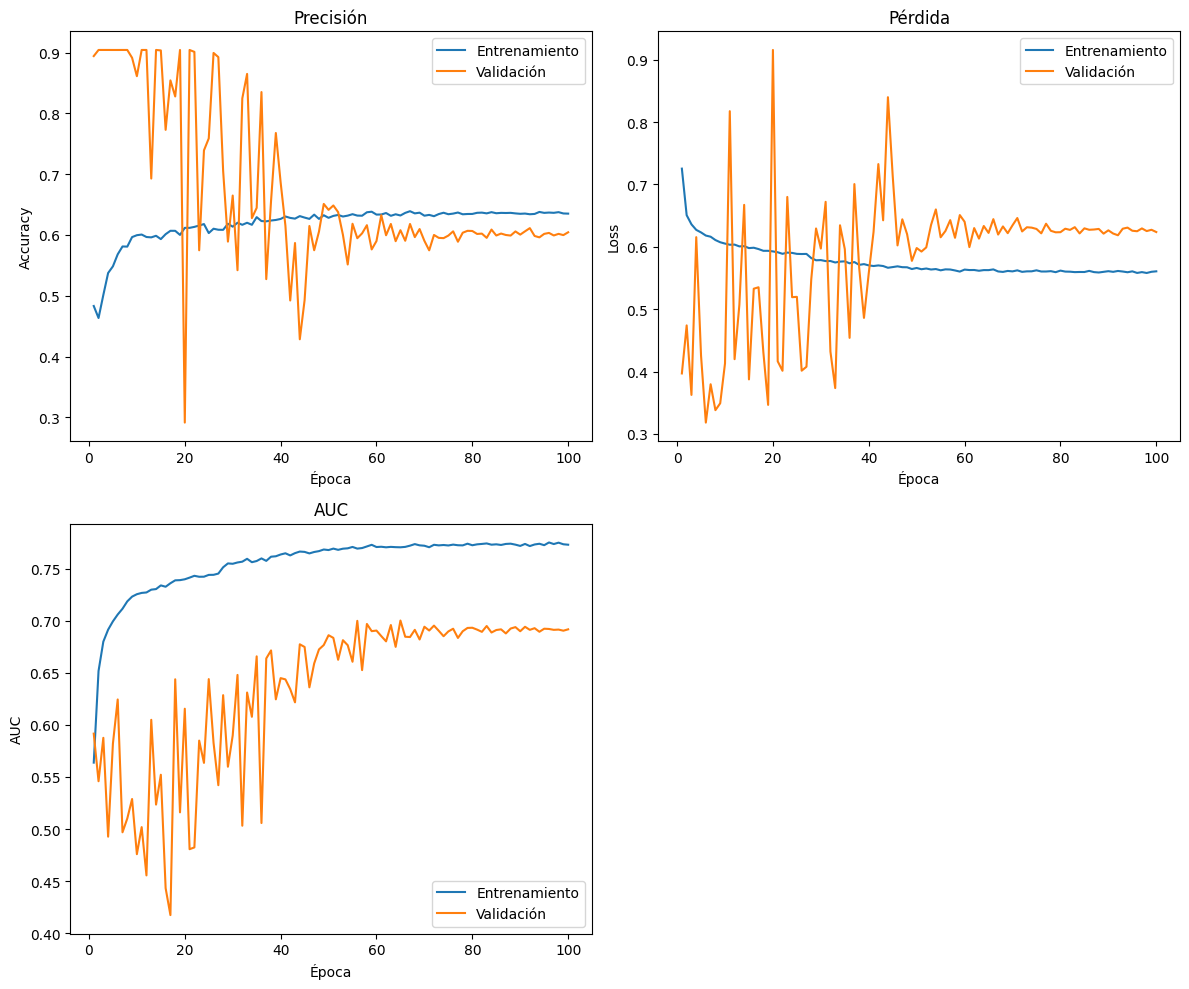

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1940/1940 [==============================] - 45s 22ms/step - loss: 0.7468 - accuracy: 0.4319 - precision: 0.9186 - recall: 0.4057 - auc: 0.5489 - val_loss: 0.6461 - val_accuracy: 0.6707 - val_precision: 0.9204 - val_recall: 0.6911 - val_auc: 0.6494 - lr: 5.0000e-04
Epoch 2/100
1940/1940 [==============================] - 42s 21ms/step - loss: 0.6556 - accuracy: 0.4383 - precision: 0.9430 - recall: 0.4010 - auc: 0.6245 - val_loss: 0.4185 - val_accuracy: 0.8932 - val_precision: 0.8932 - val_recall: 1.0000 - val_auc: 0.5439 - lr: 5.0000e-04
Epoch 3/100
1940/1940 [==============================] - 36s 19ms/step - loss: 0.6412 - accuracy: 0.4867 - precision: 0.9476 - recall: 0.4556 - auc: 0.6621 - val_loss: 0.4594 - val_accuracy: 0.8715 - val_precision: 0.8911 - val_recall: 0.9754 - val_auc: 0.5083 - lr: 5.0000e-04
Epoch 4/100
1940/1940 [==============================] - 37s 19ms/step - loss: 0.6328 - accuracy: 0.5556 - precision: 0.9440 - recall: 0.5389 - auc: 0.6760 - val_loss: 0.4147 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.25      0.89      0.39        57
           1       0.98      0.63      0.77       421

    accuracy                           0.67       478
   macro avg       0.61      0.76      0.58       478
weighted avg       0.89      0.67      0.72       478

AUC clase 1: 0.8558153102471142
F1: 0.7694524495677233

Accuracy: 0.6652719665271967

Precision: 0.978021978021978

Recall: 0.6342042755344418

Confusion:
 [[ 51   6]
 [154 267]]


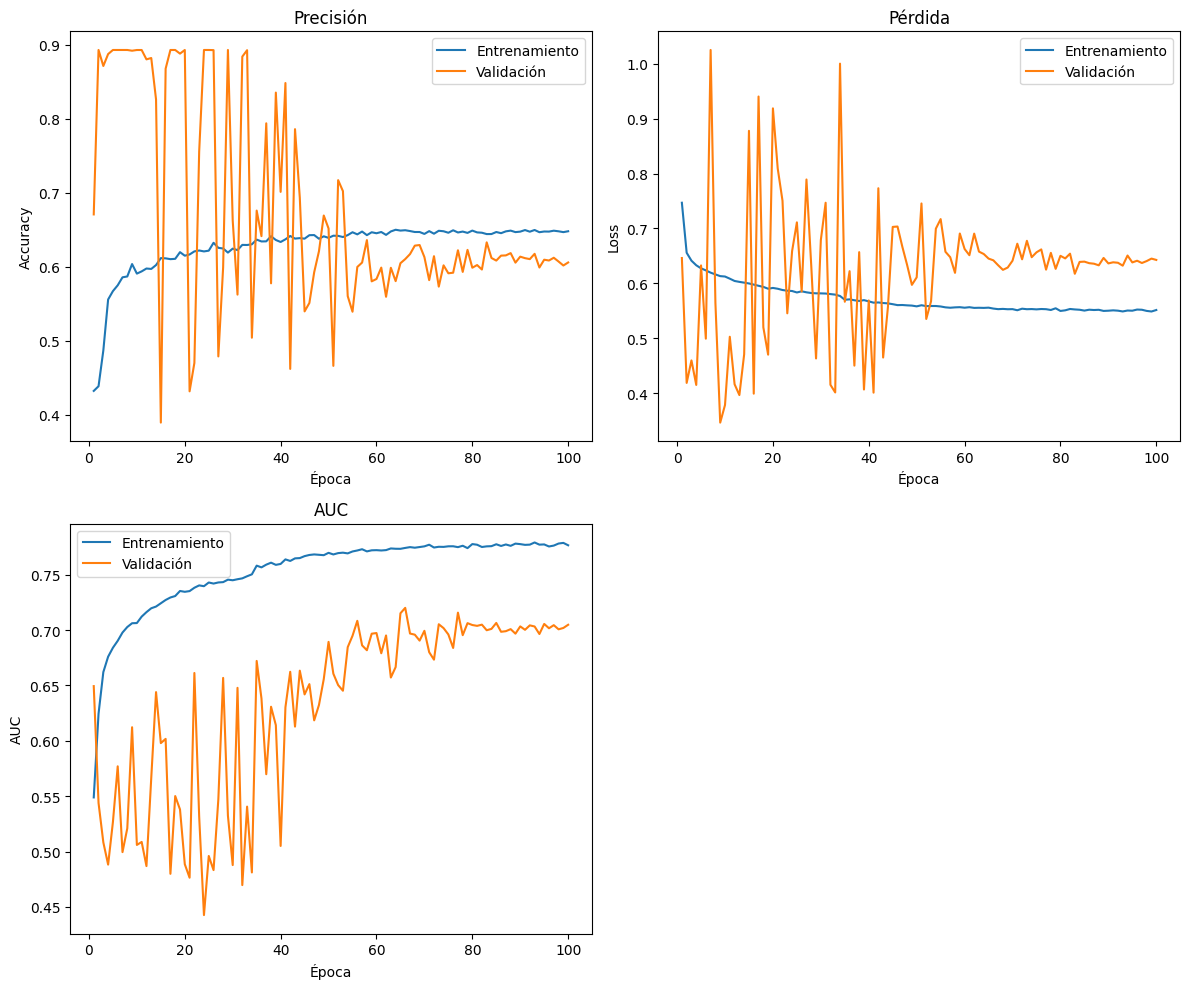

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1961/1961 [==============================] - 42s 20ms/step - loss: 0.7046 - accuracy: 0.4448 - precision: 0.9190 - recall: 0.4200 - auc: 0.5604 - val_loss: 1.3412 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.4998 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 38s 19ms/step - loss: 0.6416 - accuracy: 0.4828 - precision: 0.9460 - recall: 0.4509 - auc: 0.6553 - val_loss: 0.4594 - val_accuracy: 0.8230 - val_precision: 0.9067 - val_recall: 0.8953 - val_auc: 0.6319 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 36s 18ms/step - loss: 0.6263 - accuracy: 0.5369 - precision: 0.9510 - recall: 0.5116 - auc: 0.6864 - val_loss: 1.6142 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5000 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 38s 19ms/step - loss: 0.6150 - accuracy: 0.5615 - precision: 0.9531 - recall: 0.5392 - auc: 0.7033 - val_loss: 0.9147 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.26      0.86      0.40        57
           1       0.97      0.67      0.79       421

    accuracy                           0.69       478
   macro avg       0.62      0.76      0.59       478
weighted avg       0.89      0.69      0.74       478

AUC clase 1: 0.8544818102262782
F1: 0.7898448519040903

Accuracy: 0.6882845188284519

Precision: 0.9722222222222222

Recall: 0.665083135391924

Confusion:
 [[ 49   8]
 [141 280]]


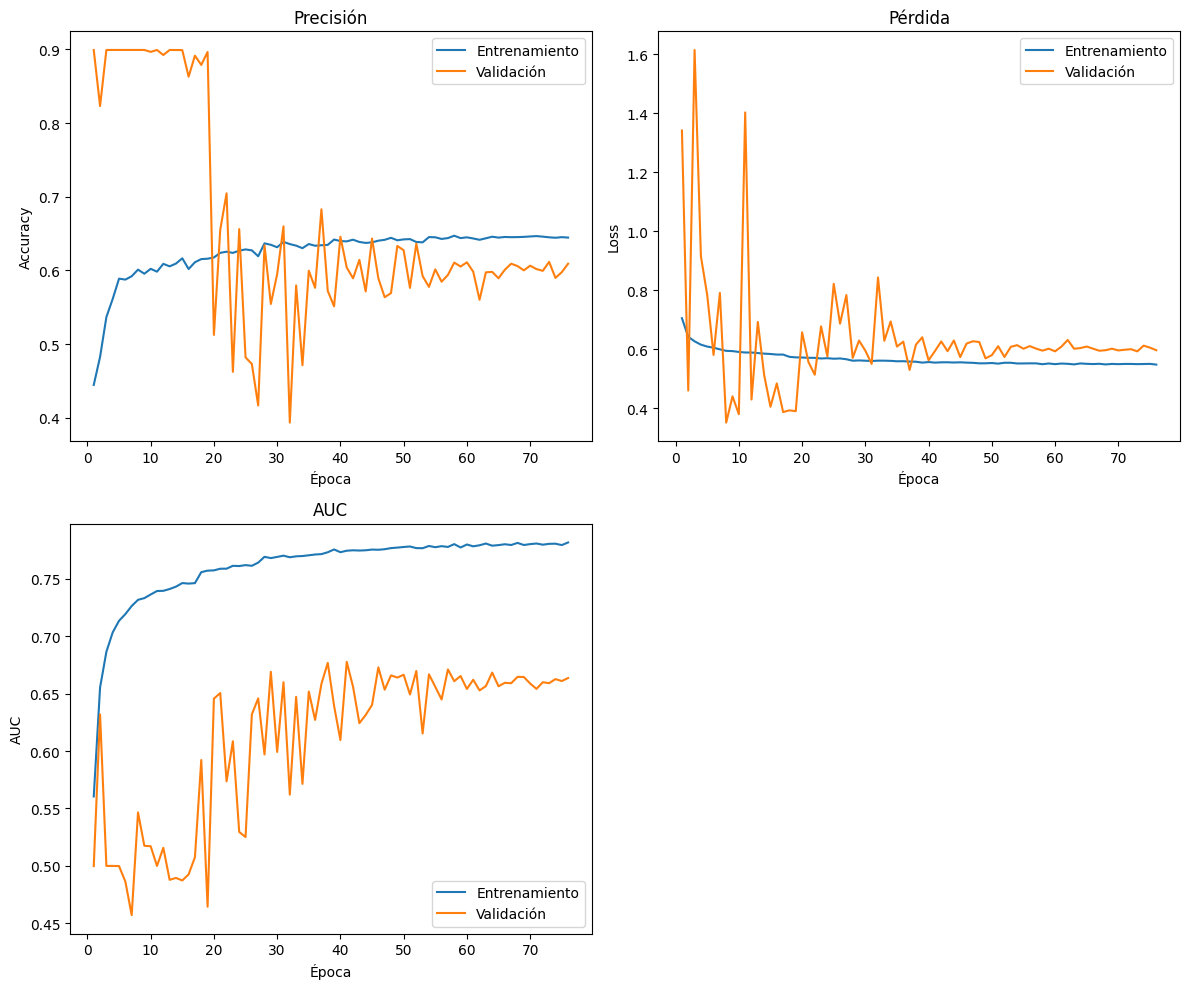

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1960/1960 [==============================] - 41s 20ms/step - loss: 0.7312 - accuracy: 0.4168 - precision: 0.9178 - recall: 0.3864 - auc: 0.5472 - val_loss: 0.4936 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5397 - lr: 5.0000e-04
Epoch 2/100
1960/1960 [==============================] - 36s 18ms/step - loss: 0.6522 - accuracy: 0.4570 - precision: 0.9463 - recall: 0.4204 - auc: 0.6465 - val_loss: 0.4210 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5428 - lr: 5.0000e-04
Epoch 3/100
1960/1960 [==============================] - 39s 20ms/step - loss: 0.6355 - accuracy: 0.5018 - precision: 0.9517 - recall: 0.4702 - auc: 0.6763 - val_loss: 0.4458 - val_accuracy: 0.8991 - val_precision: 0.8991 - val_recall: 1.0000 - val_auc: 0.5304 - lr: 5.0000e-04
Epoch 4/100
1960/1960 [==============================] - 39s 20ms/step - loss: 0.6287 - accuracy: 0.5352 - precision: 0.9508 - recall: 0.5098 - auc: 0.6883 - val_loss: 1.0545 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.24      0.86      0.37        57
           1       0.97      0.63      0.76       421

    accuracy                           0.65       478
   macro avg       0.60      0.74      0.57       478
weighted avg       0.88      0.65      0.72       478

AUC clase 1: 0.8546901696045338
F1: 0.7619047619047619

Accuracy: 0.6548117154811716

Precision: 0.9705882352941176

Recall: 0.6270783847980997

Confusion:
 [[ 49   8]
 [157 264]]


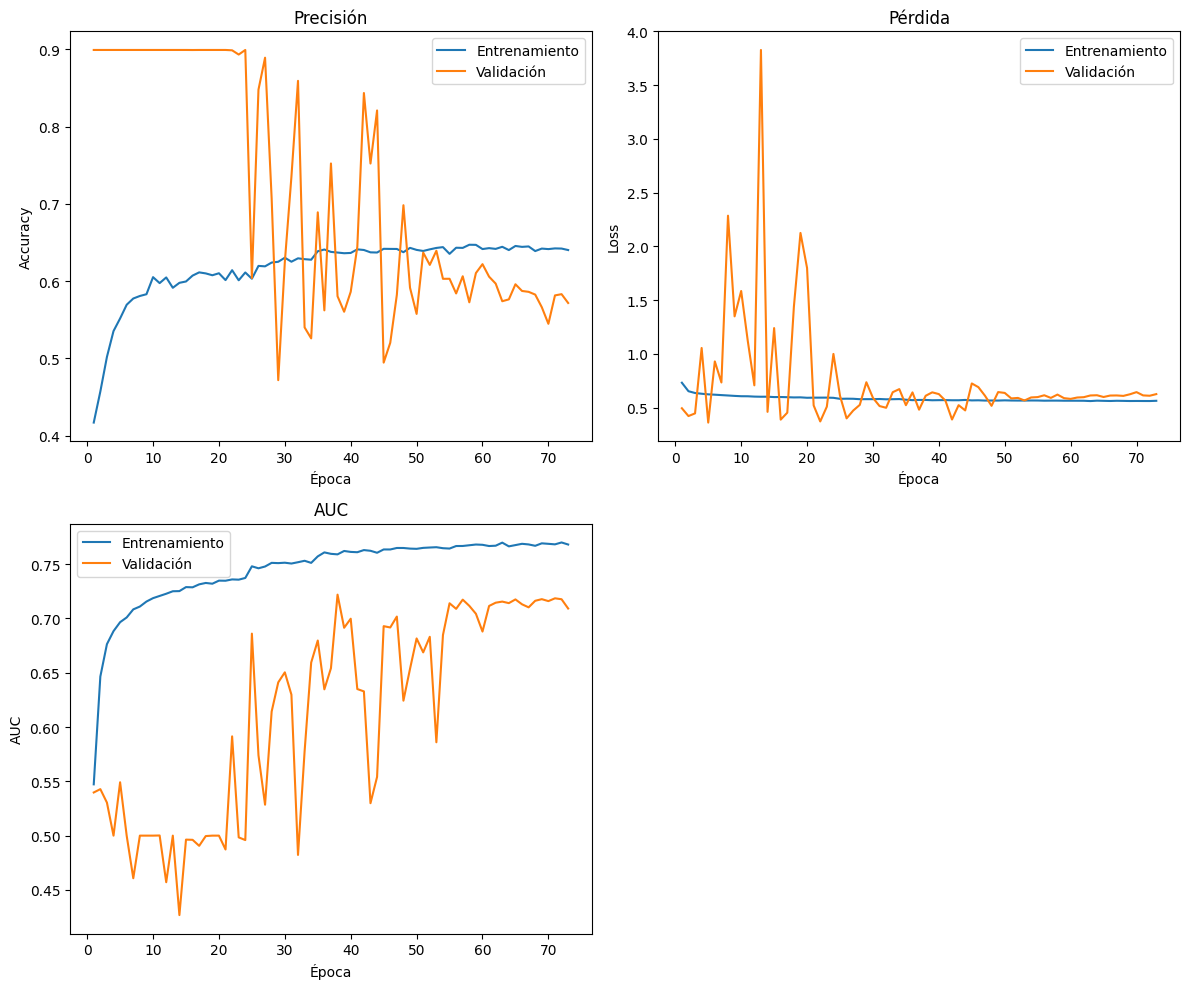

----Training metrics------


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'DatasetBuilder_noindex' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Epoch 1/100


/home/tomeu/miniconda3/envs/spektral/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1961/1961 [==============================] - 38s 18ms/step - loss: 0.7805 - accuracy: 0.3858 - precision: 0.9223 - recall: 0.3458 - auc: 0.5559 - val_loss: 0.6443 - val_accuracy: 0.9012 - val_precision: 0.9025 - val_recall: 0.9984 - val_auc: 0.4302 - lr: 5.0000e-04
Epoch 2/100
1961/1961 [==============================] - 35s 18ms/step - loss: 0.6581 - accuracy: 0.3804 - precision: 0.9496 - recall: 0.3281 - auc: 0.6228 - val_loss: 0.3183 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.5872 - lr: 5.0000e-04
Epoch 3/100
1961/1961 [==============================] - 36s 18ms/step - loss: 0.6372 - accuracy: 0.5196 - precision: 0.9492 - recall: 0.4919 - auc: 0.6758 - val_loss: 0.4959 - val_accuracy: 0.9026 - val_precision: 0.9026 - val_recall: 1.0000 - val_auc: 0.4867 - lr: 5.0000e-04
Epoch 4/100
1961/1961 [==============================] - 35s 18ms/step - loss: 0.6257 - accuracy: 0.5465 - precision: 0.9505 - recall: 0.5227 - auc: 0.6938 - val_loss: 0.3748 - v

/home/tomeu/spektral/metrics.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  MASTER_DATASET_INDEX = pd.read_csv("/home/tomeu/spektral/data/master_metadata_index.csv")



----General Metrics------

              precision    recall  f1-score   support

           0       0.19      0.84      0.31        57
           1       0.96      0.50      0.66       421

    accuracy                           0.54       478
   macro avg       0.57      0.67      0.48       478
weighted avg       0.87      0.54      0.62       478

AUC clase 1: 0.8287285910738843
F1: 0.660436137071651

Accuracy: 0.5439330543933054

Precision: 0.9592760180995475

Recall: 0.503562945368171

Confusion:
 [[ 48   9]
 [209 212]]


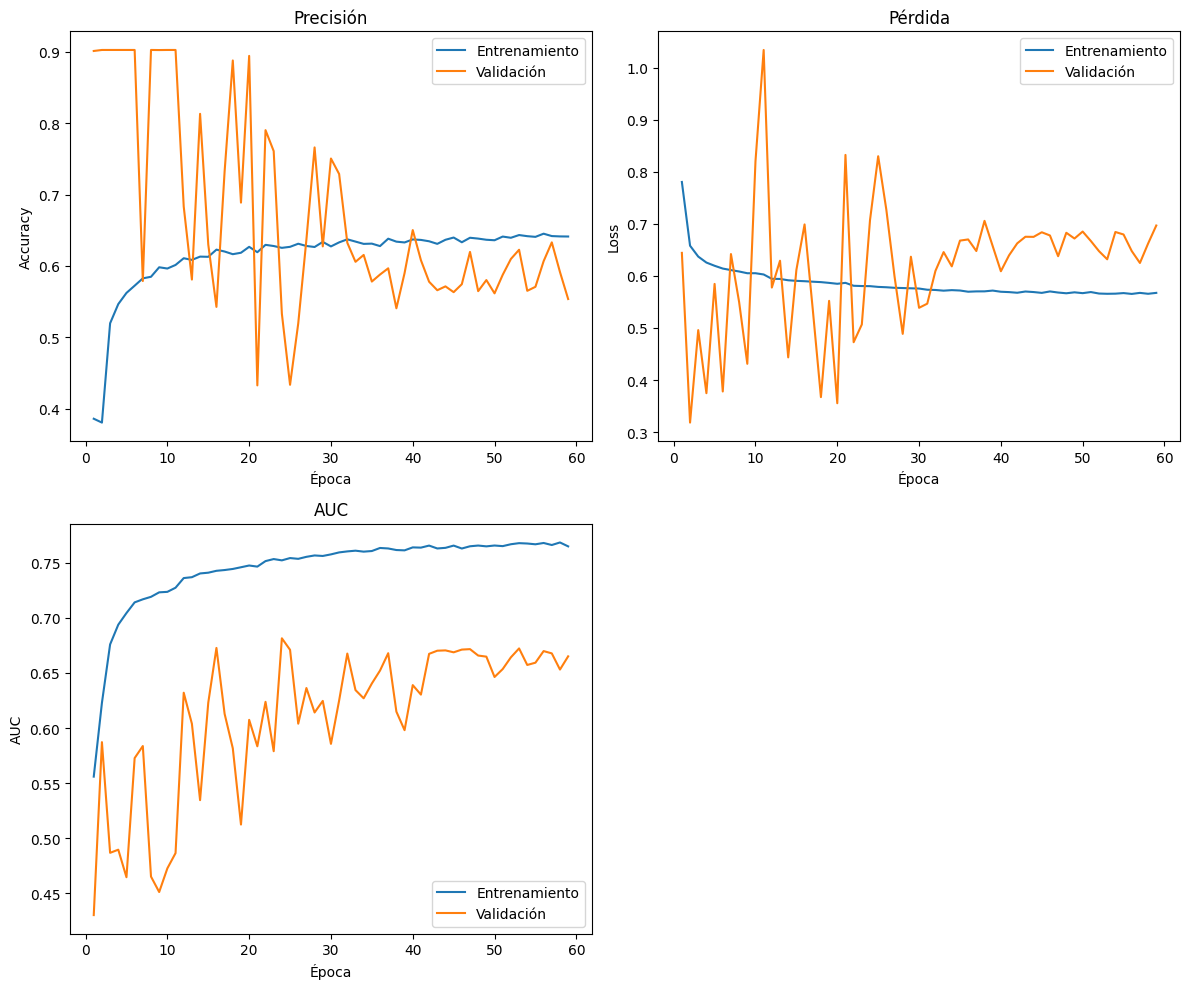

In [21]:
precision=[]
recall = []
F1 = []
AUC = []
accuracy=[]
i=0
for train_loader,val_loader in loaders:
    optimizer = Adam(learning_rate=5e-4,clipnorm=1.0)
    print("----Training metrics------")
    model = GATGraphClassifier(n_classes=1)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics = ["accuracy","Precision","Recall","AUC"])
    history = model.fit(train_loader.load(),class_weight={0:class_weights[0],1:class_weights[1]},steps_per_epoch=train_loader.steps_per_epoch,
          validation_data=val_loader.load(),
    validation_steps=val_loader.steps_per_epoch, epochs=100, callbacks=callbacks )


    y_score_test = model.predict(test_loader,steps=test_loader.steps_per_epoch).ravel()
    y_true  = Y_coded[test_indices]



    # Calculo del umbral optimo por el indice de Youden
    y_score_val = model.predict(val_loader,steps=val_loader.steps_per_epoch).ravel()
    fpr, tpr, thresholds = roc_curve(val_labels[i], y_score_val)
    youden_index = tpr - fpr
    best_threshold = thresholds[np.argmax(youden_index)]
    print("Umbral óptimo según Youden:", best_threshold)
    y_pred  =  (y_score_test>= 0.5).astype(int) # y_score_test son las probabilidades del conjunto de test
    
    y_probs_patient,y_true_patient, y_pred_patient = collect_metrics(y_score_test, Y_coded, y_pred, test_indices)
    print("\n----General Metrics------\n")
    print(classification_report(y_true_patient,y_pred_patient))
    f1=f1_score(y_true_patient, y_pred_patient)
    acc=accuracy_score(y_true_patient, y_pred_patient)
    prec=precision_score(y_true_patient, y_pred_patient)
    rec=recall_score(y_true_patient, y_pred_patient)
    auc = roc_auc_score(y_true_patient, y_probs_patient)

    print("AUC clase 1:", auc)
    print("F1:", f1)
    print("\nAccuracy:", acc)
    print("\nPrecision:",prec )
    print("\nRecall:",rec )
    precision.append(prec)
    recall.append(rec)
    accuracy.append(auc)
    F1.append(f1)
    AUC.append(auc)
    print("\nConfusion:\n", confusion_matrix(y_true_patient, y_pred_patient))

    tr_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    tr_auc = history.history['auc']
    val_auc = history.history['val_auc']

    epochs = range(1, len(tr_acc) + 1)
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, tr_acc, label='Entrenamiento')
    plt.plot(epochs, val_acc, label='Validación')
    plt.title('Precisión')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, label='Entrenamiento')
    plt.plot(epochs, val_loss, label='Validación')
    plt.title('Pérdida')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()

    # AUC
    plt.subplot(2, 2, 3)
    plt.plot(epochs, tr_auc, label='Entrenamiento')
    plt.plot(epochs, val_auc, label='Validación')
    plt.title('AUC')
    plt.xlabel('Época')
    plt.ylabel('AUC')
    plt.legend()


    plt.tight_layout()
    plt.show()

    i=i+1